# 0. Imports

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem

# for flattening tuples and lists
from itertools import chain
from itertools import islice
import multiprocessing
from multiprocessing import Pool
from tqdm import tqdm
import os
import random
import pickle
import multiprocessing
import yaml
import sys
from rdkit.Chem import Lipinski


#import own modules
from uspto_balance import balancing_workflow as bw
#import balancing_workflow as bw
from ttlretro.single_step_retro import SingleStepRetrosynthesis
singlestepretrosynthesis = SingleStepRetrosynthesis()
from ttlretro.rxnmarkcenter import RXNMarkCenter
rxnmarkcenter = RXNMarkCenter()


/home/yves/anaconda3/envs/uspto_balance/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of the model checkpoint at /home/yves/anaconda3/envs/uspto_balance/lib/python3.8/site-packages/rxnmapper/models/transformers/albert_heads_8_uspto_all_1310k were not used when initializing AlbertModel: ['predictions.LayerNorm.weight', 'predictions.LayerNorm.bias', 'predictions.bias', 'predictions.decoder.bias', 'predictions.decoder.weight', 'predictions.dense.bias', 'predictions.dense.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a mode

Imports done


In [5]:
!conda env list 

# conda environments:
#
                         /home/yves/Documents/GitHub/ReactionClasses/.conda
base                     /home/yves/anaconda3
MultiStepRetro           /home/yves/anaconda3/envs/MultiStepRetro
MultiStepRetro1.4        /home/yves/anaconda3/envs/MultiStepRetro1.4
MultiStepRetrotest       /home/yves/anaconda3/envs/MultiStepRetrotest
aizynth-env              /home/yves/anaconda3/envs/aizynth-env
aizynthtrain             /home/yves/anaconda3/envs/aizynthtrain
casp_env                 /home/yves/anaconda3/envs/casp_env
cookiecutter             /home/yves/anaconda3/envs/cookiecutter
drfp                     /home/yves/anaconda3/envs/drfp
enz_trans                /home/yves/anaconda3/envs/enz_trans
graph2smiles             /home/yves/anaconda3/envs/graph2smiles
graphormerhf             /home/yves/anaconda3/envs/graphormerhf
graphretrosynthesis      /home/yves/anaconda3/envs/graphretrosynthesis
mypackaging              /home/yves/anaconda3/envs/mypackaging
onmtggnn           

## 0.1 loading for MultiStepRetro environment

In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem

# for flattening tuples and lists
from itertools import chain
from itertools import islice
import multiprocessing
from multiprocessing import Pool
from tqdm import tqdm
import os
import random
import pickle
import multiprocessing
import yaml
import sys
from rdkit.Chem import Lipinski


#import own modules
#from uspto_balance import balancing_workflow as bw
import uspto_balance.balancing_workflow as bw
from ttlretro.single_step_retro import SingleStepRetrosynthesis
singlestepretrosynthesis = SingleStepRetrosynthesis()
from ttlretro.rxnmarkcenter import RXNMarkCenter
rxnmarkcenter = RXNMarkCenter()


Some weights of the model checkpoint at /home/yves/anaconda3/envs/uspto_balance/lib/python3.8/site-packages/rxnmapper/models/transformers/albert_heads_8_uspto_all_1310k were not used when initializing AlbertModel: ['predictions.decoder.weight', 'predictions.LayerNorm.bias', 'predictions.decoder.bias', 'predictions.dense.weight', 'predictions.dense.bias', 'predictions.bias', 'predictions.LayerNorm.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at /home/yves/anaconda3/envs/uspto_balance/lib/python3.8/site-packages/rxnmapper/models/transform

## 0.2 

In [163]:
#(implement elsewhere, zenodo file maybe?) load GDB13S 
with open('/home/yves/Documents/GitHub/ReactionClasses/16_02_23/GDB/13S.smi', 'r') as f:
    GDB13S = []
    for line in f:
        GDB13S.append(line.split('\n')[0])

#load formatted template dataframe
#temp_r0 = pd.read_pickle('/home/yves/Documents/GitHub/USPTO_balance/data/amol_USPTO_templates_set_r0_v2_formatted.pkl')

#load df_templates prepared in (*)
df_templates = pd.read_pickle('/home/yves/Documents/GitHub/USPTO_balance/data/df_templates_to_enrich.pkl')

#load GDB13S_mol (3%) prepared in (*)
#with open('./data/GDB13S_003perc_mol.pkl', 'rb') as f:
#    GDB13S_mol = pickle.load(f)

# (*) 1. Data preparation

df_template

In [6]:
#(*)
#retrieve list of templates to work on
templates_to_enrich, templates_to_enrich_appearances = bw.select_templates_to_enrich(temp_r0['template_hash'])


In [5]:
#(*)
#create a dataframe to store the enrichment information

df_templates = pd.DataFrame(columns=['template_hash', 'frequency'])
df_templates['template_hash'] = templates_to_enrich
df_templates['frequency'] = templates_to_enrich_appearances
df_templates['retro_templates'] = [bw.find_reaction_template_of_hash(temp_r0, templates_to_enrich[i]) for i in range(len(templates_to_enrich))] #3 min
df_templates['retro_reac'] = [Chem.MolToSmiles(bw.rxn_smarts_to_sanitized_reactant_smarts(df_templates.at[i, 'retro_templates'])) for i in range(len(df_templates))]


In [6]:
#(*)
#save df_templates to pickle 
df_templates.to_pickle('/home/yves/Documents/GitHub/USPTO_balance/data/df_templates_to_enrich.pkl')

df_template (taking retro_template instead of template_hash)

In [35]:
#(*)
#retrieve list of templates to work on
templates_to_enrich, templates_to_enrich_appearances = bw.select_templates_to_enrich(temp_r0['retro_template'])

In [37]:
len(templates_to_enrich)

6392

In [51]:
df_templates = pd.DataFrame(columns=['template_hash', 'frequency'])
df_templates['frequency'] = templates_to_enrich_appearances
df_templates['retro_templates'] = templates_to_enrich
df_templates['template_hash'] = [temp_r0[temp_r0['retro_template'] == templates_to_enrich[i]]['template_hash'].iloc[0] for i in range(len(templates_to_enrich))]
df_templates['retro_reac'] = [bw.rxn_smarts_to_sanitized_reactant_smarts(df_templates.at[i, 'retro_templates']) for i in range(len(df_templates))]

In [61]:
df_templates.to_pickle('/home/yves/Documents/GitHub/USPTO_balance/data/df_templates_to_enrich_templates_version.pkl')

df_template_beckmann preparation

In [243]:
Beckmanndf = pd.read_pickle('/home/yves/Documents/GitHub/CASP-and-dataset-performance/results/Beckmann_2rxns.pkl')


In [252]:
templates_to_enrich, templates_to_enrich_appearances = bw.select_templates_to_enrich(Beckmanndf['template_hash'], min_number = 1, target_number = 10000)

df_templates_Beckmann = pd.DataFrame(columns=['template_hash', 'frequency'])
df_templates_Beckmann['template_hash'] = templates_to_enrich
df_templates_Beckmann['frequency'] = templates_to_enrich_appearances
df_templates_Beckmann['retro_templates'] = [bw.find_reaction_template_of_hash(Beckmanndf, templates_to_enrich[i]) for i in range(len(templates_to_enrich))] #3 min


In [262]:
#save to reload later
df_templates_Beckmann.to_pickle('/home/yves/Documents/GitHub/USPTO_balance/data/templates_split/df_templates_to_enrich_part_Beckmann.pkl')

GDB13S_mol version

In [ ]:
#choose a subset of GDB13S ~3M SMILES
random.seed(42)
GDB13S = random.sample(GDB13S,round(0.03*len(GDB13S)))

#convert SMILES to RDKit mol format
from multiprocessing import Pool

dataset = GDB13S
processes = os.cpu_count()-2

def MolFromSmiles(smi):
    return Chem.MolFromSmiles(smi)

if __name__ == '__main__':
   with Pool(processes) as p:
      output = list(tqdm(p.imap(MolFromSmiles, dataset), total = len(dataset)))

GDB13S_mol = output
del output, dataset

with open('./data/GDB13S_003perc_mol.pkl', 'wb') as f:
    pickle.dump(GDB13S_mol, f)

Create 100 subdivisions of GDB13S

In [3]:
with open('/home/yves/Documents/GitHub/ReactionClasses/16_02_23/GDB/13S.smi', 'r') as f:
    GDB13S = []
    for line in f:
        GDB13S.append(line.split('\n')[0])

In [4]:
GDB13S_sublists = np.array_split(GDB13S, 100)

In [9]:
for i in range(len(GDB13S_sublists)):
    with open(f'/home/yves/Documents/GitHub/USPTO_balance/data/GDB13S_{i+1}.txt', 'w') as f:
        for item in GDB13S_sublists[i]:
            f.write("%s\n" % item)

Create 100 random subdivisions of GDB13S

In [55]:
with open('/home/yves/Documents/GitHub/ReactionClasses/16_02_23/GDB/13S.smi', 'r') as f:
    GDB13S = []
    for line in f:
        GDB13S.append(line.split('\n')[0])

In [57]:
random.seed(42)
random.shuffle(GDB13S)

In [58]:
GDB13S_sublists = np.array_split(GDB13S, 100)

In [59]:
for i in range(len(GDB13S_sublists)):
    with open(f'/home/yves/Documents/GitHub/USPTO_balance/data/GDB13S_rand_{i+1}.txt', 'w') as f:
        for item in GDB13S_sublists[i]:
            f.write("%s\n" % item)

# 2. Framework dev

In [62]:
# 1 - Loading the oxime>>lactame reactions needed to extract templates

## dataframe storing the 14'248 Beckmann lactames, oximes information (from TTL_tagreactant 8.4.1)
#df_beckmann = pd.read_pickle('/home/yves/Documents/GitHub/ForwardTag/MultiStepRetrosynthesisTTL/Pickle_files/TMAP_list_subset_reaction.pkl')

#txt file containing tokenized oxime>>lactame validated with confscore 0.9
with open('/home/yves/Documents/GitHub/ForwardTag/MultiStepRetrosynthesisTTL/makesingleretropredictions/onmt/data/oxime-lactame-14248/confscore09_sets/T2TL/src_T2TL_09.txt', 'r') as f:
    beckmann_lactame_oxime_conf_09 = []
    for line in f:
        beckmann_lactame_oxime_conf_09.append(line.split('\n')[0].replace(' ', ''))

In [69]:
# 2 - Prepare the dataframe for the template extraction
## 2.1 - map the reactions

mapped_pred_rxns = list(rxnmarkcenter.rxn_mapper_batch.map_reactions(beckmann_lactame_oxime_conf_09))



In [72]:
## 2.2 - Format and save the dataframe
df_test = pd.DataFrame()
df_test['rsmi']         =  mapped_pred_rxns
df_test['patent_id']    =  mapped_pred_rxns #for backup
df_test['para_num']     =  0
df_test['year']         =  2023 
df_test['classification'] = '' 
df_test['text_yield']   =  0 
df_test['calc_yield']   =  0 
df_test.to_csv('/home/yves/Documents/GitHub/CASP-and-dataset-performance/data-hiding-place/oximetolactame_1245.csv', index=False)


-- Template extraction with casp_env environment and method, see tutorial in OneNote file --

In [80]:
# 3 - load the template dataset that was just calculated with certain parameters to load it cleanly
temp_r0_Beckmann = pd.read_csv('/home/yves/Documents/GitHub/CASP-and-dataset-performance/outputs/Beckmann1245.csv', header=None)
temp_r0_Beckmann.columns = ["ind","ID", "reaction_hash", "reactants", "products", "classification","retro_template", "template_hash", "selectivity", "outcomes"]
temp_r0_Beckmann.drop(columns=['ind'], inplace=True)

In [88]:
## 3.1 - 3 different template hashes for the 1245 Beckmann lactames validated with confscore > 0.9
temp_r0_Beckmann['template_hash'].value_counts()

0d938ab3c0af19f5f23273ede308f1cbe0b61f5f420146fb3920adc5    1209
1b99f50657689f2ff9980a59068a2f6624c6f6de03ef7b36d5ebd6a8      20
c63902669f8afa0ad6dc45d47866960cf67b03adf80277a5122e1123      16
Name: template_hash, dtype: int64

In [90]:
## 3.2 - 5 different retro_templates for the 1245 Beckmann lactames validated with confscore > 0.9
temp_r0_Beckmann['retro_template'].value_counts()

([CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4])>>([CH2;D2;+0:1]-[C;H0;D3;+0:2]=[N;H0;D2;+0:3]-[OH;D1;+0:4])      849
([CH;D3;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4])>>([CH;D3;+0:1]-[C;H0;D3;+0:2]=[N;H0;D2;+0:3]-[OH;D1;+0:4])        254
([C;H0;D4;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4])>>([C;H0;D4;+0:1]-[C;H0;D3;+0:2]=[N;H0;D2;+0:3]-[OH;D1;+0:4])    106
([O;H0;D1;+0:1]=[C;H0;D3;+0:3]-[NH;D2;+0:2]-[c;H0;D3;+0:4])>>([OH;D1;+0:1]-[N;H0;D2;+0:2]=[c;H0;D3;+0:3]:[c;H0;D3;+0:4])     20
([O;H0;D1;+0:1]=[C;H0;D3;+0:3]-[NH;D2;+0:2]-[c;H0;D3;+0:4])>>([OH;D1;+0:1]-[N;H0;D2;+0:2]=[C;H0;D3;+0:3]-[c;H0;D3;+0:4])     16
Name: retro_template, dtype: int64

In [226]:
# 4 - Prepare the dataframe for the enrichment
## 4.1 - Find list of templates that need to be enriched
templates_to_enrich, templates_to_enrich_appearances = bw.select_templates_to_enrich(temp_r0_Beckmann['template_hash'])

## 4.2 - Create the dataframe with the necessary information to enrich the templates
df_templates = pd.DataFrame(columns=['template_hash', 'frequency'])
df_templates['template_hash'] = templates_to_enrich
df_templates['frequency'] = templates_to_enrich_appearances
df_templates['retro_templates'] = [bw.find_reaction_template_of_hash(temp_r0_Beckmann, templates_to_enrich[i]) for i in range(len(templates_to_enrich))]
df_templates['retro_reac'] = [bw.rxn_smarts_to_sanitized_reactant_smarts(df_templates.at[i, 'retro_templates']) for i in range(len(df_templates))]

## 4.3 - save dataframe to pickle
df_templates.to_pickle('/home/yves/Documents/GitHub/USPTO_balance/data/templates_split/df_templates_to_enrich_part_Beckmann1245.pkl')


In [3]:
# 5 - load the dataframe we just saved in the previous cell

df_templates = pd.read_pickle('/home/yves/Documents/GitHub/USPTO_balance/data/templates_split/df_templates_to_enrich_part_Beckmann1245.pkl')


In [4]:
df_templates

,template_hash,frequency,retro_templates,retro_reac
0,0d938ab3c0af19f5f23273ede308f1cbe0b61f5f420146...,1209,([CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;...,[CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H...
1,1b99f50657689f2ff9980a59068a2f6624c6f6de03ef7b...,20,([O;H0;D1;+0:1]=[C;H0;D3;+0:3]-[NH;D2;+0:2]-[c...,[O;H0;D1;+0:1]=[C;H0;D3;+0:3]-[NH;D2;+0:2]-[c;...
2,c63902669f8afa0ad6dc45d47866960cf67b03adf80277...,16,([O;H0;D1;+0:1]=[C;H0;D3;+0:3]-[NH;D2;+0:2]-[c...,[O;H0;D1;+0:1]=[C;H0;D3;+0:3]-[NH;D2;+0:2]-[c;...


In [12]:
# 6 - perform the enrichment of the first template using all GDB13S_n that are needed until either
# the number of saved_rxns >= 10'000 or the number of iterations >= 100

from C_part1_framework import main as C_part1_framework
from D_part2_framework import main as D_part2_framework
from E_part3_framework import main as E_part3_framework


counter = 0 

#for a given combination of retro_reac and retro_template, enrich the number of reactions to 10'000
# first inputs
#for retro_reac, retro_template in tqdm(zip(df_templates['retro_reac'], df_templates['retro_templates'])):
retro_reac = df_templates.iloc[0]['retro_reac']
retro_template = df_templates.iloc[0]['retro_templates']

#use the inputs to keep only the specific line of the df_templates
boolind = np.logical_and(df_templates['retro_reac'] == retro_reac, df_templates['retro_templates'] == retro_template)
df_templates_sub = df_templates[boolind]

#df_templates_sub = df_templates[df_templates['retro_reac'] == retro_reac]
pd.to_pickle(df_templates_sub, f'/home/yves/Documents/GitHub/USPTO_balance/data/templates_split/df_templates_sub_{retro_reac}.pkl')
df_templates_sub['cumul_frequency'] = df_templates_sub['frequency']

while df_templates_sub['cumul_frequency'].iloc[0] < 10000 and counter <= 100:

    counter += 1

    #initialize config variables
    GDB_version         = f"{counter}"
    template_version    = f"{retro_reac}"
    GDB13S_path         = f"/home/yves/Documents/GitHub/USPTO_balance/data/GDB13S_{GDB_version}.txt"
    df_templates_path_to_pkl = f"/home/yves/Documents/GitHub/USPTO_balance/data/templates_split/df_templates_sub_{template_version}.pkl"
    Model_path_T2       = "/home/yves/Documents/GitHub/TTL_versions/1.4/models/USPTO_STEREO_separated_T2_Reagent_Pred_225000.pt"
    Model_path_T3       = "/home/yves/Documents/GitHub/TTL_versions/1.4/models/T3_Fwd_Tag_model_step_300000.pt"

    #check if part 1 needs to be run or not
    folder_path = f'./GDB_subsets_{GDB_version}_{template_version}'
    name = f'GDB13S_sub_{retro_reac}'
    if not os.path.exists(f'{folder_path}/{name}.txt'):

        #create config file for part 1
        with open(f'/home/yves/Documents/GitHub/USPTO_balance/config_files/config_part1_{template_version}.yaml', 'w') as f:
            f.write(f'GDB13S_path: "/home/yves/Documents/GitHub/USPTO_balance/data/GDB13S_{GDB_version}.txt"\n')
            f.write(f'df_templates_path_to_pkl: {df_templates_path_to_pkl}\n')
            f.write(f'GDB_version: "{GDB_version}"\n')
            f.write(f'template_version: "{template_version}"\n')

        # run part 1
        with open(f'/home/yves/Documents/GitHub/USPTO_balance/config_files/config_part1_{template_version}.yaml', 'r') as f:
            config1 = yaml.safe_load(f)
        
        C_part1_framework(          
            config1['GDB13S_path'],
            config1['df_templates_path_to_pkl'],
            config1['GDB_version'],
            config1['template_version']
            )
        # terminal: python C_part1_framework.py -c config_files/config_part1_{template_version}.yaml

    #create config file for part 2
    with open(f'/home/yves/Documents/GitHub/USPTO_balance/config_files/config_part2_{template_version}.yaml', 'w') as f:
        f.write(f'df_templates_path_to_pkl: {df_templates_path_to_pkl}\n')
        f.write(f'GDB_version: "{GDB_version}"\n')
        f.write(f'template_version: "{template_version}"\n')

    # run part 2
    with open(f'/home/yves/Documents/GitHub/USPTO_balance/config_files/config_part2_{template_version}.yaml', 'r') as f:
        config2 = yaml.safe_load(f)
    D_part2_framework(
        config2['df_templates_path_to_pkl'],
        config2['GDB_version'],
        config2['template_version']
    )
    #terminal: python D_part2_framework.py -c config_files/config_part2_{template_version}.yaml

    #create config file for part 3
    with open(f'/home/yves/Documents/GitHub/USPTO_balance/config_files/config_part3_{template_version}.yaml', 'w') as f:
        f.write(f'df_templates_path_to_pkl: {df_templates_path_to_pkl}\n')
        f.write(f'GDB_version: "{GDB_version}"\n')
        f.write(f'template_version: "{template_version}"\n')
        f.write(f'Model_path_T2: {Model_path_T2}\n')
        f.write(f'Model_path_T3: {Model_path_T3}')

    # run part 3
    with open(f'/home/yves/Documents/GitHub/USPTO_balance/config_files/config_part3_{template_version}.yaml', 'r') as f:
        config3 = yaml.safe_load(f)
    E_part3_framework(
        config3['GDB_version'],
        config3['df_templates_path_to_pkl'],
        config3['template_version'],
        config3['Model_path_T2'],
        config3['Model_path_T3']
        )
    #terminal: python E_part3_framework.py -c config_files/config_part3_{template_version}.yaml

    #load the saved rxns
    retro_template = retro_template.replace('/', 'slash')
    folder_path = f'saved_rxns_{GDB_version}_{template_version}'

    #we ensure that the folder exists before trying to load the saved rxns
    if os.path.exists(folder_path):

        with open(f'/home/yves/Documents/GitHub/USPTO_balance/{folder_path}/rxns_{retro_reac}_{retro_template}.txt', 'r') as f:
            saved_rxns = []
            for line in f:
                saved_rxns.append(line.split('\n')[0])

        df_templates_sub['cumul_frequency'].iloc[0] += len(saved_rxns)

print(f'Enriched from {df_templates_sub["frequency"].iloc[0]} to {df_templates_sub["cumul_frequency"].iloc[0]} reactions')
    

Some weights of the model checkpoint at /home/yves/anaconda3/envs/MultiStepRetro/lib/python3.8/site-packages/rxnmapper/models/transformers/albert_heads_8_uspto_all_1310k were not used when initializing AlbertModel: ['predictions.LayerNorm.bias', 'predictions.dense.bias', 'predictions.dense.weight', 'predictions.decoder.weight', 'predictions.bias', 'predictions.LayerNorm.weight', 'predictions.decoder.bias']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at /home/yves/anaconda3/envs/MultiStepRetro/lib/python3.8/site-packages/rxnmapper/models/transfo

Some weights of the model checkpoint at /home/yves/anaconda3/envs/MultiStepRetro/lib/python3.8/site-packages/rxnmapper/models/transformers/albert_heads_8_uspto_all_1310k were not used when initializing AlbertModel: ['predictions.LayerNorm.bias', 'predictions.dense.bias', 'predictions.dense.weight', 'predictions.decoder.weight', 'predictions.bias', 'predictions.LayerNorm.weight', 'predictions.decoder.bias']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at /home/yves/anaconda3/envs/MultiStepRetro/lib/python3.8/site-packages/rxnmapper/models/transfo

Saved 5534 reactions for retro_reac: [CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4] and retro_template: ([CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4])>>([CH2;D2;+0:1]-[C;H0;D3;+0:2]=[N;H0;D2;+0:3]-[OH;D1;+0:4]) and folder : 1_[CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4]


1it [38:37, 2317.01s/it]
100%|██████████| 993942/993942 [00:41<00:00, 24162.29it/s]
1it [00:00,  1.28it/s]


Saved 6103 reactions for retro_reac: [CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4] and retro_template: ([CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4])>>([CH2;D2;+0:1]-[C;H0;D3;+0:2]=[N;H0;D2;+0:3]-[OH;D1;+0:4]) and folder : 2_[CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4]


1it [12:49, 769.74s/it]
100%|██████████| 993942/993942 [00:39<00:00, 25475.96it/s]
1it [00:00,  1.64it/s]


Saved 4768 reactions for retro_reac: [CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4] and retro_template: ([CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4])>>([CH2;D2;+0:1]-[C;H0;D3;+0:2]=[N;H0;D2;+0:3]-[OH;D1;+0:4]) and folder : 3_[CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4]


1it [12:10, 730.52s/it]
100%|██████████| 993942/993942 [00:37<00:00, 26360.45it/s]
1it [00:00,  1.33it/s]


Saved 6045 reactions for retro_reac: [CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4] and retro_template: ([CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4])>>([CH2;D2;+0:1]-[C;H0;D3;+0:2]=[N;H0;D2;+0:3]-[OH;D1;+0:4]) and folder : 4_[CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4]


1it [20:31, 1231.80s/it]
100%|██████████| 993942/993942 [00:40<00:00, 24840.97it/s]
1it [00:00,  1.21it/s]


Saved 6581 reactions for retro_reac: [CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4] and retro_template: ([CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4])>>([CH2;D2;+0:1]-[C;H0;D3;+0:2]=[N;H0;D2;+0:3]-[OH;D1;+0:4]) and folder : 5_[CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4]


1it [16:49, 1009.49s/it]
100%|██████████| 993942/993942 [00:37<00:00, 26606.33it/s]
1it [00:00,  1.68it/s]


Saved 4644 reactions for retro_reac: [CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4] and retro_template: ([CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4])>>([CH2;D2;+0:1]-[C;H0;D3;+0:2]=[N;H0;D2;+0:3]-[OH;D1;+0:4]) and folder : 6_[CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4]


1it [12:01, 721.98s/it]
100%|██████████| 993942/993942 [00:37<00:00, 26752.35it/s]
1it [00:00,  2.97it/s]


Saved 2521 reactions for retro_reac: [CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4] and retro_template: ([CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4])>>([CH2;D2;+0:1]-[C;H0;D3;+0:2]=[N;H0;D2;+0:3]-[OH;D1;+0:4]) and folder : 7_[CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4]


1it [03:13, 193.05s/it]
100%|██████████| 993942/993942 [00:38<00:00, 25905.47it/s]
1it [00:01,  1.78s/it]


Saved 13982 reactions for retro_reac: [CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4] and retro_template: ([CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4])>>([CH2;D2;+0:1]-[C;H0;D3;+0:2]=[N;H0;D2;+0:3]-[OH;D1;+0:4]) and folder : 8_[CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4]


1it [24:54, 1494.59s/it]
100%|██████████| 993942/993942 [00:36<00:00, 27010.93it/s]
1it [00:00,  1.17it/s]


Saved 6721 reactions for retro_reac: [CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4] and retro_template: ([CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4])>>([CH2;D2;+0:1]-[C;H0;D3;+0:2]=[N;H0;D2;+0:3]-[OH;D1;+0:4]) and folder : 9_[CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4]


1it [12:07, 727.55s/it]
100%|██████████| 993942/993942 [00:35<00:00, 28129.66it/s]
1it [00:02,  2.79s/it]


Saved 24275 reactions for retro_reac: [CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4] and retro_template: ([CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4])>>([CH2;D2;+0:1]-[C;H0;D3;+0:2]=[N;H0;D2;+0:3]-[OH;D1;+0:4]) and folder : 10_[CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4]


1it [29:03, 1743.49s/it]
100%|██████████| 993942/993942 [00:36<00:00, 27473.67it/s]
1it [00:00,  1.76it/s]


Saved 4173 reactions for retro_reac: [CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4] and retro_template: ([CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4])>>([CH2;D2;+0:1]-[C;H0;D3;+0:2]=[N;H0;D2;+0:3]-[OH;D1;+0:4]) and folder : 11_[CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4]


1it [07:43, 463.54s/it]
100%|██████████| 993942/993942 [00:37<00:00, 26811.45it/s]
1it [00:00,  1.32it/s]


Saved 6367 reactions for retro_reac: [CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4] and retro_template: ([CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4])>>([CH2;D2;+0:1]-[C;H0;D3;+0:2]=[N;H0;D2;+0:3]-[OH;D1;+0:4]) and folder : 12_[CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4]


1it [31:19, 1879.60s/it]
100%|██████████| 993942/993942 [00:37<00:00, 26626.31it/s]
1it [00:01,  1.64s/it]


Saved 12796 reactions for retro_reac: [CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4] and retro_template: ([CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4])>>([CH2;D2;+0:1]-[C;H0;D3;+0:2]=[N;H0;D2;+0:3]-[OH;D1;+0:4]) and folder : 13_[CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4]


1it [33:57, 2037.64s/it]
100%|██████████| 993942/993942 [00:46<00:00, 21233.35it/s]
1it [00:01,  1.28s/it]


Saved 9614 reactions for retro_reac: [CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4] and retro_template: ([CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4])>>([CH2;D2;+0:1]-[C;H0;D3;+0:2]=[N;H0;D2;+0:3]-[OH;D1;+0:4]) and folder : 14_[CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4]


1it [32:47, 1967.97s/it]
100%|██████████| 993942/993942 [00:39<00:00, 25320.74it/s]
1it [00:00,  1.08it/s]


Saved 6961 reactions for retro_reac: [CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4] and retro_template: ([CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4])>>([CH2;D2;+0:1]-[C;H0;D3;+0:2]=[N;H0;D2;+0:3]-[OH;D1;+0:4]) and folder : 15_[CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4]


1it [19:46, 1186.44s/it]
100%|██████████| 993942/993942 [00:39<00:00, 25037.53it/s]
1it [00:01,  1.48s/it]


Saved 10740 reactions for retro_reac: [CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4] and retro_template: ([CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4])>>([CH2;D2;+0:1]-[C;H0;D3;+0:2]=[N;H0;D2;+0:3]-[OH;D1;+0:4]) and folder : 16_[CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4]


1it [21:07, 1267.30s/it]
100%|██████████| 993942/993942 [00:39<00:00, 25326.12it/s]
1it [00:00,  2.68it/s]


Saved 2782 reactions for retro_reac: [CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4] and retro_template: ([CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4])>>([CH2;D2;+0:1]-[C;H0;D3;+0:2]=[N;H0;D2;+0:3]-[OH;D1;+0:4]) and folder : 17_[CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4]


1it [11:09, 669.85s/it]
100%|██████████| 993942/993942 [00:40<00:00, 24573.62it/s]
1it [00:00,  1.32it/s]


Saved 5577 reactions for retro_reac: [CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4] and retro_template: ([CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4])>>([CH2;D2;+0:1]-[C;H0;D3;+0:2]=[N;H0;D2;+0:3]-[OH;D1;+0:4]) and folder : 18_[CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4]


1it [11:44, 704.93s/it]
100%|██████████| 993942/993942 [00:39<00:00, 25324.91it/s]
1it [00:00,  1.73it/s]


Saved 4327 reactions for retro_reac: [CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4] and retro_template: ([CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4])>>([CH2;D2;+0:1]-[C;H0;D3;+0:2]=[N;H0;D2;+0:3]-[OH;D1;+0:4]) and folder : 19_[CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4]


1it [09:20, 560.06s/it]
100%|██████████| 993942/993942 [00:40<00:00, 24494.51it/s]
1it [00:01,  1.34s/it]


Saved 9735 reactions for retro_reac: [CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4] and retro_template: ([CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4])>>([CH2;D2;+0:1]-[C;H0;D3;+0:2]=[N;H0;D2;+0:3]-[OH;D1;+0:4]) and folder : 20_[CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4]


1it [26:39, 1599.88s/it]
100%|██████████| 993942/993942 [00:39<00:00, 24917.05it/s]
1it [00:01,  1.06s/it]


Saved 8396 reactions for retro_reac: [CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4] and retro_template: ([CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4])>>([CH2;D2;+0:1]-[C;H0;D3;+0:2]=[N;H0;D2;+0:3]-[OH;D1;+0:4]) and folder : 21_[CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4]


1it [27:19, 1639.88s/it]
100%|██████████| 993942/993942 [00:37<00:00, 26303.95it/s]
1it [00:00,  1.11it/s]


Saved 6810 reactions for retro_reac: [CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4] and retro_template: ([CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4])>>([CH2;D2;+0:1]-[C;H0;D3;+0:2]=[N;H0;D2;+0:3]-[OH;D1;+0:4]) and folder : 22_[CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4]


1it [30:56, 1856.81s/it]
100%|██████████| 993942/993942 [00:41<00:00, 24091.23it/s]
1it [00:00,  1.13it/s]


Saved 6885 reactions for retro_reac: [CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4] and retro_template: ([CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4])>>([CH2;D2;+0:1]-[C;H0;D3;+0:2]=[N;H0;D2;+0:3]-[OH;D1;+0:4]) and folder : 23_[CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4]


1it [29:17, 1757.78s/it]
100%|██████████| 993942/993942 [00:35<00:00, 27901.47it/s]
1it [00:00,  1.41it/s]


Saved 6047 reactions for retro_reac: [CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4] and retro_template: ([CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4])>>([CH2;D2;+0:1]-[C;H0;D3;+0:2]=[N;H0;D2;+0:3]-[OH;D1;+0:4]) and folder : 24_[CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4]


1it [11:22, 682.72s/it]
100%|██████████| 993942/993942 [00:36<00:00, 27350.41it/s]
1it [00:01,  1.02s/it]


Saved 8227 reactions for retro_reac: [CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4] and retro_template: ([CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4])>>([CH2;D2;+0:1]-[C;H0;D3;+0:2]=[N;H0;D2;+0:3]-[OH;D1;+0:4]) and folder : 25_[CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4]


1it [18:32, 1112.84s/it]
100%|██████████| 993942/993942 [00:35<00:00, 28162.07it/s]
1it [00:00,  1.69it/s]


Saved 4911 reactions for retro_reac: [CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4] and retro_template: ([CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4])>>([CH2;D2;+0:1]-[C;H0;D3;+0:2]=[N;H0;D2;+0:3]-[OH;D1;+0:4]) and folder : 26_[CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4]


1it [07:47, 467.14s/it]
100%|██████████| 993942/993942 [00:36<00:00, 27447.41it/s]
1it [00:00,  2.08it/s]


Saved 3745 reactions for retro_reac: [CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4] and retro_template: ([CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4])>>([CH2;D2;+0:1]-[C;H0;D3;+0:2]=[N;H0;D2;+0:3]-[OH;D1;+0:4]) and folder : 27_[CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4]


1it [05:48, 348.26s/it]
100%|██████████| 993942/993942 [00:35<00:00, 28159.41it/s]
1it [00:00,  1.28it/s]


Saved 6504 reactions for retro_reac: [CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4] and retro_template: ([CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4])>>([CH2;D2;+0:1]-[C;H0;D3;+0:2]=[N;H0;D2;+0:3]-[OH;D1;+0:4]) and folder : 28_[CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4]


1it [14:52, 892.64s/it]
100%|██████████| 993942/993942 [00:34<00:00, 28655.75it/s]
1it [00:00,  1.44it/s]


Saved 5613 reactions for retro_reac: [CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4] and retro_template: ([CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4])>>([CH2;D2;+0:1]-[C;H0;D3;+0:2]=[N;H0;D2;+0:3]-[OH;D1;+0:4]) and folder : 29_[CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4]


1it [12:02, 722.24s/it]
100%|██████████| 993942/993942 [00:33<00:00, 29602.63it/s]
1it [00:00,  1.22it/s]


Saved 6824 reactions for retro_reac: [CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4] and retro_template: ([CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4])>>([CH2;D2;+0:1]-[C;H0;D3;+0:2]=[N;H0;D2;+0:3]-[OH;D1;+0:4]) and folder : 30_[CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4]


1it [17:34, 1054.97s/it]
100%|██████████| 993942/993942 [00:33<00:00, 29927.78it/s]
1it [00:02,  2.08s/it]


Saved 16875 reactions for retro_reac: [CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4] and retro_template: ([CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4])>>([CH2;D2;+0:1]-[C;H0;D3;+0:2]=[N;H0;D2;+0:3]-[OH;D1;+0:4]) and folder : 31_[CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4]


1it [50:55, 3055.06s/it]
100%|██████████| 993942/993942 [00:33<00:00, 29458.23it/s]
1it [00:02,  2.78s/it]


Saved 24661 reactions for retro_reac: [CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4] and retro_template: ([CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4])>>([CH2;D2;+0:1]-[C;H0;D3;+0:2]=[N;H0;D2;+0:3]-[OH;D1;+0:4]) and folder : 32_[CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4]


1it [40:09, 2409.21s/it]
100%|██████████| 993942/993942 [00:35<00:00, 28045.55it/s]
1it [00:01,  1.16s/it]


Saved 9620 reactions for retro_reac: [CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4] and retro_template: ([CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4])>>([CH2;D2;+0:1]-[C;H0;D3;+0:2]=[N;H0;D2;+0:3]-[OH;D1;+0:4]) and folder : 33_[CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4]


1it [28:12, 1692.49s/it]
100%|██████████| 993942/993942 [00:32<00:00, 30309.03it/s]
1it [00:01,  1.12s/it]


Saved 9482 reactions for retro_reac: [CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4] and retro_template: ([CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4])>>([CH2;D2;+0:1]-[C;H0;D3;+0:2]=[N;H0;D2;+0:3]-[OH;D1;+0:4]) and folder : 34_[CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4]


1it [52:44, 3164.21s/it]
100%|██████████| 993942/993942 [00:33<00:00, 29654.91it/s]
1it [00:00,  1.76it/s]


Saved 4852 reactions for retro_reac: [CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4] and retro_template: ([CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4])>>([CH2;D2;+0:1]-[C;H0;D3;+0:2]=[N;H0;D2;+0:3]-[OH;D1;+0:4]) and folder : 35_[CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4]


1it [15:47, 947.85s/it]
100%|██████████| 993942/993942 [00:34<00:00, 29179.54it/s]
1it [00:01,  1.05s/it]


Saved 8691 reactions for retro_reac: [CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4] and retro_template: ([CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4])>>([CH2;D2;+0:1]-[C;H0;D3;+0:2]=[N;H0;D2;+0:3]-[OH;D1;+0:4]) and folder : 36_[CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4]


1it [42:35, 2555.98s/it]
100%|██████████| 993942/993942 [00:33<00:00, 29994.40it/s]
1it [00:00,  1.73it/s]


Saved 5134 reactions for retro_reac: [CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4] and retro_template: ([CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4])>>([CH2;D2;+0:1]-[C;H0;D3;+0:2]=[N;H0;D2;+0:3]-[OH;D1;+0:4]) and folder : 37_[CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4]


1it [26:40, 1600.76s/it]
100%|██████████| 993942/993942 [00:32<00:00, 30388.59it/s]
1it [00:00,  1.74it/s]


Saved 4561 reactions for retro_reac: [CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4] and retro_template: ([CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4])>>([CH2;D2;+0:1]-[C;H0;D3;+0:2]=[N;H0;D2;+0:3]-[OH;D1;+0:4]) and folder : 38_[CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4]


1it [10:21, 621.74s/it]
100%|██████████| 993942/993942 [00:33<00:00, 29861.27it/s]
1it [00:00,  2.78it/s]


Saved 2999 reactions for retro_reac: [CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4] and retro_template: ([CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4])>>([CH2;D2;+0:1]-[C;H0;D3;+0:2]=[N;H0;D2;+0:3]-[OH;D1;+0:4]) and folder : 39_[CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4]


1it [07:52, 472.27s/it]
100%|██████████| 993942/993942 [00:33<00:00, 29654.44it/s]
1it [00:01,  1.00s/it]


Saved 7455 reactions for retro_reac: [CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4] and retro_template: ([CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4])>>([CH2;D2;+0:1]-[C;H0;D3;+0:2]=[N;H0;D2;+0:3]-[OH;D1;+0:4]) and folder : 40_[CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4]


1it [08:18, 498.80s/it]
100%|██████████| 993942/993942 [00:35<00:00, 28279.43it/s]
1it [00:00,  1.59it/s]


Saved 5266 reactions for retro_reac: [CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4] and retro_template: ([CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4])>>([CH2;D2;+0:1]-[C;H0;D3;+0:2]=[N;H0;D2;+0:3]-[OH;D1;+0:4]) and folder : 41_[CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4]


1it [13:27, 807.52s/it]
100%|██████████| 993942/993942 [00:37<00:00, 26669.51it/s]
1it [00:00,  1.73it/s]


Saved 4918 reactions for retro_reac: [CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4] and retro_template: ([CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4])>>([CH2;D2;+0:1]-[C;H0;D3;+0:2]=[N;H0;D2;+0:3]-[OH;D1;+0:4]) and folder : 42_[CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4]


1it [11:14, 674.81s/it]
100%|██████████| 993942/993942 [00:33<00:00, 29282.96it/s]
1it [00:00,  1.55it/s]


Saved 5487 reactions for retro_reac: [CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4] and retro_template: ([CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4])>>([CH2;D2;+0:1]-[C;H0;D3;+0:2]=[N;H0;D2;+0:3]-[OH;D1;+0:4]) and folder : 43_[CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4]


1it [13:48, 828.86s/it]
100%|██████████| 993942/993942 [00:34<00:00, 28644.96it/s]
1it [00:00,  2.61it/s]


Saved 3135 reactions for retro_reac: [CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4] and retro_template: ([CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4])>>([CH2;D2;+0:1]-[C;H0;D3;+0:2]=[N;H0;D2;+0:3]-[OH;D1;+0:4]) and folder : 44_[CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4]


1it [06:23, 383.96s/it]
100%|██████████| 993942/993942 [00:33<00:00, 29239.00it/s]
1it [00:00,  1.53it/s]


Saved 5484 reactions for retro_reac: [CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4] and retro_template: ([CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4])>>([CH2;D2;+0:1]-[C;H0;D3;+0:2]=[N;H0;D2;+0:3]-[OH;D1;+0:4]) and folder : 45_[CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4]


0it [00:00, ?it/s]

: 

In [14]:
df_templates_sub

,template_hash,frequency,retro_templates,retro_reac
0,0d938ab3c0af19f5f23273ede308f1cbe0b61f5f420146...,1209,([CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;...,[CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H...


In [40]:
# (delete once done) evaluate the while function
counter = 0 

retro_reac = df_templates.iloc[0]['retro_reac']
retro_template = df_templates.iloc[0]['retro_templates']

#use the inputs to keep only the specific line of the df_templates
boolind = np.logical_and(df_templates['retro_reac'] == retro_reac, df_templates['retro_templates'] == retro_template)
df_templates_sub = df_templates[boolind]

df_templates_sub['cumul_frequency'] = df_templates_sub['frequency'] 

template_version    = f"{retro_reac}" #RENAME IT-------to simplify a bit the understanding

while df_templates_sub['cumul_frequency'].iloc[0] < 10000 and counter <= 100:

    counter += 1
    GDB_version = f"{counter}" #RENAME IT--------- dataset_version
    #load the saved rxns
    retro_template = retro_template.replace('/', 'slash')
    folder_path = f'saved_rxns_{template_version}'

    #we ensure that the folder exists before trying to load the saved rxns
    if os.path.exists(folder_path):
        with open(f'/home/yves/Documents/GitHub/USPTO_balance/{folder_path}/rxns_{GDB_version}_{retro_reac}_{retro_template}.txt', 'r') as f:
            saved_rxns = []
            for line in f:
                saved_rxns.append(line.split('\n')[0])

        df_templates_sub['cumul_frequency'].iloc[0] = df_templates_sub['cumul_frequency'].iloc[0] + len(saved_rxns)

    print(f'Counter: {counter}, cumul_frequency: {df_templates_sub["cumul_frequency"].iloc[0]}')

Counter: 1, cumul_frequency: 1374
Counter: 2, cumul_frequency: 1633
Counter: 3, cumul_frequency: 2000
Counter: 4, cumul_frequency: 2398
Counter: 5, cumul_frequency: 2536
Counter: 6, cumul_frequency: 2840
Counter: 7, cumul_frequency: 2989
Counter: 8, cumul_frequency: 4489
Counter: 9, cumul_frequency: 4698
Counter: 10, cumul_frequency: 4799
Counter: 11, cumul_frequency: 5067
Counter: 12, cumul_frequency: 5434
Counter: 13, cumul_frequency: 5627
Counter: 14, cumul_frequency: 6202
Counter: 15, cumul_frequency: 6378
Counter: 16, cumul_frequency: 6785
Counter: 17, cumul_frequency: 7018
Counter: 18, cumul_frequency: 7144
Counter: 19, cumul_frequency: 7367
Counter: 20, cumul_frequency: 8098
Counter: 21, cumul_frequency: 8469
Counter: 22, cumul_frequency: 8848
Counter: 23, cumul_frequency: 9258
Counter: 24, cumul_frequency: 9478
Counter: 25, cumul_frequency: 10278


/tmp/ipykernel_145723/873987450.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_templates_sub['cumul_frequency'] = df_templates_sub['frequency']
/home/yves/anaconda3/envs/MultiStepRetro/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/tmp/ipykernel_145723/873987450.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/inde

In [46]:
#write part that will take care of taking the appropriate number of saved_rxns when while loop stops

## 6.1 - Use counter information to keep all the necessary reactions

#load the saved rxns
counter = 0 

retro_reac = df_templates.iloc[0]['retro_reac']
retro_template = df_templates.iloc[0]['retro_templates']

#use the inputs to keep only the specific line of the df_templates
boolind = np.logical_and(df_templates['retro_reac'] == retro_reac, df_templates['retro_templates'] == retro_template)
df_templates_sub = df_templates[boolind]

df_templates_sub['cumul_frequency'] = df_templates_sub['frequency'] 

template_version    = f"{retro_reac}" #RENAME IT-------to simplify a bit the understanding


while df_templates_sub['cumul_frequency'].iloc[0] < 10000 and counter <= 100:

    counter += 1
    #we ensure that the folder exists before trying to load the saved rxns
    GDB_version = f"{counter}" #RENAME IT--------- dataset_version
    retro_template = retro_template.replace('/', 'slash')
    folder_path = f'saved_rxns_{template_version}'

    if os.path.exists(folder_path):

        with open(f'/home/yves/Documents/GitHub/USPTO_balance/{folder_path}/rxns_{GDB_version}_{retro_reac}_{retro_template}.txt', 'r') as f:
            saved_rxns = []
            for line in f:
                saved_rxns.append(line.split('\n')[0])

        df_templates_sub['cumul_frequency'].iloc[0] += len(saved_rxns) #count total number of validated reactions so far

        if df_templates_sub['cumul_frequency'].iloc[0] <= 10000: #append all reactions to the file
            with open(f'/home/yves/Documents/GitHub/USPTO_balance/{folder_path}/full_rxns_{retro_reac}_{retro_template}.txt', 'a') as f:
                for line in saved_rxns:
                    f.write(line + '\n')

        else: #append only the exact number of reactions to the file to reach 10'000
            how_many_rxns_to_keep = 10000 - (df_templates_sub['cumul_frequency'].iloc[0] - len(saved_rxns))

            with open(f'/home/yves/Documents/GitHub/USPTO_balance/{folder_path}/full_rxns_{retro_reac}_{retro_template}.txt', 'a') as f:
                num_rxns = 1
                for line in saved_rxns:
                    if num_rxns <= how_many_rxns_to_keep:
                        f.write(line + '\n')
                        num_rxns += 1
    print(f'Counter: {counter}, cumul_frequency: {df_templates_sub["cumul_frequency"].iloc[0]}')

Counter: 1, cumul_frequency: 1374
Counter: 2, cumul_frequency: 1633
Counter: 3, cumul_frequency: 2000
Counter: 4, cumul_frequency: 2398
Counter: 5, cumul_frequency: 2536
Counter: 6, cumul_frequency: 2840
Counter: 7, cumul_frequency: 2989
Counter: 8, cumul_frequency: 4489
Counter: 9, cumul_frequency: 4698
Counter: 10, cumul_frequency: 4799
Counter: 11, cumul_frequency: 5067
Counter: 12, cumul_frequency: 5434
Counter: 13, cumul_frequency: 5627
Counter: 14, cumul_frequency: 6202
Counter: 15, cumul_frequency: 6378
Counter: 16, cumul_frequency: 6785
Counter: 17, cumul_frequency: 7018
Counter: 18, cumul_frequency: 7144
Counter: 19, cumul_frequency: 7367
Counter: 20, cumul_frequency: 8098
Counter: 21, cumul_frequency: 8469
Counter: 22, cumul_frequency: 8848
Counter: 23, cumul_frequency: 9258
Counter: 24, cumul_frequency: 9478
Counter: 25, cumul_frequency: 10278


/tmp/ipykernel_145723/2426114983.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_templates_sub['cumul_frequency'] = df_templates_sub['frequency']
/home/yves/anaconda3/envs/MultiStepRetro/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/tmp/ipykernel_145723/2426114983.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

In [11]:
df_templates

,template_hash,frequency,retro_templates,retro_reac
0,0d938ab3c0af19f5f23273ede308f1cbe0b61f5f420146...,1209,([CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;...,[CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H...
1,1b99f50657689f2ff9980a59068a2f6624c6f6de03ef7b...,20,([O;H0;D1;+0:1]=[C;H0;D3;+0:3]-[NH;D2;+0:2]-[c...,[O;H0;D1;+0:1]=[C;H0;D3;+0:3]-[NH;D2;+0:2]-[c;...
2,c63902669f8afa0ad6dc45d47866960cf67b03adf80277...,16,([O;H0;D1;+0:1]=[C;H0;D3;+0:3]-[NH;D2;+0:2]-[c...,[O;H0;D1;+0:1]=[C;H0;D3;+0:3]-[NH;D2;+0:2]-[c;...


In [21]:
#test dataset_equilibration combining all of the above (for a frequency of 1500 rxns (we start from 1209) only so that it goes faster)
dataset_name       = 'GDB13S'
retro_reac         = df_templates.iloc[0]['retro_reac']
retro_template     = df_templates.iloc[0]['retro_templates']
path_to_folder     = '/home/yves/Documents/GitHub/USPTO_balance/'
path_models        = '/home/yves/Documents/GitHub/TTL_versions/1.4/models/'
template_frequency = df_templates.iloc[0]['frequency']
frequency_target   = 100

config_file_full = f'{path_to_folder}config_files/config_full_{template_version}.yaml'.replace(';','')

with open(f'{config_file_full}', 'w') as f:
    f.write(f'dataset_name: "{dataset_name}"\n')
    f.write(f'retro_reac: "{retro_reac}"\n')
    f.write(f'retro_template: "{retro_template}"\n')
    f.write(f'path_to_folder: "{path_to_folder}"\n')
    f.write(f'path_models: "{path_models}"\n')
    f.write(f'template_frequency: {template_frequency}\n')
    f.write(f'frequency_target: {frequency_target}')

NameError: name 'df_templates' is not defined

In [14]:
template_frequency

1209

In [15]:
frequency_target

1500

## 3.2 Tests for Beckmann rearrangement reaction on parts 1, 2, and 3

In [3]:
df_templates_Beckmann = pd.read_pickle('/home/yves/Documents/GitHub/USPTO_balance/data/templates_split/df_templates_to_enrich_part_Beckmann.pkl')


### 3.2.1 Prepare config file for Beckmann rearrangement 

In [262]:
#imports to generate the config files
GDB_version = "1"
template_version = "Beckmann"
GDB13S_path = "/home/yves/Documents/GitHub/USPTO_balance/data/GDB13S_1.txt"
df_templates_path_to_pkl = "/home/yves/Documents/GitHub/USPTO_balance/data/templates_split/df_templates_to_enrich_part_Beckmann.pkl"
Model_path_T2 = "/home/yves/Documents/GitHub/TTL_versions/1.4/models/USPTO_STEREO_separated_T2_Reagent_Pred_225000.pt"
Model_path_T3 = "/home/yves/Documents/GitHub/TTL_versions/1.4/models/T3_Fwd_Tag_model_step_300000.pt"

In [ ]:
#config file part 1 

In [263]:
with open(f'/home/yves/Documents/GitHub/USPTO_balance/config_files/config_part1_{template_version}.yaml', 'w') as f:
    f.write(f'GDB13S_path: "/home/yves/Documents/GitHub/USPTO_balance/data/GDB13S_{GDB_version}.txt"\n')
    f.write(f'df_templates_path_to_pkl: {df_templates_path_to_pkl}\n')
    f.write(f'GDB_version: "{GDB_version}"\n')
    f.write(f'template_version: "{template_version}"\n')

In [258]:
#config file part 2

In [264]:
with open(f'/home/yves/Documents/GitHub/USPTO_balance/config_files/config_part2_{template_version}.yaml', 'w') as f:
    f.write(f'df_templates_path_to_pkl: "/home/yves/Documents/GitHub/USPTO_balance/data/templates_split//home/yves/Documents/GitHub/USPTO_balance/data/templates_split/df_templates_to_enrich_part_Beckmann.pkl"\n')
    f.write(f'GDB_version: "{GDB_version}"\n')
    f.write(f'template_version: "{template_version}"\n')

In [261]:
#config file part 3 

In [265]:
with open(f'/home/yves/Documents/GitHub/USPTO_balance/config_files/config_part3_{template_version}.yaml', 'w') as f:
    f.write(f'df_templates_path_to_pkl: {df_templates_path_to_pkl}\n')
    f.write(f'GDB_version: "{GDB_version}"\n')
    f.write(f'template_version: "{template_version}"\n')
    f.write(f'Model_path_T2: {Model_path_T2}\n')
    f.write(f'Model_path_T3: {Model_path_T3}\n')

saved_rxns_1_Beckmann is empty again --> investigate

### 3.2.2 Investigate if reaction verification process is accurate (part 3) (delete once method is running and progress report ready)

In [200]:
df_templates_Beckmann = pd.read_pickle('/home/yves/Documents/GitHub/USPTO_balance/data/templates_split/df_templates_to_enrich_part_Beckmann.pkl')
GDB_version = '1'
template_version = 'Beckmann'
Model_path_T2 = '/home/yves/Documents/GitHub/TTL_versions/1.4/models/USPTO_STEREO_separated_T2_Reagent_Pred_225000.pt'
Model_path_T3 = '/home/yves/Documents/GitHub/TTL_versions/1.4/models/USPTO_STEREO_separated_T3_Forward_255000.pt'
Model_path_T3_FT = '/home/yves/Documents/GitHub/TTL_versions/1.4/models/T3_Fwd_Tag_model_step_300000.pt'
retro_reac = df_templates_Beckmann.at[0, 'retro_reac']
retro_template = df_templates_Beckmann.at[0, 'retro_templates']

In [167]:
rxns_list = bw.load_rxns(GDB_version, template_version, retro_reac, retro_template)

Some weights of the model checkpoint at /home/yves/anaconda3/envs/MultiStepRetro/lib/python3.8/site-packages/rxnmapper/models/transformers/albert_heads_8_uspto_all_1310k were not used when initializing AlbertModel: ['predictions.decoder.bias', 'predictions.dense.bias', 'predictions.decoder.weight', 'predictions.bias', 'predictions.LayerNorm.bias', 'predictions.dense.weight', 'predictions.LayerNorm.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at /home/yves/anaconda3/envs/MultiStepRetro/lib/python3.8/site-packages/rxnmapper/models/transfo

In [170]:
tok_rxns_list = bw.tokenize_rxn_list(rxns_list)

Some weights of the model checkpoint at /home/yves/anaconda3/envs/MultiStepRetro/lib/python3.8/site-packages/rxnmapper/models/transformers/albert_heads_8_uspto_all_1310k were not used when initializing AlbertModel: ['predictions.decoder.bias', 'predictions.dense.bias', 'predictions.decoder.weight', 'predictions.bias', 'predictions.LayerNorm.bias', 'predictions.dense.weight', 'predictions.LayerNorm.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at /home/yves/anaconda3/envs/MultiStepRetro/lib/python3.8/site-packages/rxnmapper/models/transfo

In [177]:
preds_T2 = bw.run_T2_predictions(tok_rxns_list, Model_path_T2, beam_size = 1, batch_size = 64, untokenize_output = True)

In [178]:
rxns_T2_list, rxns_T2_to_T3, rxns_T2_to_T3_tok = bw.prepare_rxns_T2_for_T3(rxns_list, preds_T2)

Some weights of the model checkpoint at /home/yves/anaconda3/envs/MultiStepRetro/lib/python3.8/site-packages/rxnmapper/models/transformers/albert_heads_8_uspto_all_1310k were not used when initializing AlbertModel: ['predictions.decoder.bias', 'predictions.dense.bias', 'predictions.decoder.weight', 'predictions.bias', 'predictions.LayerNorm.bias', 'predictions.dense.weight', 'predictions.LayerNorm.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at /home/yves/anaconda3/envs/MultiStepRetro/lib/python3.8/site-packages/rxnmapper/models/transfo

For normal forward validation T3

In [180]:
preds_T3, probs_T3 = bw.run_T3_predictions(rxns_T2_to_T3_tok, Model_path_T3, beam_size = 3, batch_size = 64, untokenize_output = True)

Some weights of the model checkpoint at /home/yves/anaconda3/envs/MultiStepRetro/lib/python3.8/site-packages/rxnmapper/models/transformers/albert_heads_8_uspto_all_1310k were not used when initializing AlbertModel: ['predictions.decoder.bias', 'predictions.dense.bias', 'predictions.decoder.weight', 'predictions.bias', 'predictions.LayerNorm.bias', 'predictions.dense.weight', 'predictions.LayerNorm.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at /home/yves/anaconda3/envs/MultiStepRetro/lib/python3.8/site-packages/rxnmapper/models/transfo

In [185]:
rxns_list

['CCCC(=NO)OC1CC1NC=O>>CCCNC(=O)OC1CC1NC=O',
 'CCC(C)C#CCC(=NO)NC=O>>CCC(C)C#CCNC(=O)NC=O',
 'CCC(C)(C)C1(NC=O)CC1=NO>>CCC(C)(C)C1(NC=O)CNC1=O',
 'CC(C)CC1(NC=O)CCC1=NO>>CC(C)CC1(NC=O)CCNC1=O',
 'COC(CC(NC=O)C(C)C)=NO>>COC(=O)NCC(NC=O)C(C)C',
 'CCC1(NC=O)CC(=NO)C(C)C1>>CCC1(NC=O)CNC(=O)C(C)C1',
 'CC(C)N(C=O)C1CCC(=NO)C1>>CC(C)N(C=O)C1CCC(=O)NC1',
 'CC1CCC1(C)CC(=NO)NC=O>>CC1CCC1(C)CNC(=O)NC=O',
 'CC1C2CCC2CC(=NO)N1C=O>>CC1C2CCC2CNC(=O)N1C=O',
 'C#CC(C)CC(=NO)N(C=O)CC>>C#CC(C)CNC(=O)N(C=O)CC',
 'CC(CCCC(C)(C)NC=O)=NO>>CC(=O)NCCCC(C)(C)NC=O',
 'CC1CC2(C)CC(=NO)N(C=O)C12>>CC1CC2(C)CNC(=O)N(C=O)C12',
 'CN(C=O)C1(C)CCCC(=NO)C1>>CN(C=O)C1(C)CCCC(=O)NC1',
 'CCC(CC(C)(CC)NC=O)=NO>>CCC(=O)NCC(C)(CC)NC=O',
 'CC1(C)CCC(=NO)C1(C)NC=O>>CC1(C)CCNC(=O)C1(C)NC=O',
 'CCCC1(CC(=NO)NC=O)CO1>>CCCC1(CNC(=O)NC=O)CO1',
 'CCC(=NO)N(C=O)CCCC=O>>CCNC(=O)N(C=O)CCCC=O',
 'CCC1(NC=O)C(=NO)CC1(C)C>>CCC1(NC=O)C(=O)NCC1(C)C',
 'CC(CC1CCC(C)N1C=O)=NO>>CC(=O)NCC1CCC(C)N1C=O',
 'CCCCC(CCNC=O)=NO>>CCCCNC(=O)CCNC=O',
 'CC

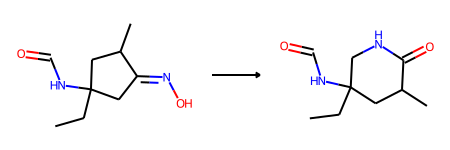

In [196]:
AllChem.ReactionFromSmarts(rxns_list[5], useSmiles = True)

In [181]:
preds_T3

['CCCc1nocn1C1CC1O',
 'CCC(C)c1ccc(N)nc1',
 'CCC(C)(C)C1(NC=O)CC1N',
 'CC(C)CC1(NC=O)CCC1N',
 'CC(C)[C@H](CC=O)NC=O',
 'CCC1(NC=O)CC(N)C(C)C1',
 'CC(C)N(C=O)C1CCC(N)C1',
 'CNC(=N)CC1(C)CCC1C',
 'CC1C2CCC3CC(N)N1C=O',
 'C#CC(C)Cc1ncon1',
 'CC(N)CCCC(C)(C)NC=O',
 'CC1CC2(C)CC(N)N(C=O)C12',
 'CN(C=O)C1(C)CCCC(N)C1',
 'CCC(N)(CC)CC(C)(CC)N',
 'CC1(C)CCC(N)C1(C)NC=O',
 'CCCC1(CC(N)C=O)CO1',
 'CCc1ncc(CCC=O)n1O',
 'CCC1(NC=O)C(N)CC1(C)C',
 'CC(N)CC1CCC(C)N1C=O',
 'CCCCC(=NO)CCNC=O',
 'CC1(C)CC(N)CCC1NC=O',
 'CCCCc1cc(C)ncn1']

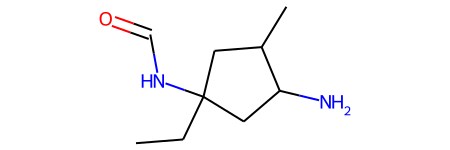

In [197]:
Chem.MolFromSmiles(preds_T3[5])

For forward tag forward validation

In [201]:
preds_T3_FT, probs_T3_FT = bw.run_T3_predictions(rxns_T2_to_T3_tok, Model_path_T3_FT, beam_size = 3, batch_size = 64, untokenize_output = True)

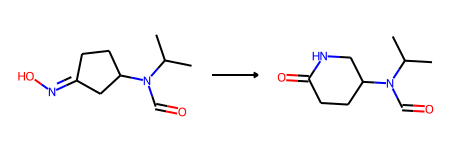

In [204]:
AllChem.ReactionFromSmarts(rxns_list[6], useSmiles = True)

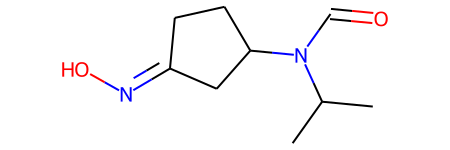

In [205]:
Chem.MolFromSmiles(preds_T3_FT[6])

input data for the forward tag T3 is: tagged ! + tokenized reactants > tagged ! + tokenized product

In [212]:
#map reactants and products
from ttlretro.single_step_retro import SingleStepRetrosynthesis
singlestepretrosynthesis = SingleStepRetrosynthesis()
MappedReactions = list(singlestepretrosynthesis.rxn_mapper_batch.map_reactions(rxns_list))

Some weights of the model checkpoint at /home/yves/anaconda3/envs/MultiStepRetro/lib/python3.8/site-packages/rxnmapper/models/transformers/albert_heads_8_uspto_all_1310k were not used when initializing AlbertModel: ['predictions.decoder.bias', 'predictions.dense.bias', 'predictions.decoder.weight', 'predictions.bias', 'predictions.LayerNorm.bias', 'predictions.dense.weight', 'predictions.LayerNorm.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at /home/yves/anaconda3/envs/MultiStepRetro/lib/python3.8/site-packages/rxnmapper/models/transfo

In [222]:
#tag reactants and products
#tag reactants
taggedreactants = [singlestepretrosynthesis.rxn_mark_center.TagMappedReactionCenter(MappedReactions[i], alternative_marking = True, tag_reactants = True).split('>>')[0] for i in range(len(MappedReactions))]
#tag products
#taggedproducts = [singlestepretrosynthesis.rxn_mark_center.TagMappedReactionCenter(MappedReactions[i], alternative_marking = True, tag_reactants = False).split('>>')[1] for i in range(len(MappedReactions))]

In [233]:
reconstructed_rxns = [taggedreactants[i] + '>' + preds_T2[i] for i in range(len(preds_T2))]

In [235]:
reconstructed_rxns_tok = [singlestepretrosynthesis.smi_tokenizer(i) for i in reconstructed_rxns]

In [236]:
reconstructed_rxns_tok

['C C C ! C ! ( = N ! O ! ) O C 1 C C 1 N C = O > C C ( = O ) O . C C ( = O ) [O-] . C C O C ( C ) = O . O . [Na+]',
 'C C C ( C ) C # C C ! C ! ( = N ! O ! ) N C = O > C C O . Cl . O . O = C ( [O-] ) [O-] . [K+]',
 'C C C ( C ) ( C ) C 1 ( N C = O ) C ! C ! 1 = N ! O ! > C C ( = O ) O . O . [Zn]',
 'C C ( C ) C C 1 ( N C = O ) C C ! C ! 1 = N ! O ! > C C ( = O ) O . O . [Zn]',
 'C ! O ! C ! ( C ! C ( N C = O ) C ( C ) C ) = N ! O ! > C C ( = O ) O . O . [Zn]',
 'C C C 1 ( N C = O ) C ! C ! ( = N ! O ! ) C ( C ) C 1 > C C ( = O ) O . O = [Pt] = O',
 'C C ( C ) N ( C = O ) C 1 C C C ! ( = N ! O ! ) C ! 1 > C C ( = O ) O . O . [Zn]',
 'C C 1 C C C 1 ( C ) C ! C ! ( = N ! O ! ) N C ! = O ! > C C ( = O ) O . O . [Zn]',
 'C C 1 C 2 C C C 2 C ! C ! ( = N ! O ! ) N 1 C = O > C C ( = O ) O . O . [Zn]',
 'C # C C ( C ) C ! C ! ( = N ! O ! ) N ( C = O ) C C > C C O . O . [K+] . [OH-]',
 'C C ! ( C ! C C C ( C ) ( C ) N C = O ) = N ! O ! > C C ( = O ) O . O . [Zn]',
 'C C 1 C C 2 ( C ) C ! C ! ( 

In [253]:
preds_T3_FT, probs_T3_FT = run_T3_predictions(rxns_T2_to_T3_tok, Model_path_T3_FT, beam_size = 3, batch_size = 64, untokenize_output = True)
ind_match = find_ind_match_T3_preds_ref(preds_T3_FT, rxns_list)
rxns_conf = keeps_match_confident_rxns(rxns_list, probs_T3_FT, ind_match, conf_score = 0.9)
rxns_conf

['CC1C2CCC2CC(=NO)N1C=O>>CC1C2CCC2CNC(=O)N1C=O',
 'CC1(C)CCC(=NO)C1(C)NC=O>>CC1(C)CCNC(=O)C1(C)NC=O']

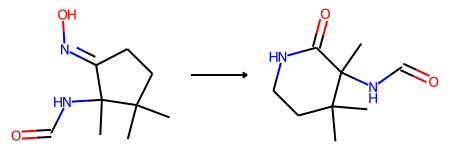

In [255]:
AllChem.ReactionFromSmarts(rxns_conf[1], useSmiles = True)

compare rxns_list expectations and forward tag 

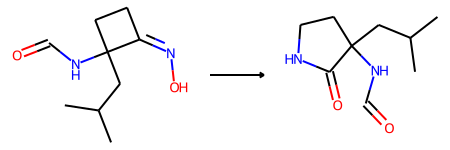

In [245]:
AllChem.ReactionFromSmarts(rxns_list[3], useSmiles = True)

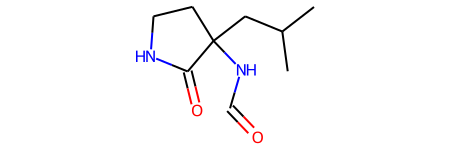

In [246]:
Chem.MolFromSmiles(preds_T3_FT[3])

In [ ]:
#rewrite new function to give the right inputs to T3
def prepare_rxns_T2_for_T3(rxns_list, preds_T2):
    
    MappedReactions = list(singlestepretrosynthesis.rxn_mapper_batch.map_reactions(rxns_list))
    taggedreactants = [singlestepretrosynthesis.rxn_mark_center.TagMappedReactionCenter(MappedReactions[i], alternative_marking = True, tag_reactants = True).split('>>')[0] for i in range(len(MappedReactions))]
    reconstructed_rxns = [taggedreactants[i] + '>' + preds_T2[i] for i in range(len(preds_T2))]
    reconstructed_rxns_tok = [singlestepretrosynthesis.smi_tokenizer(i) for i in reconstructed_rxns]
    return reconstructed_rxns_tok

### 3.2.3 Investigation on throughput of reactions

In [118]:
#GDB13S_1
GDB13S_path = "/home/yves/Documents/GitHub/USPTO_balance/data/GDB13S_1.txt"
with open(GDB13S_path, 'r') as f:
    GDB13S = []
    for line in f:
        GDB13S.append(line.split('\n')[0])

In [119]:
len(GDB13S)

993942

In [120]:
#number of matches for lactame (not necessarily cyclic)
GDB13S_sub_Beckmann_path = '/home/yves/Documents/GitHub/USPTO_balance/GDB_subsets_1_Beckmann/GDB13S_sub_[C:1][N:3][CH:2]=[O:4].txt'
with open(GDB13S_sub_Beckmann_path, 'r') as f:
    GDB13S_sub_Beckmann = []
    for line in f:
        GDB13S_sub_Beckmann.append(line.split('\n')[0])

In [121]:
len(GDB13S_sub_Beckmann)

9773

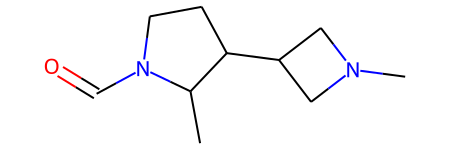

In [162]:
GDB13S_sub_mol[3003]

In [145]:
#number of created reactions for Beckmann rearrangements
created_Beckmann_reactions_path = '/home/yves/Documents/GitHub/USPTO_balance/created_rxns_1_Beckmann/rxns_[C:1][N:3][CH:2]=[O:4]_([CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4])>>([CH2;D2;+0:1]-[C;H0;D3;+0:2]=[N;H0;D2;+0:3]-[OH;D1;+0:4]).txt'
with open(created_Beckmann_reactions_path, 'r') as f:
    created_Beckmann_reactions = []
    for line in f:
        created_Beckmann_reactions.append(line.split('\n')[0])

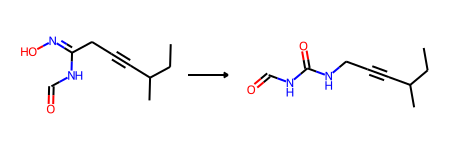

In [158]:
AllChem.ReactionFromSmarts(created_Beckmann_reactions[1], useSmiles = True)

In [123]:
len(created_Beckmann_reactions)

22

In [277]:
#number of validated Beckmann rearrangements
validated_Beckmann_reactions_path = '/home/yves/Documents/GitHub/USPTO_balance/saved_rxns_1_Beckmann/rxns_[C:1][N:3][CH:2]=[O:4]_([CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4])>>([CH2;D2;+0:1]-[C;H0;D3;+0:2]=[N;H0;D2;+0:3]-[OH;D1;+0:4]).txt'
with open(validated_Beckmann_reactions_path, 'r') as f:
    validated_Beckmann_reactions = []
    for line in f:
        validated_Beckmann_reactions.append(line.split('\n')[0])

In [268]:
len(validated_Beckmann_reactions)

2

In [278]:
validated_Beckmann_reactions

['CC1C2CCC2CC(=NO)N1C=O>>CC1C2CCC2CNC(=O)N1C=O',
 'CC1(C)CCC(=NO)C1(C)NC=O>>CC1(C)CCNC(=O)C1(C)NC=O']

In [283]:
#number of validated Beckmann rearrangements limited to 10000 reactions
lines_number = 10000
validated_Beckmann_reactions_path = '/home/yves/Documents/GitHub/USPTO_balance/saved_rxns_1_Beckmann/rxns_[C:1][N:3][CH:2]=[O:4]_([CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4])>>([CH2;D2;+0:1]-[C;H0;D3;+0:2]=[N;H0;D2;+0:3]-[OH;D1;+0:4]).txt'
with open(validated_Beckmann_reactions_path, 'r') as f:
    validated_Beckmann_reactions = []
    validated_Beckmann_reactions = list(islice(f, lines_number))
    validated_Beckmann_reactions = [validated_Beckmann_reactions[i].split('\n')[0] for i in range(len(validated_Beckmann_reactions))]

In [284]:
validated_Beckmann_reactions

['CC1C2CCC2CC(=NO)N1C=O>>CC1C2CCC2CNC(=O)N1C=O',
 'CC1(C)CCC(=NO)C1(C)NC=O>>CC1(C)CCNC(=O)C1(C)NC=O']

## 3.3 Standardize the call of config files with template_version / GDB_version throughout all the parts 

### 3.3.1 How is it done in part 1

In [ ]:
#config file part 1 looks like this
GDB_version = "1"
template_version = "Beckmann"
GDB13S_path: "/home/yves/Documents/GitHub/USPTO_balance/data/GDB13S_1.txt"
df_templates_path_to_pkl: "/home/yves/Documents/GitHub/USPTO_balance/data/templates_split/df_templates_to_enrich_part_Beckmann.pkl"

In [ ]:
#main part 1 looks like this
def main(GDB13S_path, df_templates_path_to_pkl, GDB_version, template_version):

    # Load GDB13S dataset
    with open(GDB13S_path, 'r') as f:
        GDB13S = [line.strip() for line in f]

    # Convert SMILES to RDKit molecule objects in parallel
    processes = os.cpu_count() - 2
    with Pool(processes) as p:
        output = list(tqdm(p.imap(smiles_to_mol, GDB13S), total=len(GDB13S)))
    GDB13S_mol = output

    #load df_templates prepared in (*)
    df_templates = pd.read_pickle(df_templates_path_to_pkl)

    # Extract subsets based on unique retro_reac values
    unique_retro_reac_values = df_templates['retro_reac'].unique()
    for retro_reac in unique_retro_reac_values:
        GDB13S_sub, GDB13S_sub_mol = extract_match_smiles_from_dataset(GDB13S, GDB13S_mol, retro_reac)
        convert_and_save_subset(GDB13S_sub, GDB13S_sub_mol, retro_reac, GDB_version, template_version)


### 3.3.2 How it is done in part 2

In [ ]:
#config file part 2 looks like this
df_templates_path_to_pkl: "/home/yves/Documents/GitHub/USPTO_balance/data/templates_split/df_templates_to_enrich_part_Beckmann.pkl"
GDB_version = "1"
template_version = "Beckmann"

In [ ]:
def main(df_templates_path, GDB_version, template_version):
    
    #load df_templates prepared in (*)
    df_templates = pd.read_pickle(df_templates_path)

    for retro_reac, retro_template in tqdm(zip(df_templates['retro_reac'], df_templates['retro_templates'])):
        process_retro_template(retro_reac, retro_template, GDB_version, template_version)


### 3.3.3 How it is done in part 3

In [ ]:
#config files part 3 look like this
df_templates_path_to_pkl: "/home/yves/Documents/GitHub/USPTO_balance/data/templates_split//home/yves/Documents/GitHub/USPTO_balance/data/templates_split/df_templates_to_enrich_part_Beckmann.pkl"
GDB_version: "1"
template_version: "Beckmann"
Model_path_T2: "/home/yves/Documents/GitHub/TTL_versions/1.4/models/USPTO_STEREO_separated_T2_Reagent_Pred_225000.pt"
Model_path_T3: "/home/yves/Documents/GitHub/TTL_versions/1.4/models/USPTO_STEREO_separated_T3_Forward_255000.pt"

In [ ]:
def main(GDB_version, template_version, Model_path_T2, Model_path_T3):

    df_templates_split = load_template_version(template_version)

    for retro_reac, retro_template in tqdm(zip(df_templates_split['retro_reac'], df_templates_split['retro_templates'])):
        reactions_conf_validation(GDB_version, template_version, retro_reac, retro_template, Model_path_T2, Model_path_T3)

def load_template_version(template_version):
    df_templates_split = pd.read_pickle(f'/home/yves/Documents/GitHub/USPTO_balance/data/templates_split/df_templates_to_enrich_part_{template_version}.pkl')
    return df_templates_split


In [ ]:
#modified part 3
def main(GDB_version, df_templates_path_to_pkl, template_version, Model_path_T2, Model_path_T3):

    df_templates_split = pd.read_pickle(df_templates_path_to_pkl)

    for retro_reac, retro_template in tqdm(zip(df_templates_split['retro_reac'], df_templates_split['retro_templates'])):
        reactions_conf_validation(GDB_version, template_version, retro_reac, retro_template, Model_path_T2, Model_path_T3)

#with commented load_template_version function

## 3.4 Check that the limit of 10000 reactions to evaluate works

In [285]:
#delete
temp1 = pd.read_pickle('/home/yves/Documents/GitHub/USPTO_balance/data/templates_split/df_templates_to_enrich_part_1.pkl')

Some weights of the model checkpoint at /home/yves/anaconda3/envs/MultiStepRetro/lib/python3.8/site-packages/rxnmapper/models/transformers/albert_heads_8_uspto_all_1310k were not used when initializing AlbertModel: ['predictions.decoder.bias', 'predictions.dense.bias', 'predictions.decoder.weight', 'predictions.bias', 'predictions.LayerNorm.bias', 'predictions.dense.weight', 'predictions.LayerNorm.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at /home/yves/anaconda3/envs/MultiStepRetro/lib/python3.8/site-packages/rxnmapper/models/transfo

In [295]:
#save only the first line of temp1 to a pkl file to test the function
temp1[1:2].to_pickle('/home/yves/Documents/GitHub/USPTO_balance/data/templates_split/df_templates_to_enrich_first_template.pkl')


In [294]:
temp1.at[0, 'retro_templates']

'([O;H0;D2;+0:2]-[c;H0;D3;+0:1])>>(Cl-[c;H0;D3;+0:1]).([OH;D1;+0:2])'

### 3.4.1 Create config files for evaluating the first template

In [296]:
#imports to generate the config files
GDB_version = "1"
template_version = "first_template"
GDB13S_path = "/home/yves/Documents/GitHub/USPTO_balance/data/GDB13S_1.txt"
df_templates_path_to_pkl = "/home/yves/Documents/GitHub/USPTO_balance/data/templates_split/df_templates_to_enrich_first_template.pkl"
Model_path_T2 = "/home/yves/Documents/GitHub/TTL_versions/1.4/models/USPTO_STEREO_separated_T2_Reagent_Pred_225000.pt"
Model_path_T3 = "/home/yves/Documents/GitHub/TTL_versions/1.4/models/T3_Fwd_Tag_model_step_300000.pt"

In [297]:
#config part 1
with open(f'/home/yves/Documents/GitHub/USPTO_balance/config_files/config_part1_{template_version}.yaml', 'w') as f:
    f.write(f'GDB13S_path: "/home/yves/Documents/GitHub/USPTO_balance/data/GDB13S_{GDB_version}.txt"\n')
    f.write(f'df_templates_path_to_pkl: {df_templates_path_to_pkl}\n')
    f.write(f'GDB_version: "{GDB_version}"\n')
    f.write(f'template_version: "{template_version}"\n')

In [292]:
#config file part 2
with open(f'/home/yves/Documents/GitHub/USPTO_balance/config_files/config_part2_{template_version}.yaml', 'w') as f:
    f.write(f'df_templates_path_to_pkl: {df_templates_path_to_pkl}\n')
    f.write(f'GDB_version: "{GDB_version}"\n')
    f.write(f'template_version: "{template_version}"\n')

# 3 - Using USPTO as source of molecules

## 3.1 - Choose USPTO version 

### 3.1.1 Imports 

In [5]:
#uspto_df_path = '/home/yves/Documents/GitHub/ForwardTag/data/df_Thakkar_04_2023_Mapped.pkl' remove from clean version
uspto_df_path = "./your_folder_containing the pkl/"
uspto_df = pd.read_pickle('/home/yves/Documents/GitHub/ForwardTag/data/df_Thakkar_04_2023_Mapped.pkl')
uspto_temp_df = pd.read_pickle('/home/yves/Documents/GitHub/CASP-and-dataset-performance/results/amol_USPTO_templates_set_r0_v2_formatted.pkl')


### 3.1.2 Save USPTO molecules to 100 subsets 

In [72]:
##for the template version
##transform [A.B>>C, D.E>>F] into [A, B, C, D, E, F]
#split_rxns = list(chain.from_iterable(uspto_temp_df['UNMAPPED_SMILES'][el].split('>>') for el in range(len(uspto_temp_df))))
#split_rxns2 = list(chain.from_iterable(split_rxns[el].split('.') for el in range(len(split_rxns))))
#split_rxns3 = list(set(split_rxns2))
#
##we win 20% of reactions from the original cleaned uspto template list
#len(split_rxns3)/len(uspto_temp_df)

In [113]:
#transform [A.B>>C, D.E>>F] into [A, B, C, D, E, F]
split_rxns = list(chain.from_iterable(uspto_df['UNMAPPED_SMILES'][el].split('>>') for el in range(len(uspto_df))))
split_rxns2 = list(chain.from_iterable(split_rxns[el].split('.') for el in range(len(split_rxns))))
split_rxns3 = list(set(split_rxns2))

#we win 20% of reactions from the original cleaned uspto template list
len(split_rxns3)/len(uspto_df)

1.1887570713346292

Additional cleaning of USPTO ----------------------

In [ ]:
#first, create a dataframe
df = pd.DataFrame(data = split_rxns3, columns=['smiles'])

#calculate the mol for each smiles
df['mol'] = ''
for el in tqdm(range(len(df))):
    try:
        df.at[el, 'mol'] = Chem.MolFromSmiles(df.at[el, 'smiles'])
    except:
        print(el)

#mol that are None should be removed from the dataframe
sum(df['mol'].isnull().values)

#the dataframe is now only composed of valid molecules
df = df[[not el for el in df['mol'].isnull().values]]
df.reset_index(inplace=True, drop=True)

df['heavyatomcount'] = [Chem.rdMolDescriptors.CalcNumHeavyAtoms(df.at[el, 'mol']) for el in tqdm(range(len(df)))]

#save in case we need to load it later again
df.to_pickle('./df_USPTO_smiles_mol_HAC.pkl') #deleted from local because storage

In [ ]:
import matplotlib.pyplot
df['heavyatomcount'].hist(bins=100)

In [15]:
df = df[df['heavyatomcount']<79]
df.to_pickle('./df_USPTO_smiles_mol_HACsmallerthan79.pkl') #deleted from local because storage

Imports done


In [14]:
uspto_df_path = '/home/yves/Documents/GitHub/test_folder/data/'
#uspto_df = pd.read_pickle(uspto_df_path)

uspto_products = df['smiles'].values.tolist()
uspto_products_sublists = np.array_split(uspto_products, 100)

for i in range(len(uspto_products_sublists)):
    with open(f'{uspto_df_path}USPTO_{i+1}.txt', 'w') as f:
        for item in uspto_products_sublists[i]:
            f.write("%s\n" % item)

# 4. Final and clean enrichment workflow

conda create -n uspto_balance

conda activate uspto_balance

cd ./to/your/path/

git clone github uspto_balance_repo

pip install -e .

## 4.1 Download and split the dataset of interest that will be used as base for creating new reactions

### 4.1.1 Split and save GDB13S  

In [ ]:
#example, download and split GDB13S dataset
#go to https://gdb.unibe.ch/downloads/ and download GDB13S in ./your_folder/13S.smi
#the dataset needs to be split into 100 txt files in order for the framework to work:

GDB13S_path = "./your_folder/" #complete here

with open(f'{GDB13S_path}13S.smi', 'r') as f:
    GDB13S = []
    for line in f:
        GDB13S.append(line.split('\n')[0])

GDB13S_sublists = np.array_split(GDB13S, 100)

for i in range(len(GDB13S_sublists)):
    with open(f'{GDB13S_path}GDB13S_{i+1}.txt', 'w') as f:
        for item in GDB13S_sublists[i]:
            f.write("%s\n" % item)

### 4.1.2 Split and save USPTO

In [16]:
#uspto_df_path = '/home/yves/Documents/GitHub/ForwardTag/data/df_Thakkar_04_2023_Mapped.pkl' remove from clean version
uspto_df_path = "./your_folder_containing the pkl/"
uspto_df = pd.read_pickle(uspto_df_path)

uspto_products = [uspto_df.at[i, 'Prod_cleared']for i in range(len(uspto_df))]

uspto_products_sublists = np.array_split(uspto_products, 100)

for i in range(len(uspto_products_sublists)):
    with open(f'{uspto_df_path}USPTO_{i+1}.txt', 'w') as f:
        for item in uspto_products_sublists[i]:
            f.write("%s\n" % item)

### 4.1.3 Create the dataframe containing the templates to enrich

In [ ]:
#add tutorial 

## 4.2 Load dataframe containing the templates to enrich (prepared in 4.1.2) + prepare config files

### 4.2.0 Load df

In [6]:
df = pd.read_pickle('/home/yves/Documents/GitHub/test_folder/dataframes/df_templates_to_enrich.pkl') #full dataframe
df_beckmann = pd.read_pickle('/home/yves/Documents/GitHub/test_folder/dataframes/df_templates_to_enrich_part_Beckmann1245.pkl') #subset dataframe used for testing

[autoreload of ttlretro.rxnmarkcenter failed: Traceback (most recent call last):
  File "/home/yves/anaconda3/envs/uspto_balance/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 273, in check
    superreload(m, reload, self.old_objects)
  File "/home/yves/anaconda3/envs/uspto_balance/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 471, in superreload
    module = reload(module)
  File "/home/yves/anaconda3/envs/uspto_balance/lib/python3.8/importlib/__init__.py", line 148, in reload
    raise ImportError(msg.format(name), name=name)
ImportError: module rxnmarkcenter not in sys.modules
]
[autoreload of ttlretro.single_step_retro failed: Traceback (most recent call last):
  File "/home/yves/anaconda3/envs/uspto_balance/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 273, in check
    superreload(m, reload, self.old_objects)
  File "/home/yves/anaconda3/envs/uspto_balance/lib/python3.8/site-packages/IPython/extensions/autoreload.py

prepare example config file for the Beckmann rearrangement example

In [7]:
df_beckmann

,template_hash,frequency,retro_templates,retro_reac
0,0d938ab3c0af19f5f23273ede308f1cbe0b61f5f420146...,1209,([CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;...,[CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H...
1,1b99f50657689f2ff9980a59068a2f6624c6f6de03ef7b...,20,([O;H0;D1;+0:1]=[C;H0;D3;+0:3]-[NH;D2;+0:2]-[c...,[O;H0;D1;+0:1]=[C;H0;D3;+0:3]-[NH;D2;+0:2]-[c;...
2,c63902669f8afa0ad6dc45d47866960cf67b03adf80277...,16,([O;H0;D1;+0:1]=[C;H0;D3;+0:3]-[NH;D2;+0:2]-[c...,[O;H0;D1;+0:1]=[C;H0;D3;+0:3]-[NH;D2;+0:2]-[c;...


In [8]:
#Prepare config file for dataset (whose templates were extracted in 4.1.2) equilibration of first retro_reac and retro_template (TEST)
dataset_name       = 'GDB13S'
retro_reac         = df_beckmann.iloc[0]['retro_reac'] 
retro_template     = df_beckmann.iloc[0]['retro_templates']
path_to_folder     = '/home/yves/Documents/GitHub/test_folder/'
path_models        = '/home/yves/Documents/GitHub/TTL_versions/1.4/models/'
template_frequency = df_beckmann.iloc[0]['frequency']
frequency_target   = 100

config_file_full = f'{path_to_folder}config_files/config_full_{retro_reac}.yaml'.replace(';','')

with open(f'{config_file_full}', 'w') as f:
    f.write(f'dataset_name: "{dataset_name}"\n')
    f.write(f'retro_reac: "{retro_reac}"\n')
    f.write(f'retro_template: "{retro_template}"\n')
    f.write(f'path_to_folder: "{path_to_folder}"\n')
    f.write(f'path_models: "{path_models}"\n')
    f.write(f'template_frequency: {template_frequency}\n')
    f.write(f'frequency_target: {frequency_target}')

### 4.2.1 Prepare config_files for every line in the dataframe

In [9]:
#write a config file for each line of the dataframe (let's only do from 0 to 10 for now)

dataset_name       = 'GDB13S'
retro_reac         = df_beckmann.iloc[i]['retro_reac'] 
retro_template     = df_beckmann.iloc[i]['retro_templates']
path_to_folder     = '/home/yves/Documents/GitHub/test_folder/'
path_models        = '/home/yves/Documents/GitHub/TTL_versions/1.4/models/'
template_frequency = df_beckmann.iloc[i]['frequency']
frequency_target   = df_beckmann.iloc[i]['frequency'] + 100 #for first calculations, replace by 10'000 in final method

config_file_full = f'{path_to_folder}config_files/config_full_{retro_reac}.yaml'.replace(';','')

with open(f'{config_file_full}', 'w') as f:
    f.write(f'dataset_name: "{dataset_name}"\n')
    f.write(f'retro_reac: "{retro_reac}"\n')
    f.write(f'retro_template: "{retro_template}"\n')
    f.write(f'path_to_folder: "{path_to_folder}"\n')
    f.write(f'path_models: "{path_models}"\n')
    f.write(f'template_frequency: {template_frequency}\n')
    f.write(f'frequency_target: {frequency_target}')

,template_hash,frequency,retro_templates,retro_reac
0,154a266ded329783e2edd97afda37dcc79a77eb501e212...,9594,([O;H0;D2;+0:2]-[c;H0;D3;+0:1])>>(Cl-[c;H0;D3;...,[cH3:1][OH:2]
1,d572f15ce843682d57bd39cd6c8575947b70a50f4c6527...,9461,([CH;D2;+0:1]=[O;H0;D1;+0:2])>>([CH2;D2;+0:1]-...,[C:1]=[O:2]
2,ab03ec2e113ad21265223676d461baf815168d6c7b2190...,8230,([C;H0;D3;+0:1]=[N;H0;D2;+0:2])>>(O=[C;H0;D3;+...,[CH2:1]=[NH:2]
3,075d673cff5ec4531a74899eab1365e439a32f4c8b9037...,7853,([CH2;D2;+0:1]-[CH2;D2;+0:2])>>([CH;D2;+0:1]=[...,[C:1][C:2]
4,3c23d7484bb108274ce3044df7aec2c2dd6107ec5ca792...,7833,([CH2;D2;+0:1]-[n;H0;D3;+0:2])>>(Br-[CH2;D2;+0...,[C:1][nH2:2]
...,...,...,...,...
5552,33c82e09e9528ae1f170065cb8529dd91ca7ddd45c4ea8...,10,([CH2;D2;+0:3]-[C;H0;D3;+0:1]-[NH2;D1;+0:2])>>...,[CH2:1]([N:2])[C:3]
5553,4fd1f87303fb64d23793a5141afe558cc8e8706f8862d7...,10,([C;H0;D3;+0:1]-[NH;D2;+0:2])>>(C-O-C(=O)-C-N-...,[CH3:1][N:2]
5554,540e2d1754cd1abfe987ca68d05a0d3e0ab395ec72ee9e...,10,([c;H0;D3;+0:1]-[c;H0;D3;+0:2])>>(O-[c;H0;D3;+...,[cH3:1]-[cH3:2]
5555,595c50cf653434fe012465461e668a6067d7d1bc03bc5c...,10,([CH2;D2;+0:1]-[CH;D2;+0:2])>>(O-C/C=C\[CH2;D2...,[C:1][C:2]


## 4.x How to look for a specific reactivity and enrich it

### 4.x.1 Oxidation of alcohol to ketone

In [14]:
#uspto_df_path = '/home/yves/Documents/GitHub/ForwardTag/data/df_Thakkar_04_2023_Mapped.pkl' remove from clean version 
#uspto_df = pd.read_pickle(uspto_df_path)
#uspto_df
uspto_temp_df = pd.read_pickle('/home/yves/Documents/GitHub/CASP-and-dataset-performance/results/amol_USPTO_templates_set_r0_v2_formatted.pkl')

In [209]:
uspto_temp_df

,reaction_hash,reactants,products,classification,retro_template,template_hash,selectivity,outcomes,Set,MAPPED_SMILES
0,e5660e6f195dc228acc0f1d98bd8abccb52d3511c6d78c...,CCOC(=O)[NH:1][CH:2]1[CH2:3][CH2:4][N:5]([c:6]...,[NH2:1][CH:2]1[CH2:3][CH2:4][N:5]([c:6]2[cH:7]...,NaN,([NH2;D1;+0:1])>>(C-C-O-C(=O)-[NH;D2;+0:1]),4bbcd16063192bad75d5aefffb84c58c3c67f175d81546...,1.000000,1.0,TRAIN,CCOC(=O)[NH:1][CH:2]1[CH2:3][CH2:4][N:5]([c:6]...
1,c046aafc3f4e93b66a1ab6d92de3bf9264124dcdf4b611...,ClCCl.[CH3:1][CH2:2][C@@H:3]([NH:4][c:5]1[cH:6...,[CH3:1][CH2:2][C@@H:3]([NH:4][c:5]1[cH:6][cH:7...,NaN,([C;H0;D3;+0:1]=[O;H0;D1;+0:2])>>([CH;D3;+0:1]...,d572f15ce843682d57bd39cd6c8575947b70a50f4c6527...,1.000000,1.0,TRAIN,ClCCl.[CH3:1][CH2:2][C@@H:3]([NH:4][c:5]1[cH:6...
2,7000bdcc832d12217e3b90b90107609ef0b841a84cbb1f...,CCCC(C)C(=O)C(=O)C(C)(C)C.CCOC(C)=O.CN1CCCC1=O...,[Cl:1][c:2]1[cH:3][cH:4][cH:5][cH:6][c:7]1[S:8...,NaN,([S;H0;D2;+0:2]-[c;H0;D3;+0:1])>>(I-[c;H0;D3;+...,447e61623ec195f5e49766b1eb5e80e8c626ef08b01cf1...,0.500000,2.0,TRAIN,CCCC(C)C(=O)C(=O)C(C)(C)C.CCOC(C)=O.CN1CCCC1=O...
3,564da4cdbeeff04368b1f305d977fc9ffaecbb6e29744d...,Br[CH2:11][CH2:10][CH2:9][CH2:8][O:7][c:6]1[cH...,[O:1]=[c:2]1[nH:3][c:4]2[cH:5][c:6]([O:7][CH2:...,NaN,([CH2;D2;+0:1]-[N;H0;D3;+0:2])>>(Br-[CH2;D2;+0...,48f112f542979a51e8ad5b51eceb82f0e3283be74d6c23...,0.333333,3.0,TRAIN,Br[CH2:11][CH2:10][CH2:9][CH2:8][O:7][c:6]1[cH...
4,be00ca6cedffd0e4bcd57983270c739f81ad94b5a3fd87...,CC#N.COC(OC)N(C)C.Cc1cccc(C)c1NC(=O)NC(=N)NCC(...,[CH3:1][c:2]1[cH:3][cH:4][cH:5][c:6]([CH3:7])[...,NaN,([c;H0;D3;+0:1]-[n;H0;D3;+0:2]1:[c;H0;D3;+0:3]...,1c225eaec03444a3732903befacae3c7539385167e0009...,1.000000,1.0,TRAIN,CC#N.COC(OC)N(C)C.Cc1cccc(C)c1NC(=O)NC(=N)NCC(...
...,...,...,...,...,...,...,...,...,...,...
1189631,9a76fcc306601390293dd009f6908181bc84b27f987186...,CC(C)O[B:9]1[O:10][C:11]([CH3:12])([CH3:13])[C...,[CH3:1][O:2][c:3]1[n:4][cH:5][cH:6][c:7]2[c:8]...,NaN,([B;H0;D3;+0:1]-[c;H0;D3;+0:2])>>(C-C(-C)-O-[B...,726731c0333e36dcaaada039eb9e39a42c9f4e8588e95e...,1.000000,1.0,TRAIN,CC(C)O[B:9]1[O:10][C:11]([CH3:12])([CH3:13])[C...
1189632,f6011ea3cbc02f346b2cc038e4151417eeeed6a3a2ab50...,Cl[c:20]1[n:19][c:8]([NH:9][CH2:10][c:11]2[cH:...,[F:1][C:2]([F:3])([F:4])[c:5]1[cH:6][c:7]2[c:8...,NaN,([c;H0;D3;+0:1]-[n;H0;D3;+0:2])>>(Cl-[c;H0;D3;...,194612270a3b0120d8e18ef6d4e757c90f7b4d97dd9c9b...,1.000000,1.0,TRAIN,Cl[c:20]1[n:19][c:8]([NH:9][CH2:10][c:11]2[cH:...
1189633,d461795d12050560636f726f4b44816d387c0e25606c1d...,I[c:13]1[cH:12][cH:11][c:10]([O:9][C@@H:8]2[S:...,[CH3:1][C:2](=[O:3])[O:4][C@@H:5]1[CH2:6][S:7]...,NaN,([C@@H;D3;+0:5]-[C@H;D3;+0:4]-[C@@H;D3;+0:3]-[...,09125b79d85286e5ab889090b706042a314e5cbc927dc1...,0.500000,2.0,TRAIN,I[c:13]1[cH:12][cH:11][c:10]([O:9][C@@H:8]2[S:...
1189634,b4bc10629a19cedf9b353425dd938d4d50a87f9d81dd3c...,C1CCOC1.CO.C[O:3][C:2](=[O:1])[CH2:4][N:5]1[CH...,[O:1]=[C:2]([OH:3])[CH2:4][N:5]1[CH2:6][CH2:7]...,NaN,([OH;D1;+0:1])>>(C-[O;H0;D2;+0:1]),e47a6bcf7282afc3a6a39e4104b8a0774e04e27fb968a8...,1.000000,1.0,TRAIN,C1CCOC1.CO.C[O:3][C:2](=[O:1])[CH2:4][N:5]1[CH...


In [236]:
#coh_pattern = Chem.MolFromSmarts('[C:1]-[OH:2]')
#ccoc_pattern = Chem.MolFromSmarts('[C][CX3:1](=[O:2])[#6]')
coh_to_ccoh_rxn_patt = AllChem.ReactionFromSmarts('[C:1]-[OH:2]>>[C][CX3:1](=[O:2])[#6]')
uspto_rxns = [AllChem.ReactionFromSmarts(uspto_temp_df.at[i, 'MAPPED_SMILES'], useSmiles=True) for i in range(len(uspto_temp_df))]

In [237]:
#if the reactions are not sanitized, they will not work in the HasReactionSubstructMatch function
for i in range(len(uspto_rxns)):
    AllChem.SanitizeRxn(uspto_rxns[i])

In [254]:
indices = []
for i in tqdm(range(len(uspto_rxns))):
    try:
        if AllChem.HasReactionSubstructMatch(uspto_rxns[i], coh_to_ccoh_rxn_patt):
            indices.append(i)
    except:
        print(i)
        continue

100%|██████████| 1189636/1189636 [00:05<00:00, 224820.58it/s]


In [255]:
len(indices)

36906

In [256]:
uspto_temp_df_oh_to_ket = uspto_temp_df.loc[indices]

In [262]:
uspto_temp_df_oh_to_ket['template_hash'].value_counts() #there are 7873 unique templates

d572f15ce843682d57bd39cd6c8575947b70a50f4c6527863077b764    2885
46c5bf4df09441d4931d8afec7832e2172f32d481ef7ed4f6564aaf3    2610
832eae5762ca58c8e3fa56bd0be634e62ecf5c846e531ba4ecf2f2b6    1469
07477b8c704c70d1b15471a3cc6e682b52adae313ee3df999f9a8bf3     861
e47a6bcf7282afc3a6a39e4104b8a0774e04e27fb968a84a03130ac0     629
                                                            ... 
c6a9298ebd0d02b578a29f36079bb101b683a6e18d5d8485cadfbb8d       1
d9eeea21dae83c9aa56600d48228a3b8c187c5f73f7628ff23cbb6e8       1
345602f22b70a25a3fc9ce06e03bd873ff4b12d83f944709072435ba       1
5554e166770ff5c436b00baaaafce9eb74abfc91646e42baf0bfc192       1
4cee81705718a5b6b44713f6cf42c687dca7ace970eab4b7fa628d61       1
Name: template_hash, Length: 7873, dtype: int64

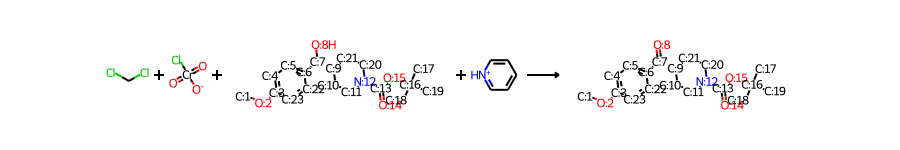

In [294]:
#observe the kind of reactions we have in the most present template(delete in last cleaning)
i = 3
match = uspto_temp_df_oh_to_ket['template_hash'].value_counts().index.tolist()[0]
AllChem.ReactionFromSmarts(uspto_temp_df_oh_to_ket[uspto_temp_df_oh_to_ket['template_hash']==match]['MAPPED_SMILES'].iloc[i], useSmiles=True)


In [303]:
#let's see if looking for the same template hash in the original dataframe we can find reactions that we missed earlier
match = uspto_temp_df_oh_to_ket['template_hash'].value_counts().index.tolist()[0] #most present template hash from the 7873 unique templates matching the reaction pattern
ind_temphash = uspto_temp_df[uspto_temp_df['template_hash']==match].index.tolist()
ind_rxnmatch = uspto_temp_df_oh_to_ket[uspto_temp_df_oh_to_ket['template_hash']==match].index.tolist()

In [305]:
#investigate corresponding template hashes that did not match the reaction pattern (1)
len(ind_temphash), len(ind_rxnmatch)

(9461, 2885)

In [312]:
#investigate corresponding template hashes that did not match the reaction pattern (2)
set_rxnmatch = set(ind_rxnmatch)
indices_not_in_rxnmatch = [value for index, value in enumerate(ind_temphash) if value not in set_rxnmatch] #len 6576


In [77]:
#investigate corresponding template hashes that did not match the reaction pattern (3)
i = 6
AllChem.ReactionFromSmarts(uspto_temp_df.iloc[indices_not_in_rxnmatch]['MAPPED_SMILES'].iloc[i], useSmiles=True)

NameError: name 'indices_not_in_rxnmatch' is not defined

In [332]:
#determine all the templates for the template hash to determine which one to use

match = uspto_temp_df_oh_to_ket['template_hash'].value_counts().index.tolist()[0]
uspto_temp_df[uspto_temp_df['template_hash']==match]['retro_template'].value_counts()#.index.tolist()


([CH;D2;+0:1]=[O;H0;D1;+0:2])>>([CH2;D2;+0:1]-[OH;D1;+0:2])     5979
([C;H0;D3;+0:1]=[O;H0;D1;+0:2])>>([CH;D3;+0:1]-[OH;D1;+0:2])    3482
Name: retro_template, dtype: int64

### 4.x.1 (2) Prepare config file for enrichment for alcohol oxidation to alcohol

In [335]:
#we noticed that it is 2nd line of df_template
#df_templates = pd.read_pickle('/home/yves/Documents/GitHub/USPTO_balance/data/df_templates_to_enrich.pkl')


In [338]:
#Prepare config file for dataset (whose templates were extracted in 4.1.2) equilibration of first retro_reac and retro_template (TEST)
dataset_name       = 'GDB13S'
retro_reac         = bw.rxn_smarts_to_sanitized_reactant_smarts(df_templates.iloc[1]['retro_templates']) 
retro_template     = df_templates.iloc[1]['retro_templates']
path_to_folder     = '/home/yves/Documents/GitHub/test_folder/'
path_models        = '/home/yves/Documents/GitHub/TTL_versions/1.4/models/'
template_frequency = df_templates.iloc[1]['frequency']
frequency_target   = 10000

config_file_full = f'{path_to_folder}config_files/config_full_{retro_reac}.yaml'.replace(';','')

with open(f'{config_file_full}', 'w') as f:
    f.write(f'dataset_name: "{dataset_name}"\n')
    f.write(f'retro_reac: "{retro_reac}"\n')
    f.write(f'retro_template: "{retro_template}"\n')
    f.write(f'path_to_folder: "{path_to_folder}"\n')
    f.write(f'path_models: "{path_models}"\n')
    f.write(f'template_frequency: {template_frequency}\n')
    f.write(f'frequency_target: {frequency_target}')

### 4.x.1 (3) Inspecting created reactions

In [40]:
#load the 539 created reactions
with open('/home/yves/Documents/GitHub/test_folder/results/saved_rxns/GDB13S/full_rxns_[CH;D2;+0:1]=[O;H0;D1;+0:2]_([CH;D2;+0:1]=[O;H0;D1;+0:2])>>([CH2;D2;+0:1]-[OH;D1;+0:2]).txt', 'r') as f:
    created_rxns = []
    for line in f:
        created_rxns.append(line.split('\n')[0])

In [73]:
i = 430

In [74]:
created_rxns[i]

'C#CC(NCO)c1cocc1CO>>C#CC(NC=O)c1cocc1CO'

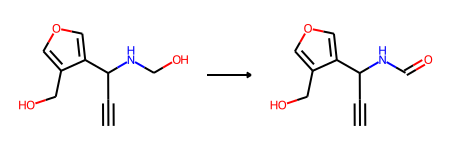

In [75]:
AllChem.ReactionFromSmarts(created_rxns[i], useSmiles = True)

### 4.x.1 (4) Preparing data for tmap

In [156]:
#load 5000 created reactions with GDB as molecules pool
with open('/home/yves/Documents/GitHub/test_folder/results/saved_rxns/GDB13S_rand/full_rxns_[CH;D2;+0:1]=[O;H0;D1;+0:2]_([CH;D2;+0:1]=[O;H0;D1;+0:2])>>([CH2;D2;+0:1]-[OH;D1;+0:2]).txt', 'r') as f:
    created_rxns_GDB13S = []
    for line in f:
        created_rxns_GDB13S.append(line.split('\n')[0])

#load 5000 created reactions with USPTO as molecules pool
with open('/home/yves/Documents/GitHub/test_folder/results/saved_rxns/USPTO/full_rxns_[CH;D2;+0:1]=[O;H0;D1;+0:2]_([CH;D2;+0:1]=[O;H0;D1;+0:2])>>([CH2;D2;+0:1]-[OH;D1;+0:2]).txt', 'r') as f:
    created_rxns_USPTO = []
    for line in f:
        created_rxns_USPTO.append(line.split('\n')[0])

#load uspto with extracted templates version
uspto_temp_df = pd.read_pickle('/home/yves/Documents/GitHub/CASP-and-dataset-performance/results/amol_USPTO_templates_set_r0_v2_formatted.pkl')

In [164]:
original_rxns = uspto_temp_df[uspto_temp_df['retro_template'] == '([CH;D2;+0:1]=[O;H0;D1;+0:2])>>([CH2;D2;+0:1]-[OH;D1;+0:2])']['UNMAPPED_SMILES'].tolist()

random.seed(42)
random.shuffle(original_rxns)
original_rxns = original_rxns[:5000]
total_rxns = created_rxns_GDB13S + created_rxns_USPTO + original_rxns
labels = [0]*5000 + [1]*5000 + [2]*5000

In [165]:
#load uspto with templates dataset
rxnstmap = pd.DataFrame()
rxnstmap['rxn_smiles'] = total_rxns
rxnstmap['is_original_rxn'] = labels
rxnstmap.to_csv('/home/yves/Documents/GitHub/test_folder/dataframes/rxnstmap_alc_ox_to_ket.csv')

In [166]:
rxnstmap

,rxn_smiles,is_original_rxn
0,CC1NC2CCN3C(C2)CC13CO>>CC1NC2CCN3C(C2)CC13C=O,0
1,CC12CCC(C1)CC2(O)CNCO>>CC12CCC(C1)CC2(O)CNC=O,0
2,CC1(CO)C2CC3C(CCC31)N2>>CC1(C=O)C2CC3C(CCC31)N2,0
3,COc1cc(CCO)[nH]c1C>>COc1cc(CC=O)[nH]c1C,0
4,C#CC1(CO)CC2(O)CC1(C)C2C>>C#CC1(C=O)CC2(O)CC1(...,0
...,...,...
14995,COc1cc2c(cc1OC)[C@@H](CO)N(C(=O)C1Cc3ccccc3CN1...,2
14996,CC(C)(CO)CO[Si](C)(C)C(C)(C)C.CCN(CC)CC.ClCCl....,2
14997,CCN(CC)CC.CS(C)=O.Cc1c(CO)cccc1OCC(=O)OC(C)(C)...,2
14998,ClC(Cl)Cl.O=[Mn]=O.OCc1cc2nccn2cc1-c1ccc(Cl)cc...,2


### 4.x.2 Ring closing metathesis

In [4]:
#load uspto with templates dataset
uspto_temp_df = pd.read_pickle('/home/yves/Documents/GitHub/CASP-and-dataset-performance/results/amol_USPTO_templates_set_r0_v2_formatted.pkl')

We are unable to determine a SMARTS sequence that would find matches in USPTO, so we'll extract the template from the typical ring closing metathesis reaction to see if it works

In [32]:
ring_clo_rxn = 'C=CCCCCC=C>>C1=CCCCC1'
ring_clo_rxn_mapped = list(rxnmarkcenter.rxn_mapper_batch.map_reactions([ring_clo_rxn]))[0]

In [34]:
ring_clo_rxn_mapped

'C=C[CH2:6][CH2:5][CH2:4][CH2:3][CH:2]=[CH2:1]>>[CH:1]1=[CH:2][CH2:3][CH2:4][CH2:5][CH2:6]1'

In [35]:
Chem.MolFromSmiles(ring_clo_rxn_mapped)

Mapping did not seem to capture the reactivity of ring closing metathesis

In [5]:
#test [C:1]=[C:2].[C:3]=[C:4]>>[C:1]=[C:3].[C;H2:2]=[C;H2:4] (1) --> 0 match
#[C:1]=[C:2].[C:3]=[C:4]>>[C:1]=[C:3] (2) --> 102427 matches
#[C:1]=[C:2].[C:3]=[C:4]>>[C;R1:1]=[C;R1:3] (2) --> 0 match
ring_meta_rxn_patt = AllChem.ReactionFromSmarts('[C:1]=[C:2].[C:3]=[C:4]>>[C;R1:1]=[C;R1:3]')

In [6]:
uspto_rxns = [AllChem.ReactionFromSmarts(uspto_temp_df.at[i, 'MAPPED_SMILES'], useSmiles=True) for i in range(len(uspto_temp_df))]

#if the reactions are not sanitized, they will not work in the HasReactionSubstructMatch function
for i in range(len(uspto_rxns)):
    AllChem.SanitizeRxn(uspto_rxns[i])

In [7]:
indices = []
for i in tqdm(range(len(uspto_rxns))):
    try:
        if AllChem.HasReactionSubstructMatch(uspto_rxns[i], ring_meta_rxn_patt):
            indices.append(i)
    except:
        print(i)
        continue

  0%|          | 0/1189636 [00:00<?, ?it/s]

  1%|          | 7824/1189636 [00:00<00:29, 40151.73it/s]

17
18
23
28
39
41
46
54
82
104
118
119
121
122
124
136
138
147
149
151
167
183
190
200
204
217
223
227
231
236
239
250
272
292
296
299
300
321
328
332
341
342
343
364
368
373
380
390
405
411
418
419
433
444
460
467
469
475
478
483
499
505
507
526
532
533
534
537
556
561
572
574
582
587
591
596
610
619
620
625
642
643
654
666
678
679
680
681
689
711
713
720
721
722
733
735
737
738
749
753
759
775
785
808
809
819
835
841
844
847
854
857
869
887
890
897
908
917
922
925
928
943
944
954
973
976
986
1006
1034
1046
1056
1060
1073
1075
1079
1086
1097
1106
1116
1121
1135
1155
1158
1168
1175
1176
1177
1193
1194
1204
1212
1217
1218
1221
1229
1232
1233
1237
1254
1260
1266
1269
1276
1286
1296
1308
1318
1329
1334
1338
1340
1344
1346
1354
1361
1380
1381
1395
1396
1403
1409
1427
1436
1450
1452
1463
1476
1501
1512
1513
1514
1520
1525
1530
1535
1544
1556
1573
1622
1633
1651
1653
1667
1668
1670
1676
1689
1696
1705
1707
1712
1723
1727
1728
1729
1731
1739
1743
1765
1777
1783
1798
1802
1806
1808
1809
1818
1

  1%|▏         | 16363/1189636 [00:00<00:27, 41913.41it/s]

10160
10164
10165
10177
10178
10183
10194
10199
10207
10212
10219
10222
10225
10235
10255
10265
10271
10278
10279
10285
10286
10287
10303
10307
10318
10346
10355
10359
10363
10365
10371
10375
10399
10407
10415
10430
10442
10451
10454
10455
10467
10470
10472
10476
10486
10498
10505
10507
10513
10517
10519
10525
10535
10536
10540
10544
10549
10555
10557
10560
10573
10578
10580
10595
10602
10603
10625
10637
10672
10677
10679
10689
10690
10693
10698
10701
10712
10717
10719
10720
10728
10739
10752
10762
10763
10771
10774
10778
10787
10796
10802
10805
10812
10818
10827
10830
10832
10833
10838
10845
10849
10857
10863
10865
10867
10868
10869
10880
10884
10888
10889
10898
10902
10916
10919
10926
10929
10944
10946
10953
10972
10974
10975
10996
11000
11007
11020
11032
11057
11059
11062
11067
11068
11084
11087
11107
11108
11127
11150
11155
11156
11161
11168
11172
11180
11183
11189
11192
11195
11198
11201
11203
11206
11207
11209
11230
11261
11262
11280
11293
11297
11299
11307
11316
11317
11321
1132

  2%|▏         | 25183/1189636 [00:00<00:26, 43287.34it/s]

19339
19340
19347
19384
19393
19394
19404
19420
19421
19445
19449
19458
19459
19461
19531
19538
19545
19566
19574
19576
19583
19615
19617
19619
19629
19646
19648
19649
19659
19663
19681
19689
19695
19699
19702
19706
19708
19715
19720
19724
19727
19742
19745
19754
19756
19761
19765
19768
19770
19778
19787
19798
19804
19806
19814
19819
19830
19834
19844
19857
19872
19878
19888
19894
19896
19899
19904
19913
19938
19946
19947
19954
19955
19959
19969
19976
19978
19987
19995
19998
20007
20018
20024
20028
20031
20042
20051
20061
20066
20069
20091
20096
20104
20105
20109
20114
20116
20118
20127
20140
20141
20147
20164
20190
20201
20210
20226
20230
20234
20237
20250
20251
20261
20262
20267
20274
20289
20291
20293
20296
20306
20312
20313
20315
20321
20327
20347
20357
20368
20379
20383
20392
20395
20403
20409
20410
20411
20422
20423
20429
20433
20442
20445
20460
20462
20465
20476
20483
20490
20506
20507
20509
20510
20526
20527
20544
20561
20565
20574
20576
20596
20597
20604
20606
20610
20619
2062

  3%|▎         | 34362/1189636 [00:00<00:26, 44163.93it/s]

29314
29316
29329
29331
29348
29352
29354
29372
29380
29383
29393
29398
29401
29403
29412
29427
29428
29430
29432
29437
29471
29472
29474
29485
29503
29506
29507
29516
29525
29526
29527
29528
29529
29530
29531
29532
29533
29535
29536
29559
29564
29573
29603
29651
29656
29659
29673
29680
29681
29689
29700
29709
29713
29714
29717
29721
29739
29745
29746
29747
29749
29751
29754
29755
29767
29768
29770
29771
29776
29790
29795
29796
29811
29812
29813
29815
29821
29847
29851
29852
29877
29882
29883
29884
29888
29889
29894
29905
29906
29907
29910
29913
29917
29919
29920
29932
29934
29935
29936
29937
29939
29946
29954
29955
29956
29967
29969
29973
29978
29982
29985
30021
30023
30055
30059
30074
30084
30093
30098
30120
30156
30163
30168
30174
30176
30178
30180
30198
30202
30205
30209
30216
30218
30222
30224
30227
30233
30263
30264
30267
30277
30287
30293
30294
30299
30305
30313
30315
30347
30350
30353
30354
30360
30368
30373
30375
30376
30398
30400
30406
30409
30443
30452
30459
30463
30476
3048

  4%|▍         | 48040/1189636 [00:01<00:26, 43726.25it/s]

39079
39085
39104
39114
39116
39122
39129
39135
39142
39143
39150
39153
39204
39206
39224
39225
39227
39235
39252
39253
39254
39256
39259
39261
39275
39277
39280
39284
39287
39311
39313
39314
39319
39320
39322
39327
39333
39334
39339
39343
39344
39345
39351
39352
39365
39368
39374
39375
39376
39383
39395
39418
39430
39437
39439
39455
39457
39465
39466
39476
39478
39482
39487
39489
39491
39494
39499
39502
39509
39511
39526
39542
39554
39565
39570
39571
39579
39580
39587
39588
39592
39612
39623
39638
39644
39649
39651
39669
39675
39683
39687
39691
39695
39711
39714
39719
39720
39721
39722
39726
39739
39740
39742
39743
39758
39762
39773
39790
39796
39800
39801
39809
39850
39853
39858
39860
39861
39868
39881
39891
39892
39893
39910
39915
39918
39931
39933
39938
39948
39957
39971
39972
39975
39978
39989
40002
40005
40009
40032
40035
40049
40051
40054
40061
40064
40082
40098
40100
40116
40133
40142
40143
40155
40169
40174
40177
40179
40186
40187
40188
40189
40190
40191
40195
40204
40215
4021

  5%|▍         | 56681/1189636 [00:01<00:27, 41267.23it/s]

50858
50863
50872
50878
50885
50889
50890
50903
50905
50910
50914
50915
50922
50932
50937
50940
50964
50972
50973
50976
50986
50987
50988
50994
51011
51014
51021
51028
51029
51033
51038
51039
51044
51047
51049
51064
51069
51073
51094
51110
51114
51115
51119
51122
51126
51128
51132
51147
51154
51167
51185
51195
51198
51203
51211
51216
51221
51224
51235
51239
51241
51244
51250
51264
51267
51268
51273
51295
51304
51311
51315
51334
51342
51346
51350
51357
51359
51360
51368
51369
51371
51374
51378
51385
51390
51393
51402
51409
51410
51431
51432
51440
51444
51449
51459
51475
51476
51480
51487
51490
51495
51499
51505
51509
51511
51512
51515
51516
51532
51534
51538
51542
51557
51577
51578
51585
51589
51593
51596
51601
51603
51604
51605
51606
51609
51620
51629
51632
51639
51643
51644
51653
51657
51659
51660
51672
51679
51681
51682
51697
51705
51709
51710
51717
51722
51728
51732
51752
51769
51773
51784
51796
51800
51804
51820
51839
51844
51846
51856
51867
51872
51882
51929
51930
51939
51948
5195

  5%|▌         | 65223/1189636 [00:01<00:26, 41959.53it/s]

59487
59490
59518
59534
59537
59549
59554
59574
59576
59577
59582
59590
59603
59607
59632
59635
59646
59651
59664
59665
59672
59673
59708
59714
59719
59720
59727
59761
59762
59771
59791
59795
59800
59815
59823
59848
59858
59860
59865
59870
59871
59872
59885
59887
59893
59911
59918
59920
59929
59932
59944
59945
59978
59980
59982
59997
60003
60005
60018
60027
60028
60036
60038
60043
60054
60056
60063
60066
60070
60073
60075
60083
60098
60102
60113
60117
60119
60121
60123
60140
60141
60148
60157
60159
60203
60204
60206
60215
60231
60245
60246
60254
60258
60270
60282
60297
60304
60317
60319
60325
60328
60337
60340
60346
60363
60374
60378
60379
60385
60386
60392
60395
60419
60424
60438
60444
60446
60454
60459
60461
60464
60466
60479
60486
60487
60489
60494
60497
60499
60501
60509
60514
60519
60522
60523
60541
60551
60560
60562
60565
60566
60568
60578
60580
60610
60611
60625
60626
60627
60635
60642
60643
60660
60664
60668
60669
60673
60703
60715
60722
60723
60742
60758
60759
60760
60762
6076

  6%|▌         | 73809/1189636 [00:01<00:26, 42294.68it/s]

69037
69041
69042
69048
69049
69051
69069
69070
69097
69099
69110
69115
69122
69128
69129
69136
69160
69168
69170
69174
69179
69180
69191
69198
69207
69212
69235
69240
69243
69245
69270
69273
69277
69281
69292
69295
69328
69332
69335
69336
69342
69348
69357
69358
69363
69367
69371
69414
69424
69426
69429
69445
69450
69460
69466
69471
69481
69482
69503
69504
69509
69514
69515
69532
69548
69549
69550
69551
69552
69553
69554
69555
69556
69557
69558
69559
69560
69561
69563
69564
69566
69567
69568
69570
69581
69591
69600
69603
69604
69605
69606
69607
69608
69609
69625
69630
69631
69645
69646
69669
69679
69705
69717
69722
69753
69755
69761
69765
69773
69795
69798
69821
69830
69833
69865
69866
69870
69884
69896
69904
69910
69911
69912
69941
69946
69952
69961
69990
70011
70014
70019
70021
70024
70033
70049
70050
70053
70056
70064
70070
70071
70081
70120
70129
70131
70136
70152
70161
70182
70183
70184
70185
70215
70219
70223
70224
70230
70232
70244
70249
70256
70257
70272
70278
70284
70285
7028

  7%|▋         | 86975/1189636 [00:02<00:25, 43433.01it/s]

78154
78162
78168
78169
78170
78175
78182
78191
78212
78220
78231
78239
78289
78290
78298
78299
78305
78352
78353
78364
78365
78368
78369
78371
78379
78384
78403
78405
78409
78420
78431
78433
78439
78448
78450
78467
78472
78477
78480
78485
78486
78487
78488
78498
78504
78515
78522
78528
78540
78544
78569
78574
78583
78590
78595
78608
78611
78628
78641
78644
78658
78662
78678
78680
78688
78692
78698
78700
78708
78713
78718
78722
78723
78759
78777
78780
78784
78789
78790
78793
78796
78800
78803
78806
78808
78810
78835
78862
78880
78881
78897
78908
78919
78922
78928
78934
78935
78936
78940
78963
78966
78980
78981
78982
78987
78993
78998
79045
79049
79050
79053
79054
79070
79072
79074
79079
79085
79088
79094
79124
79152
79153
79154
79155
79162
79176
79180
79191
79205
79221
79229
79237
79238
79242
79245
79259
79273
79277
79285
79302
79303
79308
79320
79323
79329
79331
79344
79349
79363
79371
79372
79383
79385
79390
79404
79408
79423
79425
79440
79466
79479
79480
79481
79484
79485
79487
7949

  8%|▊         | 95726/1189636 [00:02<00:25, 43599.74it/s]

90431
90447
90468
90484
90489
90499
90509
90522
90523
90525
90531
90566
90571
90574
90578
90594
90599
90613
90615
90619
90621
90623
90633
90639
90640
90641
90649
90651
90653
90657
90659
90662
90679
90702
90713
90715
90728
90736
90742
90743
90752
90754
90781
90790
90796
90808
90817
90820
90821
90828
90839
90847
90849
90850
90856
90864
90871
90879
90891
90892
90894
90899
90900
90901
90904
90917
90930
90939
90951
90954
90973
90978
90979
90995
91006
91012
91016
91018
91075
91087
91104
91108
91122
91129
91133
91139
91155
91165
91166
91168
91178
91179
91182
91187
91193
91194
91199
91213
91221
91227
91231
91246
91247
91258
91259
91278
91283
91288
91294
91303
91330
91331
91339
91342
91346
91359
91369
91372
91375
91380
91383
91392
91400
91404
91405
91420
91427
91429
91432
91437
91445
91462
91480
91482
91483
91494
91497
91498
91500
91518
91522
91526
91537
91566
91573
91574
91587
91598
91604
91605
91645
91653
91655
91666
91667
91677
91691
91694
91695
91713
91714
91731
91733
91736
91749
91755
9175

  9%|▉         | 109124/1189636 [00:02<00:24, 44313.65it/s]

100088
100092
100094
100096
100106
100109
100110
100111
100112
100117
100118
100120
100128
100131
100134
100137
100143
100144
100148
100157
100161
100171
100178
100179
100192
100193
100196
100204
100211
100212
100215
100226
100230
100241
100283
100284
100285
100286
100287
100288
100294
100308
100309
100313
100320
100326
100328
100339
100340
100345
100349
100353
100362
100370
100377
100379
100380
100385
100386
100396
100403
100408
100412
100420
100423
100434
100438
100439
100440
100452
100458
100461
100474
100477
100486
100491
100494
100500
100501
100507
100509
100517
100537
100541
100542
100546
100552
100555
100557
100559
100561
100573
100583
100584
100585
100587
100601
100603
100607
100612
100629
100646
100658
100664
100673
100680
100683
100690
100696
100697
100701
100709
100714
100728
100732
100734
100739
100748
100753
100759
100762
100782
100783
100787
100799
100817
100818
100821
100826
100859
100865
100868
100889
100891
100933
100937
100942
100953
100957
100966
100977
100987
100998

 10%|▉         | 117963/1189636 [00:02<00:25, 41692.47it/s]

112488
112517
112527
112530
112539
112545
112557
112574
112580
112584
112610
112617
112621
112624
112639
112646
112651
112659
112665
112671
112690
112701
112703
112737
112738
112756
112768
112769
112775
112780
112794
112797
112803
112816
112824
112827
112828
112830
112836
112841
112849
112851
112852
112855
112858
112861
112866
112874
112879
112882
112899
112921
112929
112930
112933
112944
112954
112962
112966
112973
112984
112989
113013
113019
113022
113032
113033
113042
113047
113050
113056
113076
113077
113080
113088
113093
113108
113114
113116
113118
113123
113128
113134
113140
113158
113166
113182
113187
113193
113204
113212
113213
113216
113218
113223
113224
113228
113232
113237
113239
113240
113243
113247
113248
113251
113252
113259
113266
113278
113284
113285
113287
113293
113312
113313
113314
113316
113322
113328
113340
113346
113347
113351
113356
113369
113375
113378
113395
113402
113410
113419
113420
113425
113433
113445
113451
113455
113463
113465
113468
113472
113473
113480

 11%|█         | 126600/1189636 [00:02<00:25, 42423.37it/s]

121319
121335
121343
121356
121362
121373
121376
121395
121404
121406
121409
121417
121418
121419
121436
121438
121453
121456
121466
121469
121472
121493
121502
121513
121523
121530
121532
121547
121558
121565
121574
121575
121579
121581
121592
121599
121604
121616
121622
121638
121652
121656
121669
121678
121681
121692
121701
121704
121725
121728
121733
121735
121737
121744
121750
121753
121756
121758
121761
121762
121775
121781
121791
121793
121803
121808
121810
121811
121814
121830
121832
121834
121842
121853
121856
121871
121872
121875
121878
121880
121894
121897
121898
121905
121907
121912
121915
121923
121938
121947
121949
121959
121974
121976
121997
122000
122004
122007
122035
122038
122050
122054
122067
122072
122106
122107
122118
122123
122124
122127
122131
122136
122140
122147
122150
122154
122162
122163
122183
122197
122206
122210
122213
122214
122215
122216
122220
122230
122233
122237
122246
122263
122270
122276
122280
122284
122291
122296
122334
122335
122348
122353
122375

 11%|█▏        | 135853/1189636 [00:03<00:23, 44283.97it/s]

131275
131277
131281
131285
131291
131294
131301
131302
131304
131313
131314
131315
131323
131331
131332
131339
131351
131352
131354
131355
131365
131366
131379
131384
131401
131406
131420
131428
131429
131438
131444
131460
131473
131487
131488
131497
131498
131506
131515
131516
131522
131525
131527
131544
131545
131557
131559
131569
131590
131596
131599
131608
131620
131627
131631
131634
131638
131639
131640
131649
131650
131663
131672
131674
131675
131677
131678
131680
131695
131703
131706
131721
131723
131735
131746
131752
131756
131759
131760
131764
131770
131771
131777
131778
131798
131806
131807
131812
131853
131858
131859
131887
131892
131897
131904
131908
131913
131917
131926
131929
131931
131934
131942
131960
131966
131983
131992
131997
132005
132010
132016
132025
132030
132031
132051
132057
132077
132084
132086
132087
132088
132097
132116
132117
132121
132133
132134
132135
132136
132139
132144
132145
132148
132149
132150
132151
132152
132161
132164
132172
132180
132186
132188

 13%|█▎        | 149105/1189636 [00:03<00:23, 43666.84it/s]

140292
140304
140314
140324
140331
140335
140368
140374
140375
140385
140392
140403
140404
140413
140431
140432
140433
140442
140443
140452
140473
140476
140479
140480
140482
140483
140484
140485
140493
140507
140508
140513
140517
140522
140558
140578
140579
140583
140587
140603
140604
140628
140637
140657
140658
140660
140663
140670
140673
140680
140687
140690
140692
140703
140704
140710
140714
140717
140719
140735
140738
140741
140750
140757
140792
140798
140802
140817
140822
140823
140855
140856
140857
140863
140866
140874
140886
140891
140894
140907
140916
140941
140942
140950
140959
140964
140965
140970
140980
140982
140986
140989
140991
141003
141008
141019
141024
141057
141068
141092
141120
141121
141123
141130
141133
141134
141142
141143
141170
141182
141185
141186
141206
141212
141219
141232
141234
141235
141241
141248
141253
141256
141257
141314
141322
141325
141329
141348
141353
141354
141356
141362
141366
141373
141381
141383
141386
141395
141411
141415
141433
141446
141453

 13%|█▎        | 157780/1189636 [00:03<00:24, 42661.88it/s]

152148
152151
152154
152155
152160
152166
152184
152189
152197
152204
152209
152211
152212
152225
152231
152240
152255
152262
152270
152274
152277
152295
152304
152305
152309
152311
152319
152320
152331
152338
152341
152348
152359
152368
152396
152399
152403
152408
152412
152413
152428
152429
152442
152445
152455
152470
152482
152483
152508
152535
152537
152541
152548
152555
152559
152565
152569
152599
152600
152617
152618
152628
152630
152640
152660
152667
152671
152679
152687
152688
152694
152698
152704
152717
152722
152727
152735
152739
152741
152743
152745
152749
152750
152770
152776
152780
152792
152814
152817
152827
152829
152842
152862
152870
152875
152916
152931
152932
152935
152947
152949
152957
152961
152962
152975
152990
153002
153012
153013
153015
153031
153036
153040
153047
153062
153069
153085
153087
153090
153105
153109
153117
153126
153133
153137
153150
153163
153174
153191
153192
153213
153224
153236
153243
153251
153253
153255
153267
153290
153300
153321
153324
153337

 14%|█▍        | 166615/1189636 [00:03<00:23, 43413.44it/s]

161315
161323
161326
161337
161345
161349
161359
161368
161369
161371
161372
161377
161388
161405
161411
161412
161413
161418
161422
161428
161434
161438
161439
161447
161466
161474
161477
161484
161496
161497
161501
161519
161530
161537
161543
161551
161562
161563
161566
161571
161573
161583
161584
161587
161600
161603
161609
161614
161622
161630
161642
161649
161661
161666
161672
161689
161693
161704
161706
161731
161742
161743
161756
161758
161765
161773
161774
161777
161782
161784
161791
161800
161802
161803
161804
161814
161817
161819
161828
161833
161837
161838
161858
161883
161887
161894
161895
161897
161906
161919
161923
161927
161940
161941
161950
161962
161965
161976
161978
161979
161983
161990
161993
162003
162030
162035
162042
162054
162063
162065
162076
162086
162112
162124
162126
162128
162137
162141
162147
162148
162149
162163
162165
162166
162174
162181
162198
162201
162243
162247
162249
162287
162295
162297
162304
162307
162324
162343
162351
162354
162359
162362
162365

 15%|█▍        | 175357/1189636 [00:04<00:23, 42844.25it/s]

170872
170873
170879
170883
170893
170898
170920
170934
170937
170953
170960
170962
170963
170978
170988
170995
170998
171000
171006
171007
171013
171018
171026
171028
171044
171046
171055
171068
171112
171116
171127
171133
171138
171140
171153
171159
171174
171181
171192
171195
171197
171213
171216
171227
171228
171242
171245
171246
171272
171280
171283
171290
171303
171304
171311
171314
171316
171317
171330
171334
171339
171353
171373
171393
171397
171398
171400
171403
171410
171416
171421
171424
171429
171434
171436
171453
171463
171470
171472
171479
171499
171500
171519
171523
171528
171532
171534
171536
171538
171547
171550
171561
171565
171566
171567
171578
171589
171592
171593
171602
171619
171624
171631
171642
171658
171663
171672
171683
171698
171711
171716
171717
171729
171738
171742
171743
171761
171772
171783
171802
171804
171809
171813
171815
171861
171871
171873
171893
171900
171905
171908
171909
171914
171926
171933
171939
171944
171946
171961
171967
171969
171971
171977

 16%|█▌        | 188462/1189636 [00:04<00:23, 43151.59it/s]

179722
179736
179737
179743
179744
179745
179747
179748
179750
179756
179766
179769
179772
179777
179782
179789
179791
179802
179807
179812
179818
179823
179832
179846
179847
179854
179856
179857
179862
179868
179882
179893
179895
179897
179900
179905
179918
179930
179933
179938
179946
179955
179963
179964
179977
179978
179980
179988
180025
180026
180027
180031
180032
180037
180038
180042
180054
180072
180079
180081
180082
180096
180102
180103
180105
180106
180122
180132
180143
180155
180161
180172
180179
180182
180186
180214
180222
180229
180236
180238
180242
180249
180252
180255
180256
180257
180261
180272
180278
180279
180281
180283
180290
180292
180293
180295
180331
180332
180337
180346
180359
180384
180388
180392
180396
180403
180416
180421
180431
180435
180443
180451
180456
180464
180465
180468
180491
180500
180506
180507
180515
180522
180526
180528
180535
180538
180548
180561
180578
180579
180581
180583
180592
180593
180597
180599
180601
180606
180608
180610
180617
180631
180640

 17%|█▋        | 197270/1189636 [00:04<00:23, 42916.32it/s]

191805
191823
191824
191831
191845
191865
191866
191867
191868
191875
191880
191883
191885
191888
191933
191934
191936
191940
191948
191969
191979
191980
191981
191993
192017
192033
192035
192061
192063
192067
192069
192078
192079
192087
192138
192139
192141
192149
192150
192152
192154
192180
192182
192186
192192
192203
192210
192221
192228
192230
192237
192239
192243
192256
192259
192265
192278
192285
192288
192295
192302
192308
192314
192324
192328
192329
192350
192369
192372
192378
192398
192399
192402
192411
192417
192430
192434
192437
192440
192444
192452
192463
192464
192491
192492
192494
192525
192535
192537
192547
192575
192577
192579
192591
192595
192599
192620
192627
192628
192629
192654
192677
192680
192685
192691
192692
192697
192716
192726
192729
192736
192740
192741
192742
192743
192749
192750
192753
192769
192773
192793
192803
192814
192816
192836
192850
192860
192868
192872
192875
192891
192894
192899
192911
192912
192920
192923
192934
192940
192943
192947
192990
193003

 17%|█▋        | 205909/1189636 [00:04<00:23, 41387.00it/s]

201169
201177
201179
201180
201186
201190
201195
201231
201241
201250
201259
201269
201270
201275
201277
201283
201285
201289
201290
201310
201320
201325
201368
201378
201385
201395
201396
201405
201414
201418
201420
201428
201429
201432
201433
201438
201441
201446
201456
201464
201467
201469
201471
201474
201476
201488
201512
201513
201521
201522
201530
201532
201543
201550
201555
201562
201565
201573
201594
201602
201608
201619
201651
201653
201654
201655
201656
201676
201685
201696
201698
201700
201702
201707
201708
201717
201730
201731
201733
201762
201765
201771
201773
201774
201793
201804
201812
201821
201834
201847
201854
201859
201869
201872
201882
201890
201907
201918
201923
201927
201931
201944
201946
201952
201957
201966
201982
201986
202010
202012
202013
202018
202025
202031
202043
202049
202051
202056
202067
202073
202099
202105
202109
202134
202150
202151
202152
202157
202160
202168
202179
202198
202199
202200
202201
202219
202221
202230
202231
202248
202253
202254
202260

 18%|█▊        | 214281/1189636 [00:05<00:23, 41408.72it/s]

209677
209678
209680
209690
209699
209702
209704
209711
209712
209714
209749
209750
209751
209785
209786
209789
209798
209807
209812
209814
209835
209836
209837
209850
209869
209878
209880
209884
209891
209899
209907
209919
209924
209925
209935
209951
209952
209959
209962
209964
209971
209974
209987
209995
209997
210004
210012
210019
210021
210039
210040
210058
210060
210071
210080
210084
210102
210112
210115
210117
210120
210130
210142
210146
210157
210172
210188
210195
210202
210219
210223
210231
210232
210233
210237
210252
210254
210258
210279
210292
210306
210318
210323
210337
210348
210354
210378
210382
210390
210404
210413
210414
210426
210429
210433
210437
210445
210452
210454
210462
210463
210464
210474
210475
210479
210481
210486
210487
210511
210522
210528
210531
210542
210551
210554
210560
210563
210585
210609
210621
210622
210634
210635
210644
210646
210664
210666
210669
210670
210682
210686
210693
210702
210714
210723
210730
210737
210750
210764
210767
210789
210796
210807

 19%|█▉        | 227775/1189636 [00:05<00:22, 42343.66it/s]

219022
219025
219038
219040
219044
219061
219069
219073
219084
219109
219115
219129
219132
219137
219139
219143
219149
219158
219159
219160
219170
219171
219172
219173
219202
219205
219217
219224
219230
219232
219237
219246
219260
219268
219272
219274
219277
219290
219293
219304
219305
219307
219308
219317
219337
219353
219357
219369
219371
219375
219389
219417
219425
219431
219435
219439
219443
219459
219461
219477
219482
219483
219497
219502
219512
219535
219538
219539
219555
219559
219561
219563
219574
219578
219579
219586
219597
219599
219622
219623
219631
219666
219676
219679
219684
219689
219690
219696
219697
219699
219704
219706
219732
219735
219738
219743
219744
219760
219763
219780
219781
219787
219792
219802
219809
219810
219818
219827
219829
219832
219837
219843
219844
219856
219862
219871
219879
219896
219913
219950
219972
219980
220001
220002
220009
220010
220044
220052
220053
220058
220060
220065
220069
220073
220086
220095
220097
220099
220104
220109
220111
220114
220115

 20%|█▉        | 236564/1189636 [00:05<00:22, 43178.38it/s]

230841
230842
230870
230873
230891
230901
230906
230914
230916
230933
230942
230946
230957
230986
230987
230988
230992
231013
231014
231026
231029
231034
231041
231046
231059
231066
231072
231076
231087
231104
231107
231111
231123
231125
231130
231134
231138
231148
231163
231164
231199
231226
231243
231245
231255
231261
231269
231290
231301
231303
231308
231310
231324
231326
231327
231338
231345
231354
231355
231361
231365
231366
231390
231392
231403
231411
231416
231425
231427
231431
231432
231434
231437
231439
231443
231447
231450
231454
231460
231461
231466
231480
231497
231499
231507
231525
231529
231532
231545
231547
231549
231562
231564
231571
231579
231581
231583
231588
231601
231611
231612
231631
231633
231637
231643
231645
231661
231668
231670
231671
231672
231675
231677
231680
231688
231696
231701
231703
231706
231727
231737
231739
231766
231768
231777
231780
231782
231784
231791
231796
231797
231798
231804
231807
231813
231834
231838
231865
231869
231872
231873
231879
231881

 21%|██        | 245602/1189636 [00:05<00:21, 43909.65it/s]

240544
240548
240553
240555
240566
240575
240577
240578
240584
240592
240607
240608
240626
240631
240663
240682
240703
240704
240705
240721
240727
240743
240746
240747
240748
240751
240766
240776
240781
240783
240785
240795
240823
240832
240846
240864
240865
240868
240871
240874
240890
240893
240897
240920
240924
240932
240959
240963
240971
240975
240981
240982
240988
240989
240994
240995
241008
241032
241034
241038
241049
241062
241075
241084
241101
241113
241120
241146
241154
241155
241157
241167
241168
241171
241176
241188
241190
241192
241200
241203
241205
241210
241225
241226
241234
241235
241274
241276
241289
241301
241317
241320
241337
241344
241355
241359
241367
241368
241373
241374
241395
241396
241397
241405
241406
241409
241410
241419
241441
241446
241452
241456
241471
241473
241482
241487
241506
241510
241512
241527
241539
241541
241548
241552
241562
241566
241567
241576
241594
241612
241622
241624
241639
241661
241662
241663
241664
241665
241669
241671
241680
241711
241712

 22%|██▏       | 258817/1189636 [00:06<00:21, 43489.22it/s]

250020
250041
250043
250051
250056
250057
250058
250059
250062
250077
250079
250096
250113
250117
250125
250129
250131
250133
250137
250138
250142
250160
250183
250189
250198
250204
250205
250214
250216
250232
250233
250237
250250
250265
250266
250280
250302
250304
250312
250314
250323
250325
250348
250362
250364
250366
250376
250377
250389
250396
250406
250423
250440
250442
250448
250450
250505
250510
250518
250533
250538
250540
250546
250559
250567
250575
250584
250590
250592
250611
250616
250617
250631
250644
250686
250690
250691
250692
250706
250717
250722
250724
250725
250731
250742
250752
250757
250774
250779
250781
250782
250792
250800
250812
250837
250851
250870
250872
250874
250881
250911
250912
250918
250921
250929
250930
250935
250938
250965
250972
250979
250983
250996
251000
251001
251004
251008
251011
251015
251017
251018
251019
251027
251039
251040
251047
251057
251067
251068
251071
251074
251088
251119
251120
251126
251136
251137
251138
251147
251151
251160
251161
251163

 22%|██▏       | 267442/1189636 [00:06<00:22, 40617.24it/s]

261786
261788
261790
261793
261794
261796
261798
261814
261852
261884
261886
261889
261892
261906
261920
261930
261935
261945
261947
261950
261955
261976
261989
261995
262005
262006
262009
262012
262045
262058
262060
262067
262078
262082
262084
262087
262088
262090
262092
262096
262099
262111
262120
262125
262126
262136
262141
262143
262146
262153
262162
262163
262166
262173
262179
262185
262202
262206
262218
262222
262226
262232
262236
262241
262242
262251
262269
262270
262285
262290
262294
262296
262300
262319
262325
262328
262330
262335
262336
262343
262356
262357
262362
262374
262382
262406
262407
262410
262431
262433
262439
262447
262456
262459
262460
262471
262480
262492
262500
262502
262526
262532
262534
262545
262547
262562
262567
262577
262583
262597
262598
262603
262607
262613
262616
262621
262627
262628
262629
262630
262633
262634
262648
262660
262661
262666
262668
262670
262681
262684
262685
262701
262714
262715
262730
262734
262756
262761
262776
262780
262789
262800
262801

 23%|██▎       | 276561/1189636 [00:06<00:21, 43156.14it/s]

270443
270452
270460
270466
270482
270485
270498
270527
270555
270560
270561
270571
270584
270600
270609
270610
270616
270618
270634
270642
270644
270647
270653
270656
270658
270673
270675
270676
270683
270688
270689
270692
270694
270697
270698
270701
270717
270726
270735
270742
270744
270755
270763
270766
270768
270791
270802
270803
270806
270810
270824
270825
270829
270835
270839
270844
270854
270864
270865
270867
270868
270872
270880
270891
270895
270896
270920
270922
270923
270930
270941
270959
270963
270969
270973
270978
270981
270982
270985
271000
271022
271047
271056
271075
271078
271079
271100
271101
271107
271110
271111
271131
271143
271146
271159
271176
271178
271180
271189
271219
271220
271239
271244
271252
271257
271261
271272
271275
271287
271317
271332
271367
271372
271375
271401
271402
271404
271407
271409
271410
271435
271439
271445
271446
271447
271456
271457
271476
271477
271482
271484
271491
271494
271502
271508
271514
271521
271526
271551
271565
271570
271578
271581

 24%|██▍       | 290137/1189636 [00:06<00:20, 44557.73it/s]

280555
280559
280563
280565
280571
280574
280577
280582
280589
280594
280604
280608
280617
280621
280625
280653
280655
280656
280664
280671
280673
280674
280678
280684
280699
280726
280730
280743
280751
280759
280760
280767
280769
280771
280778
280783
280786
280824
280827
280832
280840
280860
280861
280865
280871
280879
280883
280884
280930
280941
280944
280952
280957
280959
280962
280965
280967
280970
280973
280978
280996
281008
281041
281043
281057
281064
281065
281066
281084
281085
281100
281111
281120
281121
281133
281139
281140
281145
281160
281176
281186
281214
281224
281254
281276
281280
281282
281284
281306
281307
281308
281328
281335
281344
281347
281355
281356
281368
281376
281378
281393
281402
281410
281423
281429
281446
281448
281450
281458
281464
281480
281496
281500
281502
281506
281524
281525
281539
281541
281543
281549
281551
281563
281574
281585
281595
281596
281610
281617
281634
281643
281648
281666
281678
281690
281698
281700
281710
281745
281749
281755
281775
281778

 25%|██▌       | 299058/1189636 [00:06<00:20, 44120.04it/s]

290145
290147
290160
290161
290168
290169
290178
290180
290183
290184
290191
290194
290209
290210
290211
290214
290219
290227
290232
290235
290238
290239
290242
290243
290248
290258
290260
290287
290293
290295
290318
290320
290329
290335
290338
290352
290359
290366
290369
290372
290374
290379
290384
290392
290394
290401
290403
290405
290407
290408
290410
290415
290426
290427
290433
290438
290451
290452
290456
290468
290472
290473
290474
290480
290488
290497
290508
290526
290533
290541
290547
290558
290562
290567
290568
290569
290570
290571
290576
290579
290582
290593
290595
290597
290600
290633
290653
290661
290662
290667
290673
290674
290675
290686
290699
290718
290719
290720
290728
290730
290732
290733
290735
290746
290760
290762
290769
290783
290797
290805
290806
290817
290820
290821
290834
290848
290853
290854
290857
290859
290873
290877
290878
290882
290884
290889
290895
290907
290910
290915
290917
290922
290923
290927
290928
290936
290938
290941
290957
290962
290966
290974
290982

 26%|██▌       | 307943/1189636 [00:07<00:19, 44187.70it/s]

301542
301543
301544
301546
301547
301548
301569
301571
301573
301577
301583
301592
301593
301594
301595
301597
301598
301599
301601
301604
301612
301614
301616
301621
301625
301626
301630
301648
301652
301661
301664
301670
301672
301685
301695
301698
301722
301728
301733
301743
301754
301765
301768
301782
301791
301793
301796
301806
301815
301828
301831
301834
301835
301843
301845
301851
301866
301873
301875
301879
301881
301902
301905
301929
301942
301961
301965
301983
301985
301993
302009
302013
302032
302036
302056
302058
302060
302068
302072
302091
302093
302098
302101
302104
302105
302107
302109
302110
302116
302124
302129
302131
302138
302145
302157
302163
302168
302182
302186
302189
302195
302209
302212
302231
302234
302235
302251
302252
302270
302271
302275
302294
302306
302308
302311
302314
302320
302324
302331
302335
302346
302361
302370
302380
302381
302382
302394
302405
302407
302409
302414
302415
302416
302420
302422
302425
302426
302431
302443
302453
302483
302489
302504

 27%|██▋       | 316776/1189636 [00:07<00:20, 43165.01it/s]

310326
310331
310334
310338
310348
310351
310369
310371
310373
310376
310388
310392
310418
310421
310423
310433
310438
310445
310446
310455
310469
310471
310481
310493
310501
310505
310519
310554
310567
310584
310592
310597
310615
310617
310625
310626
310628
310636
310640
310643
310651
310653
310657
310667
310680
310683
310684
310688
310690
310691
310695
310697
310717
310719
310729
310737
310743
310749
310753
310761
310777
310783
310784
310791
310811
310816
310817
310823
310858
310864
310865
310868
310874
310882
310885
310892
310899
310913
310914
310925
310926
310929
310934
310941
310945
310970
310977
310981
310983
310989
310990
311002
311016
311018
311022
311032
311034
311046
311060
311062
311066
311074
311077
311079
311080
311090
311095
311097
311106
311109
311117
311131
311132
311135
311136
311137
311138
311144
311146
311161
311162
311173
311180
311182
311189
311190
311196
311197
311202
311208
311211
311218
311243
311246
311251
311252
311268
311275
311278
311298
311306
311315
311330

 27%|██▋       | 325558/1189636 [00:07<00:20, 42856.63it/s]

319914
319917
319919
319927
319931
319932
319945
319946
319952
319972
319973
319992
319998
320001
320005
320018
320024
320027
320028
320029
320034
320056
320059
320078
320081
320083
320084
320096
320101
320110
320125
320129
320137
320153
320155
320157
320166
320174
320178
320185
320191
320196
320201
320202
320204
320205
320206
320210
320233
320239
320245
320246
320255
320257
320258
320268
320272
320277
320285
320286
320287
320293
320315
320323
320328
320330
320335
320336
320339
320342
320344
320358
320368
320371
320373
320384
320400
320406
320412
320427
320431
320433
320435
320436
320437
320459
320465
320470
320479
320483
320486
320487
320502
320506
320508
320523
320525
320526
320533
320542
320558
320564
320570
320578
320581
320583
320618
320632
320638
320640
320651
320667
320678
320698
320701
320708
320714
320717
320723
320727
320740
320743
320747
320751
320762
320780
320792
320805
320810
320819
320825
320828
320829
320837
320838
320844
320864
320868
320872
320875
320882
320897
320917

 28%|██▊       | 334162/1189636 [00:07<00:20, 41169.63it/s]

329260
329270
329278
329283
329287
329297
329300
329303
329306
329323
329328
329330
329331
329333
329343
329360
329367
329368
329369
329370
329394
329403
329407
329413
329435
329437
329439
329452
329455
329462
329467
329476
329482
329485
329494
329499
329501
329519
329524
329529
329530
329531
329565
329578
329594
329623
329625
329634
329649
329652
329667
329672
329684
329685
329689
329690
329691
329700
329702
329705
329720
329731
329732
329744
329750
329751
329754
329759
329762
329763
329767
329770
329774
329797
329809
329828
329865
329869
329883
329884
329898
329902
329908
329911
329913
329933
329948
329951
329956
329958
329979
329988
329989
329993
330017
330022
330030
330038
330041
330043
330049
330050
330056
330085
330086
330087
330102
330118
330126
330127
330136
330139
330148
330161
330165
330173
330175
330194
330197
330201
330207
330211
330221
330223
330228
330229
330231
330236
330237
330239
330248
330251
330253
330262
330277
330296
330311
330313
330322
330340
330346
330351
330370

 29%|██▉       | 346635/1189636 [00:08<00:20, 41407.35it/s]


337657
337679
337687
337688
337691
337702
337720
337721
337725
337726
337735
337737
337745
337761
337774
337776
337796
337801
337830
337851
337855
337856
337858
337867
337885
337886
337913
337918
337921
337922
337935
337958
337976
337985
337998
338006
338008
338022
338030
338031
338034
338037
338046
338056
338061
338072
338075
338082
338083
338085
338094
338099
338110
338112
338127
338145
338146
338148
338163
338177
338182
338183
338200
338213
338234
338240
338252
338278
338282
338308
338314
338318
338329
338333
338342
338346
338356
338359
338378
338393
338410
338416
338437
338443
338447
338450
338463
338473
338487
338488
338490
338491
338493
338499
338500
338501
338502
338503
338507
338514
338515
338519
338524
338527
338536
338551
338555
338562
338568
338574
338577
338596
338608
338620
338622
338636
338638
338645
338652
338655
338662
338683
338698
338706
338712
338733
338740
338742
338743
338759
338762
338763
338766
338770
338789
338792
338800
338803
338806
338811
338817
338824
33882

 30%|██▉       | 355104/1189636 [00:08<00:19, 41857.77it/s]

346637
346651
346663
346673
346679
346688
346693
346701
346712
346714
346717
346718
346723
346731
346736
346752
346763
346767
346776
346782
346791
346817
346820
346833
346855
346858
346860
346864
346875
346881
346883
346890
346893
346904
346907
346908
346909
346912
346920
346921
346943
346963
346969
346971
346980
346990
346996
346998
347001
347015
347022
347026
347028
347058
347060
347064
347065
347071
347075
347078
347079
347082
347086
347090
347093
347096
347119
347121
347125
347131
347138
347146
347156
347170
347171
347192
347198
347202
347207
347208
347215
347218
347222
347232
347253
347257
347261
347274
347291
347293
347297
347298
347301
347310
347315
347318
347329
347335
347340
347363
347371
347375
347417
347425
347429
347437
347449
347457
347468
347473
347474
347482
347486
347495
347497
347506
347513
347518
347528
347537
347539
347543
347546
347548
347553
347554
347555
347563
347574
347590
347595
347600
347611
347612
347622
347627
347633
347637
347647
347648
347655
347660
347680

 31%|███       | 364120/1189636 [00:08<00:19, 42663.28it/s]

357902
357908
357909
357910
357917
357938
357943
357944
357945
357950
357951
357960
357962
357986
358002
358017
358019
358023
358030
358040
358048
358056
358058
358061
358064
358066
358067
358068
358071
358082
358092
358102
358104
358109
358114
358125
358142
358150
358156
358158
358160
358168
358197
358199
358218
358219
358226
358233
358248
358262
358263
358278
358304
358310
358315
358327
358328
358336
358349
358375
358381
358382
358388
358403
358408
358413
358434
358437
358440
358463
358466
358472
358475
358478
358482
358484
358495
358497
358505
358527
358538
358544
358556
358557
358570
358579
358580
358588
358589
358590
358596
358602
358611
358615
358620
358630
358631
358635
358643
358655
358657
358659
358661
358676
358680
358684
358685
358691
358698
358701
358703
358707
358708
358726
358734
358735
358743
358747
358756
358763
358771
358780
358787
358792
358796
358804
358830
358846
358867
358878
358903
358907
358911
358912
358929
358931
358934
358944
358954
358955
358959
358973
358977

 31%|███▏      | 373145/1189636 [00:08<00:18, 43798.78it/s]

367560
367585
367596
367607
367612
367643
367655
367656
367673
367677
367692
367708
367712
367720
367737
367760
367764
367773
367784
367799
367800
367804
367815
367819
367826
367841
367858
367863
367868
367869
367871
367872
367876
367881
367901
367902
367903
367905
367908
367930
367938
367940
367984
368020
368032
368033
368038
368051
368067
368072
368074
368077
368079
368083
368088
368091
368093
368105
368113
368114
368125
368126
368132
368136
368162
368166
368176
368178
368188
368205
368206
368208
368212
368218
368237
368257
368259
368275
368278
368283
368285
368291
368299
368305
368307
368315
368324
368330
368335
368336
368339
368340
368348
368362
368363
368367
368371
368372
368378
368382
368384
368394
368398
368401
368403
368410
368417
368425
368437
368438
368441
368443
368447
368453
368462
368463
368470
368477
368496
368505
368506
368536
368538
368544
368547
368554
368555
368558
368560
368563
368570
368573
368593
368599
368602
368605
368616
368621
368626
368627
368633
368637
368646

 32%|███▏      | 381954/1189636 [00:08<00:18, 43932.87it/s]

377124
377132
377135
377152
377157
377167
377186
377194
377196
377204
377226
377228
377235
377239
377240
377245
377249
377259
377262
377271
377278
377280
377282
377284
377287
377309
377311
377321
377330
377341
377342
377344
377346
377352
377356
377361
377364
377373
377389
377403
377407
377408
377409
377424
377435
377443
377458
377468
377483
377501
377515
377518
377521
377525
377548
377581
377582
377595
377601
377602
377629
377634
377642
377666
377668
377673
377693
377703
377710
377717
377720
377726
377732
377740
377741
377748
377750
377759
377780
377786
377789
377794
377799
377808
377826
377842
377863
377868
377874
377889
377890
377899
377902
377914
377921
377923
377927
377932
377948
377954
377958
377963
377978
377986
377993
377995
377996
378005
378008
378019
378021
378037
378045
378055
378069
378076
378083
378095
378096
378098
378107
378108
378117
378124
378128
378129
378132
378139
378164
378166
378168
378177
378193
378199
378206
378207
378211
378228
378231
378239
378243
378250
378263

 33%|███▎      | 394808/1189636 [00:09<00:19, 40894.82it/s]

386352
386356
386357
386363
386368
386375
386376
386380
386392
386397
386398
386405
386408
386415
386417
386454
386457
386475
386477
386491
386492
386495
386498
386501
386504
386531
386532
386539
386549
386562
386567
386611
386619
386621
386622
386627
386642
386650
386658
386659
386664
386671
386674
386678
386683
386700
386704
386707
386722
386727
386738
386745
386747
386758
386764
386775
386780
386781
386787
386804
386809
386829
386831
386832
386833
386846
386851
386856
386863
386865
386871
386883
386885
386900
386903
386915
386919
386930
386931
386936
386937
386941
386952
386957
386959
386978
386982
386988
386993
386994
387002
387004
387009
387014
387017
387025
387038
387047
387050
387051
387056
387059
387067
387075
387080
387082
387084
387096
387097
387109
387119
387122
387123
387128
387129
387131
387138
387141
387142
387155
387167
387169
387172
387175
387185
387187
387214
387216
387218
387224
387234
387244
387250
387254
387256
387264
387272
387273
387286
387300
387304
387321
387323

 34%|███▍      | 403467/1189636 [00:09<00:18, 41451.04it/s]

397467
397469
397494
397495
397506
397510
397511
397526
397527
397540
397555
397556
397562
397573
397580
397585
397589
397590
397592
397602
397609
397618
397619
397624
397628
397671
397679
397684
397692
397697
397702
397713
397739
397747
397761
397768
397769
397770
397782
397783
397784
397797
397804
397813
397815
397825
397836
397837
397840
397849
397864
397871
397875
397877
397889
397899
397900
397908
397910
397913
397918
397921
397934
397935
397939
397946
397947
397951
397952
397979
397983
397992
397995
398006
398011
398020
398022
398033
398042
398044
398071
398089
398095
398103
398113
398123
398127
398128
398135
398136
398151
398162
398165
398178
398182
398184
398191
398195
398204
398220
398235
398243
398250
398255
398256
398272
398274
398278
398291
398294
398309
398326
398339
398340
398362
398363
398373
398380
398390
398397
398398
398399
398416
398418
398449
398454
398457
398464
398465
398466
398470
398471
398475
398489
398491
398500
398529
398545
398548
398555
398557
398561
398564

 35%|███▍      | 411952/1189636 [00:09<00:18, 42000.65it/s]

406684
406688
406693
406700
406704
406709
406713
406727
406728
406729
406738
406743
406746
406754
406758
406784
406790
406800
406801
406824
406841
406864
406865
406874
406876
406880
406884
406888
406894
406901
406902
406920
406926
406932
406939
406943
406945
406946
406949
406950
406959
406962
406966
406969
406970
406975
406976
406978
406982
406992
406997
407016
407018
407029
407039
407052
407053
407059
407074
407075
407076
407078
407086
407095
407102
407114
407124
407154
407169
407171
407185
407187
407203
407207
407216
407222
407234
407245
407255
407256
407257
407270
407277
407286
407292
407296
407312
407314
407316
407321
407326
407329
407351
407352
407355
407356
407362
407364
407366
407374
407375
407378
407393
407395
407397
407398
407410
407413
407414
407416
407419
407431
407435
407436
407438
407440
407444
407455
407464
407471
407479
407484
407485
407489
407490
407493
407510
407525
407534
407554
407558
407592
407594
407595
407621
407625
407631
407634
407637
407642
407662
407668
407674

 36%|███▌      | 424866/1189636 [00:09<00:17, 42650.07it/s]

416257
416260
416263
416269
416284
416292
416296
416306
416307
416308
416314
416317
416337
416346
416358
416371
416381
416389
416393
416394
416401
416412
416420
416421
416426
416427
416439
416451
416452
416464
416473
416486
416491
416518
416523
416525
416540
416559
416560
416566
416573
416576
416581
416591
416599
416603
416606
416609
416619
416632
416634
416637
416639
416646
416656
416658
416668
416674
416683
416691
416692
416697
416704
416715
416731
416746
416752
416755
416759
416769
416788
416791
416810
416817
416833
416843
416880
416881
416883
416890
416894
416895
416898
416924
416925
416926
416990
416993
416997
417000
417011
417013
417023
417026
417033
417042
417049
417066
417067
417068
417075
417079
417086
417090
417093
417106
417119
417129
417131
417142
417146
417162
417167
417168
417179
417181
417182
417190
417195
417201
417205
417242
417243
417245
417246
417250
417261
417272
417279
417284
417285
417289
417294
417295
417311
417330
417343
417347
417362
417368
417376
417378
417384

 36%|███▋      | 433406/1189636 [00:10<00:17, 42532.20it/s]

426387
426393
426394
426411
426415
426429
426432
426443
426451
426453
426454
426457
426458
426463
426490
426493
426503
426510
426514
426516
426518
426529
426534
426537
426539
426543
426559
426564
426571
426577
426588
426591
426607
426618
426620
426621
426627
426634
426636
426638
426640
426652
426655
426663
426666
426674
426692
426698
426712
426722
426724
426731
426733
426745
426801
426802
426808
426835
426836
426837
426839
426841
426845
426858
426869
426876
426880
426882
426883
426885
426898
426899
426903
426904
426913
426926
426938
426945
426946
426954
426960
426979
426987
426997
427005
427010
427015
427016
427024
427027
427028
427031
427037
427038
427039
427046
427047
427048
427063
427073
427079
427091
427098
427101
427109
427111
427113
427121
427124
427133
427136
427150
427152
427157
427159
427170
427171
427173
427178
427184
427187
427194
427199
427216
427238
427245
427255
427261
427267
427279
427282
427284
427294
427296
427308
427313
427314
427330
427334
427340
427349
427360
427366

 37%|███▋      | 441985/1189636 [00:10<00:18, 41069.31it/s]

435675
435678
435681
435696
435697
435707
435718
435724
435725
435729
435731
435741
435745
435760
435772
435775
435787
435788
435790
435793
435795
435801
435813
435859
435861
435892
435910
435954
435956
435960
435970
435976
435980
435982
435984
435989
435991
436015
436043
436046
436050
436053
436055
436061
436062
436078
436080
436090
436110
436115
436140
436143
436146
436147
436156
436157
436167
436168
436169
436170
436171
436172
436191
436200
436204
436213
436219
436240
436241
436243
436245
436258
436262
436267
436272
436276
436284
436290
436296
436302
436306
436308
436315
436325
436336
436344
436360
436366
436377
436422
436433
436437
436445
436457
436458
436463
436475
436478
436501
436521
436526
436536
436537
436551
436552
436556
436559
436561
436562
436571
436572
436574
436584
436587
436590
436618
436626
436630
436636
436641
436645
436647
436650
436652
436653
436654
436660
436668
436671
436683
436687
436693
436716
436719
436731
436737
436743
436747
436752
436757
436761
436780
436784

 38%|███▊      | 450271/1189636 [00:10<00:17, 41130.38it/s]

444341
444344
444352
444369
444374
444380
444407
444410
444426
444428
444440
444445
444464
444467
444474
444476
444482
444483
444488
444508
444510
444512
444521
444525
444527
444533
444551
444567
444593
444594
444598
444602
444619
444622
444634
444641
444664
444666
444684
444693
444698
444699
444701
444707
444712
444716
444730
444739
444744
444745
444748
444751
444752
444759
444763
444767
444775
444777
444792
444796
444797
444804
444813
444819
444821
444822
444824
444825
444828
444834
444837
444854
444863
444872
444879
444896
444907
444916
444918
444921
444935
444950
444974
444990
444991
445008
445014
445020
445032
445046
445052
445058
445062
445077
445103
445104
445121
445130
445133
445134
445135
445137
445139
445144
445164
445177
445187
445202
445204
445205
445209
445228
445234
445249
445251
445252
445260
445280
445307
445311
445313
445318
445342
445347
445354
445368
445372
445373
445394
445413
445417
445422
445428
445436
445455
445456
445457
445472
445477
445483
445484
445502
445503

 39%|███▊      | 458957/1189636 [00:10<00:17, 42229.10it/s]

453454
453455
453458
453470
453479
453482
453507
453516
453529
453534
453537
453540
453555
453558
453568
453580
453604
453621
453622
453637
453654
453663
453666
453698
453705
453750
453764
453765
453766
453774
453776
453779
453787
453796
453800
453820
453844
453857
453867
453872
453875
453887
453890
453900
453902
453904
453907
453919
453920
453931
453950
453952
453954
453959
453961
453968
453973
453974
453978
454002
454006
454010
454022
454026
454028
454035
454056
454058
454073
454076
454077
454087
454095
454100
454101
454108
454131
454132
454144
454145
454146
454147
454148
454152
454153
454154
454157
454159
454165
454175
454181
454185
454188
454199
454203
454213
454223
454224
454230
454241
454246
454252
454254
454260
454269
454272
454273
454280
454283
454285
454305
454308
454321
454329
454345
454350
454404
454407
454411
454456
454460
454470
454473
454476
454477
454479
454483
454492
454500
454519
454528
454529
454535
454539
454540
454541
454542
454546
454551
454562
454572
454575
454578

 40%|███▉      | 471940/1189636 [00:11<00:16, 42812.97it/s]

462779
462787
462790
462812
462825
462830
462853
462856
462857
462869
462873
462888
462892
462907
462918
462919
462928
462933
462934
462935
462943
462945
462946
462964
462972
462978
462986
462987
462992
462998
463000
463001
463002
463003
463014
463015
463019
463020
463028
463040
463066
463072
463073
463081
463120
463156
463165
463198
463211
463216
463227
463238
463239
463241
463254
463260
463265
463268
463286
463289
463293
463305
463311
463315
463322
463323
463331
463348
463352
463357
463370
463386
463387
463410
463418
463435
463436
463447
463448
463489
463491
463503
463523
463525
463534
463542
463546
463552
463553
463560
463561
463569
463574
463578
463586
463588
463606
463615
463617
463622
463629
463642
463654
463657
463666
463667
463673
463682
463683
463697
463702
463706
463716
463720
463724
463728
463731
463756
463762
463771
463777
463783
463785
463800
463814
463822
463830
463831
463847
463851
463870
463875
463883
463888
463892
463901
463902
463911
463915
463921
463924
463925
463931

 40%|████      | 480442/1189636 [00:11<00:17, 39749.89it/s]

471941
471947
471983
472028
472030
472042
472045
472048
472051
472052
472055
472058
472068
472070
472077
472080
472086
472089
472112
472113
472120
472121
472126
472130
472138
472156
472167
472168
472191
472192
472193
472194
472195
472196
472197
472198
472199
472200
472211
472215
472216
472237
472240
472241
472244
472257
472258
472263
472272
472284
472288
472296
472314
472321
472323
472325
472334
472345
472346
472354
472356
472360
472377
472378
472391
472394
472399
472415
472417
472420
472421
472424
472427
472428
472429
472431
472439
472481
472482
472483
472489
472490
472502
472515
472516
472533
472539
472542
472546
472558
472590
472594
472595
472620
472621
472636
472640
472657
472664
472673
472674
472703
472719
472727
472728
472735
472736
472738
472741
472742
472748
472758
472769
472772
472776
472777
472787
472791
472796
472803
472820
472827
472838
472853
472858
472863
472865
472870
472871
472873
472878
472904
472931
472935
472940
472947
472967
472973
472978
472985
472989
473005
473012

 41%|████      | 488898/1189636 [00:11<00:17, 41071.77it/s]

481922
481926
481927
481931
481934
481948
481959
481963
481974
481985
481989
481993
481996
482007
482009
482015
482017
482020
482023
482026
482029
482034
482050
482055
482056
482064
482081
482085
482089
482094
482112
482114
482119
482134
482143
482151
482172
482180
482184
482210
482217
482218
482219
482220
482224
482238
482257
482259
482272
482295
482303
482313
482316
482322
482324
482325
482326
482335
482337
482341
482349
482354
482358
482360
482368
482398
482401
482402
482409
482416
482417
482419
482423
482424
482427
482436
482465
482484
482486
482492
482495
482502
482507
482525
482528
482535
482536
482550
482552
482555
482558
482559
482569
482592
482599
482607
482608
482609
482615
482635
482642
482645
482656
482672
482693
482704
482710
482722
482724
482725
482732
482753
482758
482771
482775
482779
482842
482861
482868
482872
482882
482897
482905
482909
482918
482928
482929
482938
482941
482942
482948
482952
482957
482970
482971
482972
482974
482984
482985
482993
482994
482995
482996

 42%|████▏     | 497480/1189636 [00:11<00:16, 41955.85it/s]

491161
491162
491165
491180
491201
491240
491274
491276
491280
491309
491311
491316
491322
491334
491337
491338
491343
491357
491369
491377
491383
491384
491393
491404
491406
491407
491419
491423
491448
491449
491450
491466
491478
491491
491494
491498
491518
491519
491520
491521
491522
491523
491524
491525
491526
491528
491530
491531
491533
491535
491537
491544
491548
491550
491555
491571
491579
491580
491581
491586
491587
491588
491609
491611
491614
491623
491629
491637
491640
491650
491658
491666
491682
491686
491704
491713
491721
491729
491731
491733
491738
491755
491759
491775
491778
491791
491795
491799
491811
491816
491828
491831
491839
491840
491854
491855
491856
491860
491870
491880
491881
491890
491893
491894
491899
491903
491909
491916
491930
491931
491935
491936
491944
491950
491951
491952
491954
491963
491964
491966
491973
491978
491987
491995
492004
492008
492029
492034
492039
492040
492046
492047
492051
492064
492074
492090
492096
492098
492099
492115
492116
492118
492120

 43%|████▎     | 506136/1189636 [00:11<00:16, 41806.03it/s]

500507
500513
500514
500521
500524
500530
500531
500536
500563
500564
500567
500573
500585
500589
500591
500595
500599
500607
500609
500611
500613
500616
500619
500620
500634
500636
500642
500656
500662
500675
500682
500685
500687
500709
500728
500736
500738
500748
500759
500762
500776
500777
500796
500802
500804
500805
500806
500808
500817
500820
500822
500839
500840
500862
500866
500869
500870
500871
500872
500873
500906
500911
500918
500926
500940
500956
500958
500966
500983
500988
500996
501019
501020
501021
501033
501036
501053
501056
501058
501080
501086
501098
501103
501132
501133
501148
501149
501168
501175
501182
501183
501185
501189
501194
501199
501211
501212
501219
501220
501231
501236
501238
501246
501259
501264
501274
501278
501279
501290
501291
501294
501296
501297
501324
501334
501338
501342
501358
501373
501374
501379
501380
501390
501392
501400
501423
501425
501428
501430
501435
501436
501447
501450
501455
501457
501482
501532
501538
501542
501596
501599
501605
501608

 43%|████▎     | 514487/1189636 [00:12<00:16, 40800.62it/s]

509422
509433
509458
509460
509464
509470
509472
509474
509475
509490
509496
509510
509514
509519
509558
509577
509584
509589
509594
509596
509598
509599
509604
509605
509606
509618
509631
509644
509649
509651
509654
509655
509661
509671
509675
509693
509699
509705
509708
509711
509714
509721
509730
509733
509746
509755
509757
509758
509765
509769
509779
509788
509792
509811
509829
509830
509833
509834
509848
509856
509866
509871
509872
509897
509898
509899
509900
509908
509909
509914
509930
509957
509960
509961
509970
509982
509984
509999
510006
510018
510028
510029
510031
510034
510040
510042
510058
510060
510062
510072
510081
510087
510110
510114
510115
510126
510136
510137
510141
510144
510146
510152
510157
510159
510162
510164
510167
510182
510190
510191
510193
510197
510208
510217
510237
510241
510243
510246
510255
510256
510257
510262
510269
510294
510300
510311
510328
510329
510344
510347
510355
510364
510368
510379
510383
510400
510401
510416
510422
510424
510426
510439
510445

 44%|████▍     | 526994/1189636 [00:12<00:16, 41375.73it/s]

518298
518301
518303
518334
518350
518354
518357
518364
518382
518389
518406
518411
518413
518414
518419
518426
518428
518431
518436
518437
518441
518482
518489
518493
518496
518499
518503
518508
518510
518517
518521
518525
518532
518534
518551
518566
518589
518591
518595
518598
518615
518617
518636
518643
518644
518652
518654
518657
518661
518668
518673
518684
518686
518726
518732
518736
518745
518746
518750
518751
518755
518770
518787
518789
518790
518801
518808
518812
518824
518832
518833
518838
518874
518875
518895
518913
518915
518916
518917
518923
518929
518930
518931
518937
518948
518956
518972
518973
518974
518987
518991
518992
518993
518999
519006
519015
519018
519020
519024
519037
519047
519049
519054
519065
519066
519068
519085
519090
519093
519095
519100
519103
519108
519121
519130
519131
519149
519165
519167
519179
519194
519198
519210
519212
519214
519218
519224
519226
519241
519254
519263
519270
519278
519281
519283
519284
519287
519290
519297
519302
519308
519343
519360

 45%|████▌     | 535401/1189636 [00:12<00:15, 41196.61it/s]

526994
526997
527005
527012
527015
527018
527034
527035
527036
527037
527038
527039
527040
527057
527060
527071
527076
527077
527080
527082
527108
527115
527116
527117
527138
527140
527144
527166
527167
527175
527179
527191
527197
527200
527223
527238
527244
527249
527252
527261
527263
527264
527267
527268
527295
527301
527306
527318
527321
527325
527326
527327
527331
527344
527345
527347
527366
527375
527383
527401
527416
527418
527422
527428
527434
527454
527459
527460
527473
527477
527479
527482
527485
527510
527517
527520
527522
527542
527548
527562
527566
527572
527574
527584
527587
527597
527600
527611
527634
527637
527641
527654
527662
527678
527688
527694
527703
527712
527719
527720
527722
527725
527726
527731
527739
527741
527747
527751
527755
527767
527772
527784
527792
527796
527799
527803
527809
527828
527831
527834
527836
527845
527851
527858
527865
527892
527910
527911
527915
527916
527920
527924
527927
527930
527934
527948
527954
527958
527962
527973
527979
527982
527991

 46%|████▌     | 543669/1189636 [00:12<00:15, 41237.16it/s]

537501
537508
537518
537535
537538
537574
537576
537587
537588
537590
537591
537611
537612
537613
537625
537626
537627
537628
537629
537638
537645
537658
537664
537676
537677
537687
537694
537698
537728
537737
537745
537761
537764
537765
537774
537780
537782
537793
537794
537795
537799
537801
537804
537805
537813
537818
537834
537842
537846
537851
537856
537871
537873
537875
537887
537890
537899
537900
537910
537911
537917
537933
537967
537982
537987
537990
537993
537998
538002
538016
538025
538028
538032
538035
538049
538064
538070
538082
538083
538089
538090
538104
538114
538121
538131
538143
538156
538164
538181
538193
538207
538214
538219
538220
538225
538240
538263
538264
538267
538268
538290
538296
538302
538306
538334
538340
538347
538348
538349
538350
538362
538363
538384
538386
538392
538419
538435
538447
538454
538459
538468
538470
538476
538511
538512
538519
538520
538529
538532
538535
538543
538544
538545
538546
538556
538558
538565
538568
538578
538586
538590
538594
538605

 46%|████▋     | 551894/1189636 [00:12<00:16, 39387.21it/s]

546589
546590
546591
546592
546606
546618
546625
546630
546641
546642
546653
546663
546665
546669
546671
546673
546678
546692
546701
546708
546721
546725
546728
546738
546753
546755
546781
546804
546815
546822
546840
546846
546848
546869
546875
546882
546883
546886
546899
546903
546913
546930
546937
546943
546945
546952
546958
546959
546960
546961
546980
546982
546983
546989
546992
546993
546994
546996
547004
547009
547026
547036
547038
547090
547097
547114
547142
547148
547156
547195
547210
547216
547222
547234
547251
547252
547265
547273
547277
547281
547283
547293
547295
547296
547297
547300
547332
547333
547338
547339
547340
547345
547357
547380
547384
547393
547398
547401
547414
547416
547419
547424
547427
547440
547444
547454
547467
547469
547476
547480
547481
547483
547487
547491
547492
547501
547505
547511
547513
547525
547532
547546
547549
547551
547558
547559
547563
547564
547565
547573
547581
547582
547586
547603
547605
547608
547611
547612
547615
547619
547620
547630
547633

 47%|████▋     | 560548/1189636 [00:13<00:15, 41150.49it/s]

555207
555219
555223
555225
555239
555241
555266
555269
555270
555276
555277
555279
555280
555284
555285
555289
555292
555298
555307
555313
555320
555328
555332
555342
555346
555367
555368
555369
555374
555376
555377
555384
555386
555395
555397
555404
555410
555423
555431
555460
555471
555477
555497
555501
555502
555506
555513
555514
555520
555550
555552
555583
555590
555596
555600
555613
555630
555644
555651
555667
555669
555672
555673
555676
555679
555680
555681
555696
555699
555704
555706
555713
555721
555724
555726
555728
555730
555732
555741
555742
555746
555754
555761
555767
555769
555770
555776
555779
555784
555804
555810
555811
555827
555829
555835
555846
555853
555858
555860
555862
555869
555871
555876
555886
555899
555911
555916
555926
555928
555942
555946
555947
555951
555955
555978
555985
555996
555997
556002
556003
556005
556013
556014
556016
556051
556052
556071
556074
556075
556084
556088
556092
556094
556095
556100
556112
556128
556133
556141
556151
556156
556159
556170

 48%|████▊     | 573727/1189636 [00:13<00:14, 42981.32it/s]

564663
564677
564682
564694
564698
564710
564714
564718
564720
564725
564729
564736
564745
564746
564747
564755
564756
564766
564771
564772
564775
564778
564779
564783
564786
564801
564817
564821
564823
564827
564828
564838
564844
564848
564853
564859
564861
564862
564864
564865
564870
564872
564873
564883
564888
564894
564895
564896
564897
564898
564899
564920
564927
564930
564933
564947
564963
564971
564986
565001
565004
565005
565014
565015
565016
565046
565050
565057
565064
565074
565082
565105
565119
565126
565139
565141
565149
565164
565165
565166
565168
565169
565173
565183
565190
565193
565196
565207
565212
565221
565225
565226
565236
565237
565238
565243
565247
565256
565257
565260
565272
565287
565292
565305
565312
565334
565351
565356
565359
565366
565374
565393
565396
565401
565407
565413
565416
565428
565440
565455
565482
565483
565491
565494
565503
565504
565515
565530
565533
565542
565546
565553
565573
565586
565589
565598
565609
565614
565624
565633
565667
565674
565699

 49%|████▉     | 582711/1189636 [00:13<00:13, 43913.16it/s]

573728
573731
573732
573736
573739
573742
573750
573751
573754
573756
573759
573772
573774
573777
573786
573810
573813
573817
573850
573852
573854
573860
573863
573866
573869
573872
573874
573877
573907
573913
573918
573927
573944
573953
573956
573958
573964
573982
573984
573985
573995
574009
574024
574025
574037
574068
574072
574079
574089
574092
574095
574096
574097
574114
574119
574122
574124
574130
574136
574151
574153
574160
574161
574162
574174
574175
574189
574191
574194
574204
574209
574221
574234
574237
574247
574282
574294
574296
574302
574323
574338
574340
574346
574360
574363
574381
574382
574390
574393
574395
574411
574417
574421
574427
574428
574429
574466
574468
574482
574483
574548
574549
574564
574576
574586
574590
574606
574614
574624
574633
574640
574645
574655
574659
574667
574670
574672
574681
574682
574683
574700
574714
574718
574722
574751
574755
574766
574773
574774
574781
574784
574787
574797
574816
574822
574837
574846
574852
574853
574859
574865
574872
574888

 50%|████▉     | 591636/1189636 [00:13<00:13, 43082.81it/s]

585400
585415
585423
585437
585440
585446
585447
585451
585454
585463
585465
585476
585477
585483
585486
585489
585490
585494
585495
585498
585504
585508
585510
585526
585528
585531
585533
585538
585548
585551
585554
585564
585573
585578
585592
585602
585604
585607
585612
585628
585631
585634
585649
585657
585661
585676
585682
585686
585697
585705
585707
585716
585719
585725
585760
585768
585769
585796
585813
585819
585824
585826
585827
585829
585859
585869
585884
585886
585897
585900
585907
585915
585918
585926
585927
585931
585932
585933
585936
585938
585953
585971
585978
585981
585982
585983
585985
585987
585995
586007
586039
586042
586046
586049
586062
586070
586072
586076
586077
586078
586079
586085
586097
586108
586119
586127
586131
586135
586150
586158
586163
586169
586172
586179
586182
586200
586204
586209
586211
586212
586220
586231
586250
586257
586260
586276
586300
586302
586306
586328
586333
586336
586338
586355
586362
586364
586399
586406
586407
586415
586419
586428
586434

 50%|█████     | 600333/1189636 [00:14<00:13, 43273.28it/s]

594694
594715
594725
594727
594731
594734
594738
594745
594749
594757
594761
594763
594770
594808
594811
594824
594829
594830
594835
594866
594869
594883
594891
594893
594917
594938
594946
594954
594962
594964
594973
594975
594984
594988
594992
594995
595004
595009
595018
595039
595044
595051
595065
595075
595095
595099
595107
595113
595116
595121
595127
595130
595131
595137
595164
595167
595172
595190
595193
595215
595218
595222
595226
595227
595231
595232
595236
595241
595248
595255
595258
595260
595268
595270
595281
595283
595302
595310
595311
595312
595322
595331
595342
595361
595362
595364
595373
595393
595394
595395
595397
595399
595401
595402
595416
595417
595434
595437
595444
595467
595472
595474
595477
595478
595479
595509
595517
595520
595527
595536
595537
595565
595574
595584
595593
595596
595599
595602
595605
595608
595610
595614
595636
595645
595649
595664
595667
595674
595679
595680
595683
595704
595709
595710
595714
595718
595719
595722
595727
595730
595752
595756
595760

 51%|█████     | 609250/1189636 [00:14<00:13, 43615.10it/s]

604669
604704
604706
604707
604710
604715
604716
604722
604723
604725
604734
604735
604736
604760
604761
604764
604767
604774
604777
604779
604782
604784
604803
604813
604819
604822
604842
604843
604857
604860
604873
604880
604885
604886
604889
604890
604893
604894
604914
604932
604936
604940
604945
604946
604950
604956
604964
604967
604969
604972
604973
604992
604996
605017
605021
605022
605028
605031
605042
605051
605058
605098
605117
605124
605145
605165
605166
605172
605178
605185
605191
605207
605210
605211
605213
605214
605222
605232
605243
605249
605269
605277
605284
605293
605305
605314
605316
605317
605331
605352
605396
605397
605399
605402
605403
605407
605415
605435
605443
605444
605445
605446
605450
605458
605469
605470
605491
605499
605514
605516
605518
605523
605535
605543
605546
605549
605554
605568
605584
605587
605590
605591
605621
605629
605630
605631
605643
605647
605658
605661
605662
605670
605671
605672
605679
605684
605689
605691
605708
605711
605712
605715
605720

 52%|█████▏    | 622737/1189636 [00:14<00:13, 43329.69it/s]

613921
613935
613936
613941
613946
613956
613979
613986
614001
614004
614023
614024
614027
614042
614044
614070
614072
614073
614074
614075
614076
614077
614078
614101
614102
614103
614104
614105
614106
614109
614111
614118
614141
614161
614168
614169
614179
614185
614209
614210
614218
614220
614222
614252
614256
614278
614295
614298
614301
614302
614316
614320
614325
614342
614359
614376
614378
614379
614383
614390
614404
614410
614414
614424
614425
614429
614430
614432
614437
614449
614450
614453
614454
614455
614457
614459
614463
614470
614471
614472
614473
614474
614479
614481
614482
614484
614486
614487
614493
614497
614503
614516
614523
614534
614538
614539
614543
614565
614566
614570
614571
614574
614585
614592
614608
614609
614615
614622
614634
614641
614659
614672
614695
614719
614727
614737
614744
614749
614760
614772
614774
614780
614785
614786
614788
614795
614809
614816
614817
614824
614830
614833
614841
614845
614850
614868
614873
614876
614885
614888
614889
614891
614892

 53%|█████▎    | 631382/1189636 [00:14<00:13, 42656.68it/s]

625686
625687
625691
625699
625709
625713
625721
625724
625734
625742
625744
625745
625749
625751
625753
625754
625762
625763
625768
625770
625771
625778
625779
625782
625794
625796
625804
625805
625806
625807
625809
625812
625813
625823
625825
625833
625836
625837
625840
625844
625846
625856
625859
625860
625894
625896
625897
625906
625909
625920
625921
625928
625935
625936
625957
625962
625977
625980
625988
625989
626007
626016
626027
626037
626067
626069
626070
626073
626078
626121
626123
626140
626143
626156
626163
626188
626198
626201
626206
626207
626208
626214
626217
626221
626229
626232
626235
626247
626248
626250
626259
626269
626273
626276
626290
626310
626311
626320
626321
626325
626337
626338
626345
626347
626349
626350
626351
626389
626398
626413
626432
626447
626450
626452
626469
626470
626478
626483
626484
626490
626492
626499
626504
626510
626520
626521
626523
626527
626530
626536
626544
626571
626591
626597
626600
626606
626608
626615
626618
626632
626635
626636
626647

 54%|█████▍    | 639897/1189636 [00:15<00:13, 40737.98it/s]

634915
634917
634918
634925
634931
634937
634957
634974
634996
634997
635005
635013
635014
635015
635022
635024
635026
635030
635043
635048
635049
635051
635055
635059
635062
635063
635091
635094
635099
635123
635124
635128
635130
635135
635147
635160
635170
635174
635188
635189
635196
635202
635215
635217
635219
635220
635221
635227
635230
635240
635242
635243
635254
635263
635265
635275
635279
635292
635309
635319
635322
635323
635333
635335
635338
635350
635359
635363
635379
635381
635385
635400
635411
635412
635422
635423
635432
635445
635464
635469
635485
635492
635505
635529
635539
635542
635555
635562
635567
635572
635577
635582
635591
635595
635603
635605
635607
635616
635642
635644
635651
635657
635666
635675
635676
635677
635701
635715
635717
635723
635726
635739
635751
635753
635754
635757
635758
635768
635772
635773
635775
635778
635779
635784
635808
635814
635818
635830
635843
635863
635871
635879
635902
635913
635920
635922
635927
635929
635930
635934
635941
635955
635974

 55%|█████▍    | 652952/1189636 [00:15<00:12, 42718.67it/s]

643748
643753
643761
643776
643794
643798
643802
643820
643831
643834
643850
643853
643872
643873
643878
643880
643884
643886
643903
643904
643916
643917
643927
643928
643929
643931
643935
643941
643957
643982
643992
643999
644002
644011
644020
644025
644029
644030
644032
644033
644045
644056
644064
644066
644068
644071
644077
644083
644094
644095
644096
644097
644114
644121
644133
644141
644144
644148
644154
644158
644159
644165
644173
644176
644181
644184
644186
644190
644191
644232
644236
644245
644246
644262
644267
644274
644281
644286
644288
644290
644294
644297
644299
644312
644316
644331
644335
644337
644338
644339
644340
644343
644347
644351
644368
644376
644391
644402
644408
644410
644414
644440
644467
644473
644475
644476
644481
644491
644508
644509
644515
644520
644534
644547
644554
644556
644585
644604
644611
644612
644621
644631
644632
644633
644635
644647
644662
644670
644676
644677
644693
644698
644715
644719
644728
644735
644745
644746
644749
644759
644767
644772
644781

 56%|█████▌    | 661744/1189636 [00:15<00:12, 42935.16it/s]

652968
652971
652982
652994
653000
653011
653015
653024
653041
653047
653063
653064
653065
653071
653076
653078
653085
653092
653094
653099
653111
653114
653137
653141
653149
653152
653160
653162
653194
653195
653200
653210
653214
653247
653258
653260
653261
653284
653291
653298
653303
653307
653310
653317
653320
653324
653326
653337
653344
653352
653353
653366
653372
653385
653387
653388
653394
653396
653400
653406
653407
653418
653419
653420
653422
653434
653435
653454
653470
653479
653486
653489
653490
653499
653501
653503
653524
653527
653535
653542
653545
653554
653565
653572
653574
653580
653582
653599
653602
653609
653628
653642
653647
653658
653666
653687
653703
653711
653713
653716
653722
653745
653749
653750
653755
653756
653782
653815
653821
653823
653827
653838
653844
653850
653864
653893
653899
653905
653916
653923
653937
653943
653957
653958
653967
653974
653983
653987
653994
653998
654003
654015
654018
654022
654027
654031
654045
654046
654072
654076
654084
654091
654094

 56%|█████▋    | 670712/1189636 [00:15<00:11, 43910.94it/s]

664196
664197
664214
664215
664220
664232
664235
664238
664241
664242
664247
664249
664255
664278
664293
664314
664316
664333
664354
664365
664372
664389
664400
664402
664403
664427
664430
664433
664434
664455
664461
664476
664478
664491
664496
664498
664501
664506
664508
664522
664529
664541
664545
664553
664562
664566
664578
664582
664583
664594
664599
664600
664616
664642
664648
664653
664667
664670
664676
664681
664688
664709
664724
664725
664726
664730
664742
664764
664767
664769
664776
664780
664788
664789
664790
664791
664800
664805
664809
664811
664812
664848
664856
664864
664893
664897
664900
664902
664908
664910
664927
664939
664941
664947
664948
664949
664963
664987
664988
664997
665013
665017
665027
665083
665088
665095
665103
665113
665114
665115
665120
665130
665142
665147
665153
665154
665158
665165
665166
665168
665169
665171
665177
665190
665207
665212
665221
665226
665234
665235
665248
665253
665264
665266
665281
665284
665305
665310
665321
665337
665340
665345
665346

 57%|█████▋    | 679445/1189636 [00:15<00:11, 42527.83it/s]

673858
673865
673879
673886
673894
673913
673923
673928
673933
673934
673940
673941
673942
673960
673992
674015
674025
674032
674036
674053
674059
674086
674087
674088
674091
674102
674105
674118
674125
674140
674142
674145
674150
674151
674158
674160
674163
674177
674186
674193
674200
674215
674239
674246
674253
674255
674271
674275
674276
674286
674290
674292
674308
674314
674315
674321
674326
674327
674340
674348
674361
674366
674384
674390
674398
674410
674411
674425
674426
674444
674446
674457
674460
674471
674472
674479
674480
674482
674484
674493
674506
674514
674517
674520
674532
674536
674538
674541
674573
674578
674592
674598
674614
674639
674643
674646
674648
674658
674661
674662
674663
674667
674668
674671
674674
674685
674686
674689
674690
674691
674692
674693
674713
674717
674736
674773
674778
674781
674792
674801
674808
674828
674834
674837
674840
674858
674859
674870
674872
674878
674880
674882
674884
674900
674905
674911
674915
674928
674962
674967
674981
674990
674995

 58%|█████▊    | 687928/1189636 [00:16<00:12, 39900.00it/s]

682865
682867
682876
682878
682881
682887
682897
682902
682904
682918
682923
682925
682927
682928
682939
682947
682950
682961
682976
682977
682978
682987
683007
683012
683013
683021
683042
683050
683057
683059
683064
683067
683074
683075
683078
683084
683085
683090
683098
683108
683111
683116
683120
683128
683131
683132
683154
683167
683169
683172
683175
683194
683217
683227
683230
683272
683275
683276
683281
683306
683325
683337
683347
683355
683358
683360
683363
683364
683379
683383
683389
683391
683397
683406
683408
683416
683419
683431
683441
683445
683447
683481
683483
683490
683501
683508
683509
683527
683539
683541
683549
683554
683556
683562
683564
683574
683580
683582
683618
683619
683624
683641
683652
683662
683665
683676
683691
683704
683711
683712
683719
683721
683737
683765
683775
683777
683779
683783
683795
683805
683811
683813
683814
683838
683846
683856
683874
683883
683892
683893
683897
683902
683903
683907
683911
683918
683927
683928
683932
683938
683948
683954
683963

 59%|█████▊    | 696541/1189636 [00:16<00:12, 40528.07it/s]

691378
691380
691396
691397
691398
691409
691411
691430
691431
691432
691477
691478
691488
691489
691504
691517
691523
691526
691531
691532
691563
691567
691581
691584
691594
691599
691609
691612
691615
691616
691618
691620
691626
691637
691663
691668
691687
691688
691692
691704
691714
691715
691721
691728
691731
691732
691734
691735
691759
691767
691783
691786
691834
691835
691836
691837
691838
691839
691841
691842
691843
691851
691853
691856
691857
691887
691892
691911
691928
691929
691943
691962
691973
691982
691985
691994
691996
691998
692000
692002
692003
692006
692007
692012
692014
692015
692016
692017
692018
692019
692023
692027
692028
692029
692066
692073
692074
692079
692083
692087
692090
692101
692107
692108
692126
692131
692132
692135
692146
692158
692171
692198
692199
692243
692245
692246
692250
692251
692253
692264
692267
692291
692293
692297
692302
692303
692308
692313
692315
692320
692329
692343
692355
692356
692359
692369
692391
692395
692411
692414
692426
692428
692429

 59%|█████▉    | 705044/1189636 [00:16<00:11, 41549.00it/s]

699997
700002
700015
700019
700038
700040
700041
700046
700048
700051
700067
700076
700086
700115
700132
700133
700138
700144
700149
700154
700162
700176
700179
700184
700185
700213
700223
700228
700239
700253
700257
700262
700264
700266
700268
700271
700283
700295
700298
700303
700316
700322
700324
700336
700340
700344
700347
700348
700357
700359
700362
700368
700376
700379
700387
700388
700401
700402
700408
700426
700427
700430
700442
700455
700460
700462
700486
700498
700503
700511
700515
700520
700528
700534
700540
700544
700550
700551
700562
700564
700579
700593
700602
700613
700619
700621
700639
700653
700662
700664
700666
700678
700696
700698
700706
700709
700720
700722
700723
700727
700735
700750
700753
700755
700758
700760
700761
700762
700769
700778
700783
700788
700789
700806
700819
700824
700839
700874
700875
700893
700909
700937
700947
700970
700980
701017
701031
701036
701074
701081
701091
701109
701119
701132
701139
701140
701157
701160
701162
701164
701176
701182
701183

 60%|██████    | 718019/1189636 [00:16<00:11, 42677.73it/s]

709377
709381
709395
709399
709410
709422
709426
709445
709450
709453
709456
709484
709500
709501
709502
709524
709530
709541
709543
709546
709549
709555
709574
709575
709581
709587
709594
709600
709602
709608
709618
709619
709629
709633
709634
709647
709648
709649
709650
709651
709652
709653
709655
709665
709668
709669
709675
709679
709723
709746
709750
709753
709756
709760
709780
709783
709797
709808
709826
709827
709841
709844
709864
709877
709886
709890
709896
709907
709912
709916
709930
709946
709958
709978
709981
709985
709991
709992
709996
710003
710008
710023
710045
710052
710059
710082
710086
710110
710116
710120
710130
710131
710132
710139
710165
710170
710182
710188
710196
710205
710211
710212
710228
710243
710254
710263
710295
710298
710314
710319
710330
710333
710335
710337
710366
710379
710381
710384
710394
710396
710415
710416
710433
710438
710459
710477
710482
710505
710506
710552
710553
710556
710562
710582
710587
710589
710591
710612
710613
710620
710631
710633
710636

 61%|██████    | 726521/1189636 [00:17<00:11, 41291.16it/s]

721231
721232
721234
721249
721250
721269
721301
721313
721335
721338
721342
721349
721352
721361
721362
721363
721369
721372
721387
721389
721403
721406
721415
721424
721428
721435
721448
721461
721462
721476
721478
721487
721489
721495
721498
721517
721536
721550
721562
721583
721593
721596
721605
721616
721623
721626
721649
721659
721681
721689
721694
721696
721697
721738
721739
721742
721746
721749
721781
721782
721784
721790
721792
721798
721801
721802
721807
721809
721812
721817
721825
721841
721850
721854
721858
721859
721862
721878
721879
721882
721886
721892
721907
721917
721918
721930
721938
721939
721944
721950
721953
721955
721957
721986
721987
721988
721992
721994
721997
722012
722023
722031
722041
722042
722043
722054
722072
722088
722093
722101
722125
722131
722135
722147
722149
722161
722163
722172
722178
722184
722198
722205
722206
722207
722208
722213
722216
722217
722218
722219
722222
722223
722232
722233
722242
722256
722261
722264
722266
722267
722268
722279
722283

 62%|██████▏   | 739403/1189636 [00:17<00:10, 42225.55it/s]

730457
730458
730473
730475
730479
730490
730493
730504
730507
730512
730518
730521
730525
730534
730540
730541
730543
730571
730572
730579
730599
730620
730655
730656
730658
730659
730661
730665
730678
730681
730682
730684
730685
730690
730696
730702
730726
730741
730742
730743
730747
730764
730767
730778
730793
730801
730804
730828
730844
730851
730859
730860
730863
730883
730887
730889
730890
730898
730899
730901
730902
730905
730919
730926
730941
730942
730943
730946
730959
730981
730983
730987
731007
731012
731021
731035
731041
731054
731060
731063
731072
731109
731112
731117
731118
731120
731124
731134
731137
731151
731170
731182
731187
731188
731199
731201
731203
731204
731216
731223
731227
731231
731256
731258
731259
731269
731270
731285
731291
731305
731316
731317
731321
731327
731333
731341
731358
731364
731378
731383
731386
731388
731392
731398
731409
731410
731414
731421
731431
731435
731440
731445
731449
731455
731474
731476
731477
731487
731490
731499
731501
731504
731514

 63%|██████▎   | 747739/1189636 [00:17<00:11, 39362.30it/s]

739410
739411
739414
739415
739423
739428
739429
739435
739453
739458
739460
739464
739466
739469
739470
739476
739478
739484
739508
739515
739525
739526
739540
739548
739558
739560
739569
739575
739586
739590
739591
739606
739612
739618
739621
739628
739645
739667
739674
739677
739679
739689
739691
739698
739713
739714
739722
739728
739742
739745
739746
739748
739749
739759
739762
739763
739767
739768
739786
739789
739791
739794
739809
739811
739813
739820
739821
739825
739826
739828
739832
739834
739846
739858
739866
739875
739888
739894
739909
739915
739919
739920
739927
739931
739935
739948
739965
739966
739968
739973
739978
739991
740014
740037
740052
740055
740056
740061
740068
740088
740089
740090
740091
740109
740113
740117
740123
740130
740155
740156
740160
740162
740175
740176
740177
740181
740184
740186
740187
740199
740203
740204
740208
740210
740219
740220
740227
740231
740238
740240
740250
740260
740268
740287
740297
740303
740309
740311
740312
740314
740315
740320
740328

 64%|██████▎   | 755705/1189636 [00:17<00:11, 39400.08it/s]

749246
749251
749261
749268
749291
749296
749312
749313
749316
749325
749329
749331
749332
749335
749344
749350
749356
749360
749372
749394
749398
749399
749402
749406
749408
749422
749425
749427
749429
749440
749446
749448
749468
749471
749479
749486
749491
749492
749494
749501
749502
749503
749504
749505
749513
749519
749520
749525
749528
749531
749555
749562
749566
749569
749579
749584
749589
749594
749598
749604
749605
749617
749634
749635
749656
749664
749666
749694
749709
749715
749719
749723
749728
749731
749736
749739
749751
749759
749760
749765
749786
749788
749794
749811
749834
749835
749847
749856
749863
749873
749883
749909
749910
749933
749936
749938
749940
749941
749964
749975
749987
749996
749998
750004
750021
750031
750037
750042
750060
750078
750086
750095
750108
750109
750121
750125
750142
750149
750162
750165
750172
750175
750180
750181
750191
750232
750252
750254
750255
750259
750261
750265
750273
750281
750289
750318
750333
750344
750345
750346
750352
750371
750375

 64%|██████▍   | 764383/1189636 [00:18<00:10, 40938.86it/s]

757958
757963
757964
757968
757978
757979
757999
758006
758016
758019
758023
758034
758042
758055
758067
758070
758072
758079
758124
758135
758146
758147
758153
758157
758162
758164
758167
758170
758179
758185
758190
758210
758239
758246
758249
758261
758262
758286
758298
758305
758306
758321
758327
758338
758347
758355
758356
758410
758413
758427
758428
758435
758440
758441
758443
758453
758455
758467
758470
758494
758497
758499
758507
758511
758517
758520
758523
758541
758548
758552
758558
758563
758574
758577
758580
758581
758590
758591
758605
758615
758625
758636
758639
758644
758646
758653
758666
758668
758673
758684
758691
758693
758696
758699
758700
758702
758710
758720
758729
758738
758749
758751
758754
758757
758760
758774
758783
758785
758790
758814
758815
758839
758863
758875
758876
758879
758881
758893
758902
758911
758918
758925
758933
758935
758941
758975
758985
758986
758987
759003
759008
759036
759041
759048
759050
759058
759066
759071
759074
759082
759085
759097
759122

 65%|██████▍   | 773176/1189636 [00:18<00:09, 42479.71it/s]

767036
767052
767055
767057
767059
767060
767065
767074
767078
767079
767085
767089
767092
767099
767103
767106
767116
767123
767125
767128
767129
767138
767145
767163
767179
767181
767186
767195
767212
767218
767219
767220
767229
767235
767249
767269
767271
767275
767280
767283
767284
767298
767299
767314
767316
767327
767343
767346
767352
767358
767376
767378
767379
767402
767426
767437
767439
767444
767448
767450
767477
767479
767492
767499
767501
767510
767527
767530
767544
767551
767561
767567
767569
767580
767583
767585
767588
767594
767612
767617
767622
767627
767632
767644
767649
767671
767691
767699
767705
767713
767715
767725
767728
767735
767738
767740
767754
767784
767786
767791
767796
767797
767798
767808
767812
767813
767819
767825
767832
767833
767834
767848
767854
767858
767861
767867
767878
767900
767901
767919
767922
767928
767933
767934
767943
767958
767971
767983
767986
767994
768001
768023
768025
768052
768055
768057
768061
768062
768063
768064
768085
768087
768090

 66%|██████▌   | 781766/1189636 [00:18<00:09, 42321.94it/s]

776484
776485
776489
776491
776495
776500
776509
776512
776545
776558
776560
776575
776583
776597
776600
776605
776630
776634
776642
776649
776668
776687
776697
776699
776708
776710
776712
776726
776732
776744
776752
776754
776755
776758
776760
776761
776769
776779
776790
776822
776824
776835
776849
776853
776855
776857
776858
776859
776863
776868
776874
776889
776892
776893
776921
776932
776935
776941
776943
776952
776955
776956
776960
776968
777023
777039
777044
777045
777050
777053
777054
777061
777065
777074
777083
777090
777097
777132
777135
777142
777164
777170
777181
777184
777193
777204
777214
777218
777225
777227
777234
777242
777244
777248
777252
777256
777260
777271
777272
777273
777276
777286
777289
777291
777293
777299
777302
777313
777322
777333
777336
777341
777349
777357
777364
777368
777373
777374
777386
777392
777415
777418
777424
777440
777443
777444
777447
777450
777462
777465
777468
777504
777505
777507
777508
777510
777520
777523
777524
777534
777536
777537
777538

 66%|██████▋   | 790254/1189636 [00:18<00:09, 40187.47it/s]

785604
785620
785622
785626
785632
785639
785642
785645
785647
785648
785653
785662
785671
785694
785710
785711
785715
785721
785727
785736
785738
785745
785758
785773
785783
785785
785789
785793
785795
785797
785805
785807
785808
785818
785820
785821
785824
785835
785852
785860
785864
785878
785881
785882
785894
785912
785923
785935
785938
785939
785951
785968
785974
785992
785993
785996
786000
786011
786012
786035
786041
786043
786046
786050
786055
786062
786072
786076
786077
786083
786092
786093
786099
786102
786107
786135
786140
786148
786155
786157
786164
786166
786167
786177
786181
786187
786195
786197
786215
786216
786222
786235
786236
786239
786240
786245
786258
786263
786272
786274
786295
786296
786297
786316
786320
786336
786347
786355
786361
786366
786374
786390
786392
786409
786413
786416
786420
786422
786437
786443
786447
786455
786458
786467
786470
786472
786473
786487
786488
786500
786504
786506
786511
786512
786514
786525
786527
786529
786538
786545
786548
786558
786560

 67%|██████▋   | 798908/1189636 [00:18<00:09, 40768.35it/s]

794220
794226
794227
794229
794233
794242
794256
794261
794271
794278
794286
794295
794303
794306
794336
794344
794349
794354
794367
794368
794371
794385
794391
794394
794408
794410
794413
794421
794422
794460
794467
794469
794472
794476
794480
794494
794502
794513
794514
794525
794526
794539
794543
794553
794561
794565
794569
794573
794583
794584
794595
794631
794632
794634
794672
794673
794677
794678
794684
794687
794688
794691
794697
794698
794703
794713
794717
794718
794720
794728
794730
794733
794736
794741
794759
794761
794775
794783
794820
794827
794830
794849
794853
794868
794869
794870
794879
794902
794908
794910
794919
794939
794944
794948
794955
794968
794993
794999
795001
795005
795008
795030
795055
795067
795068
795072
795076
795082
795095
795114
795116
795120
795124
795125
795128
795129
795150
795153
795166
795169
795179
795187
795195
795204
795210
795212
795219
795221
795223
795225
795232
795233
795235
795236
795237
795249
795255
795259
795281
795288
795301
795302
795306

 68%|██████▊   | 807632/1189636 [00:19<00:09, 41353.47it/s]

802424
802428
802470
802478
802483
802506
802508
802509
802529
802541
802545
802553
802556
802566
802576
802578
802579
802581
802582
802587
802611
802632
802639
802644
802647
802650
802664
802669
802681
802682
802691
802709
802710
802722
802730
802762
802763
802766
802767
802787
802789
802791
802796
802800
802817
802822
802836
802837
802856
802857
802858
802864
802875
802876
802880
802890
802901
802906
802919
802927
802932
802939
802951
802956
802960
802965
802976
802984
803007
803030
803032
803034
803041
803056
803063
803077
803084
803108
803117
803127
803131
803133
803137
803145
803173
803186
803208
803218
803232
803247
803265
803266
803276
803284
803291
803292
803307
803317
803320
803345
803350
803356
803360
803380
803399
803416
803430
803443
803445
803454
803455
803461
803464
803473
803476
803479
803521
803526
803540
803543
803561
803565
803575
803579
803588
803603
803605
803617
803623
803637
803647
803649
803650
803658
803659
803664
803677
803695
803705
803715
803727
803728
803731

 69%|██████▊   | 815931/1189636 [00:19<00:09, 40229.38it/s]

811629
811633
811639
811646
811656
811659
811665
811670
811683
811684
811687
811697
811705
811708
811729
811743
811750
811765
811768
811769
811774
811775
811780
811799
811810
811811
811815
811818
811828
811835
811849
811859
811864
811865
811869
811880
811888
811891
811900
811903
811905
811962
811963
811964
811990
811999
812008
812011
812026
812029
812038
812040
812042
812044
812058
812074
812081
812086
812087
812092
812095
812100
812102
812108
812112
812113
812129
812130
812140
812146
812150
812160
812164
812170
812172
812180
812188
812194
812196
812199
812210
812211
812214
812216
812219
812227
812238
812249
812272
812275
812295
812302
812306
812312
812317
812325
812326
812348
812349
812356
812363
812364
812368
812374
812375
812379
812388
812392
812393
812408
812422
812426
812437
812449
812454
812459
812462
812472
812474
812485
812498
812502
812507
812517
812523
812538
812539
812546
812564
812582
812594
812598
812599
812602
812626
812633
812634
812635
812638
812642
812652
812659
812660

 70%|██████▉   | 829413/1189636 [00:19<00:08, 43057.13it/s]

820522
820537
820542
820555
820558
820578
820580
820595
820600
820604
820607
820614
820618
820626
820629
820635
820637
820654
820660
820663
820673
820687
820689
820692
820695
820704
820715
820718
820736
820769
820781
820797
820802
820806
820820
820821
820845
820857
820864
820868
820871
820877
820883
820897
820910
820913
820916
820922
820937
820945
820948
820953
820959
820977
820988
820996
820997
821004
821005
821009
821012
821018
821024
821032
821037
821041
821054
821058
821069
821071
821072
821075
821094
821098
821108
821141
821143
821158
821161
821175
821176
821187
821195
821205
821223
821234
821236
821237
821241
821244
821249
821293
821294
821305
821309
821317
821325
821333
821338
821340
821345
821356
821394
821396
821414
821423
821424
821428
821431
821437
821442
821445
821449
821450
821485
821490
821491
821502
821508
821530
821531
821534
821539
821543
821547
821567
821629
821630
821633
821644
821669
821677
821678
821679
821691
821707
821721
821723
821728
821730
821739
821750
821752

 70%|███████   | 838119/1189636 [00:19<00:08, 41019.52it/s]

829415
829426
829430
829432
829434
829437
829438
829442
829443
829446
829448
829460
829464
829466
829467
829473
829474
829475
829481
829487
829488
829492
829494
829502
829509
829511
829514
829515
829522
829527
829533
829542
829548
829551
829554
829562
829575
829578
829587
829589
829601
829603
829606
829614
829620
829624
829626
829631
829632
829640
829643
829648
829662
829673
829678
829679
829680
829682
829691
829697
829705
829738
829744
829745
829750
829760
829783
829801
829802
829805
829813
829816
829835
829845
829866
829871
829875
829902
829909
829911
829931
829932
829940
829945
829963
829968
830000
830003
830010
830012
830015
830021
830027
830028
830030
830037
830038
830039
830061
830079
830091
830097
830105
830106
830108
830114
830119
830124
830125
830127
830148
830153
830160
830169
830173
830179
830180
830199
830202
830205
830209
830219
830228
830241
830261
830276
830280
830284
830291
830311
830321
830357
830366
830367
830391
830404
830427
830436
830437
830442
830446
830447
830448

 71%|███████   | 846371/1189636 [00:20<00:08, 40387.97it/s]

839603
839610
839611
839619
839626
839629
839630
839631
839634
839635
839636
839638
839639
839640
839641
839650
839656
839657
839670
839671
839675
839681
839683
839688
839719
839721
839722
839726
839730
839732
839733
839736
839737
839750
839758
839771
839773
839774
839787
839788
839799
839800
839801
839803
839811
839818
839827
839839
839863
839865
839871
839873
839885
839888
839901
839903
839906
839907
839911
839929
839949
839953
839960
839964
839972
839981
839989
840024
840027
840030
840039
840040
840041
840043
840045
840046
840067
840072
840075
840076
840077
840078
840081
840107
840114
840115
840116
840135
840137
840138
840148
840150
840184
840185
840193
840197
840199
840203
840204
840209
840213
840229
840235
840236
840240
840253
840255
840265
840269
840272
840280
840320
840327
840331
840338
840362
840367
840377
840378
840390
840401
840410
840422
840425
840432
840435
840443
840447
840449
840450
840452
840466
840473
840483
840486
840506
840508
840514
840522
840528
840531
840546
840553

 72%|███████▏  | 854593/1189636 [00:20<00:08, 39984.25it/s]

848311
848316
848318
848333
848334
848337
848338
848339
848347
848348
848349
848353
848358
848365
848367
848375
848384
848391
848392
848393
848400
848405
848408
848436
848443
848454
848456
848461
848462
848478
848491
848499
848500
848503
848513
848520
848525
848526
848547
848550
848551
848559
848565
848567
848568
848570
848583
848594
848596
848609
848613
848618
848636
848637
848644
848645
848647
848653
848662
848663
848674
848676
848682
848693
848696
848713
848720
848750
848755
848776
848781
848783
848789
848811
848814
848815
848823
848829
848833
848835
848838
848846
848858
848863
848867
848875
848914
848941
848944
848961
848974
848976
848983
849005
849010
849013
849032
849038
849042
849069
849076
849077
849081
849082
849083
849084
849086
849089
849095
849100
849116
849129
849142
849144
849146
849157
849161
849165
849172
849174
849175
849185
849189
849199
849203
849204
849206
849209
849210
849212
849220
849223
849238
849244
849254
849263
849265
849296
849300
849301
849303
849314
849319

 73%|███████▎  | 862594/1189636 [00:20<00:08, 39832.59it/s]

856762
856769
856772
856780
856781
856782
856802
856806
856808
856811
856828
856849
856858
856864
856866
856869
856877
856885
856899
856911
856924
856938
856962
856967
856975
856978
856979
856981
856987
856988
856989
856990
856992
856994
857009
857012
857022
857029
857038
857040
857042
857044
857047
857049
857059
857069
857073
857076
857079
857086
857104
857108
857117
857122
857133
857137
857146
857159
857170
857176
857191
857193
857197
857208
857209
857210
857212
857215
857219
857222
857223
857230
857237
857238
857243
857251
857253
857267
857282
857283
857286
857297
857299
857304
857310
857311
857312
857321
857346
857349
857357
857371
857374
857382
857385
857386
857387
857389
857395
857412
857443
857470
857474
857490
857497
857500
857512
857517
857526
857533
857572
857579
857601
857602
857614
857617
857619
857621
857625
857629
857637
857641
857646
857650
857651
857672
857674
857687
857688
857690
857696
857698
857699
857710
857712
857719
857729
857747
857761
857763
857764
857782
857784

 73%|███████▎  | 871007/1189636 [00:20<00:07, 40782.10it/s]

865950
865958
865962
865969
865971
865972
865975
865976
865981
865994
865995
866006
866016
866017
866029
866030
866033
866034
866046
866047
866053
866055
866057
866065
866068
866074
866076
866093
866114
866133
866139
866147
866153
866161
866164
866173
866181
866187
866196
866199
866204
866209
866210
866212
866214
866216
866225
866228
866231
866241
866249
866262
866265
866271
866274
866280
866306
866319
866328
866342
866348
866350
866376
866380
866386
866410
866419
866420
866423
866431
866432
866438
866444
866447
866455
866472
866474
866481
866484
866492
866495
866511
866515
866542
866553
866563
866576
866590
866607
866624
866627
866642
866653
866654
866668
866679
866681
866706
866713
866722
866730
866743
866745
866748
866749
866750
866752
866765
866769
866788
866801
866807
866808
866809
866810
866818
866819
866823
866824
866825
866828
866830
866838
866846
866853
866856
866862
866889
866891
866902
866920
866926
866931
866932
866939
866979
866981
866982
866988
867003
867012
867013
867029

 74%|███████▍  | 879284/1189636 [00:20<00:07, 40885.31it/s]

874859
874861
874865
874868
874871
874877
874879
874883
874890
874910
874923
874924
874927
874930
874939
874942
874943
874973
874979
874982
874987
874999
875007
875013
875018
875022
875024
875031
875039
875053
875063
875065
875068
875081
875086
875097
875101
875110
875111
875112
875138
875140
875143
875149
875154
875158
875159
875196
875201
875212
875214
875232
875235
875253
875258
875276
875283
875286
875287
875291
875293
875299
875310
875317
875334
875343
875344
875349
875360
875378
875383
875404
875412
875413
875415
875416
875417
875420
875424
875428
875430
875435
875442
875443
875474
875477
875484
875485
875503
875510
875512
875516
875518
875528
875529
875530
875531
875532
875534
875535
875552
875567
875586
875589
875602
875614
875615
875617
875624
875629
875630
875672
875673
875675
875682
875690
875697
875708
875713
875720
875728
875729
875733
875757
875758
875763
875765
875767
875773
875776
875778
875781
875784
875785
875790
875805
875820
875822
875827
875833
875842
875849
875861

 75%|███████▌  | 892235/1189636 [00:21<00:07, 42173.08it/s]

883778
883781
883786
883806
883848
883856
883857
883858
883872
883879
883884
883885
883894
883895
883898
883902
883927
883928
883935
883951
883969
883979
883994
883995
884006
884011
884014
884019
884024
884028
884035
884043
884050
884055
884061
884065
884069
884088
884093
884105
884117
884127
884157
884159
884162
884163
884191
884198
884200
884210
884220
884227
884237
884241
884248
884249
884252
884258
884268
884277
884287
884290
884297
884298
884325
884326
884329
884330
884333
884335
884341
884344
884347
884355
884371
884390
884391
884403
884409
884425
884435
884461
884464
884477
884501
884503
884504
884508
884529
884531
884532
884537
884542
884543
884548
884551
884556
884569
884595
884610
884611
884615
884618
884621
884643
884646
884649
884653
884661
884665
884666
884668
884680
884682
884688
884700
884703
884707
884713
884716
884718
884733
884736
884738
884753
884776
884777
884778
884780
884781
884782
884784
884788
884801
884803
884823
884844
884848
884849
884851
884852
884875
884877

 76%|███████▌  | 900640/1189636 [00:21<00:07, 41170.10it/s]

895516
895517
895521
895526
895533
895548
895568
895571
895585
895587
895589
895593
895613
895637
895640
895656
895657
895662
895683
895684
895703
895706
895710
895713
895718
895721
895730
895743
895750
895756
895780
895782
895784
895788
895795
895801
895835
895841
895849
895851
895859
895877
895893
895896
895900
895902
895906
895920
895929
895930
895931
895933
895944
895957
895964
895966
895982
895987
895992
896004
896016
896021
896025
896030
896039
896045
896055
896060
896070
896076
896078
896089
896096
896099
896111
896112
896113
896123
896131
896132
896138
896157
896159
896160
896166
896169
896177
896178
896182
896192
896198
896208
896212
896220
896225
896237
896241
896269
896272
896282
896289
896302
896304
896309
896312
896316
896325
896329
896331
896342
896353
896369
896370
896379
896381
896388
896390
896401
896403
896404
896407
896409
896421
896427
896432
896434
896440
896446
896451
896461
896463
896481
896488
896492
896495
896499
896512
896525
896526
896528
896536
896543
896546

 77%|███████▋  | 913056/1189636 [00:21<00:06, 41271.51it/s]

904407
904434
904445
904448
904454
904465
904467
904470
904473
904474
904476
904480
904486
904489
904502
904508
904509
904520
904521
904525
904532
904533
904550
904553
904562
904569
904572
904575
904581
904595
904616
904622
904632
904642
904669
904674
904682
904683
904688
904690
904691
904696
904725
904736
904739
904744
904746
904747
904754
904757
904766
904771
904773
904790
904817
904822
904829
904837
904844
904851
904853
904856
904872
904875
904909
904916
904918
904923
904940
904944
904950
904973
904974
904983
905010
905025
905032
905036
905044
905046
905047
905061
905062
905063
905066
905073
905088
905089
905091
905094
905096
905097
905120
905125
905131
905135
905143
905147
905153
905154
905167
905174
905179
905183
905187
905201
905202
905210
905211
905216
905220
905222
905239
905261
905279
905282
905287
905289
905297
905299
905304
905306
905307
905314
905315
905316
905338
905342
905351
905353
905365
905387
905392
905400
905401
905408
905420
905424
905439
905448
905474
905476
905480

 77%|███████▋  | 921350/1189636 [00:21<00:06, 40208.62it/s]

914454
914456
914463
914468
914473
914480
914481
914484
914487
914489
914493
914496
914497
914503
914516
914525
914536
914553
914556
914560
914561
914571
914572
914583
914600
914603
914608
914619
914629
914634
914657
914669
914672
914677
914687
914689
914690
914692
914701
914705
914707
914711
914714
914723
914731
914744
914758
914763
914774
914783
914798
914805
914816
914826
914829
914835
914837
914840
914849
914857
914861
914863
914870
914885
914888
914889
914910
914920
914929
914936
914942
914945
914954
914960
914970
915006
915017
915020
915025
915027
915028
915041
915051
915098
915099
915105
915106
915107
915108
915113
915124
915127
915133
915141
915161
915174
915179
915193
915219
915221
915233
915234
915236
915237
915240
915247
915250
915257
915262
915264
915283
915287
915291
915292
915293
915295
915296
915297
915299
915304
915308
915309
915313
915317
915338
915346
915364
915375
915389
915412
915432
915435
915447
915452
915455
915458
915479
915486
915491
915497
915498
915504
915516

 78%|███████▊  | 929516/1189636 [00:22<00:06, 39758.13it/s]

923185
923196
923198
923203
923207
923211
923219
923226
923230
923234
923237
923241
923247
923250
923256
923261
923291
923304
923321
923326
923333
923363
923383
923384
923386
923389
923398
923404
923434
923436
923450
923452
923454
923456
923462
923464
923467
923489
923492
923495
923522
923523
923527
923529
923549
923559
923589
923600
923615
923620
923625
923626
923627
923629
923644
923653
923655
923658
923664
923686
923698
923708
923716
923719
923733
923745
923747
923750
923753
923762
923763
923768
923770
923780
923784
923787
923794
923795
923798
923804
923807
923812
923816
923822
923832
923833
923839
923847
923850
923861
923867
923881
923883
923885
923886
923906
923907
923908
923918
923940
923954
923967
923970
923972
923980
923981
923984
923987
923988
923991
923996
923999
924005
924006
924007
924010
924023
924025
924027
924037
924041
924042
924052
924054
924056
924068
924074
924084
924093
924095
924096
924116
924120
924125
924143
924147
924160
924171
924173
924175
924178
924183
924196

 79%|███████▉  | 937901/1189636 [00:22<00:06, 40317.05it/s]

932002
932016
932025
932056
932064
932081
932087
932096
932100
932102
932111
932113
932118
932119
932130
932136
932145
932155
932181
932201
932202
932203
932204
932214
932218
932230
932237
932257
932269
932270
932271
932272
932273
932274
932280
932288
932290
932292
932294
932299
932306
932309
932313
932325
932345
932348
932351
932359
932361
932365
932371
932378
932394
932409
932416
932421
932425
932438
932460
932465
932474
932482
932484
932492
932497
932522
932528
932541
932542
932543
932559
932572
932583
932587
932589
932599
932600
932627
932636
932668
932675
932680
932681
932683
932704
932705
932706
932708
932709
932721
932737
932738
932739
932740
932749
932765
932766
932770
932773
932776
932781
932783
932799
932802
932803
932810
932823
932826
932843
932860
932866
932868
932891
932893
932897
932899
932914
932915
932961
932965
932988
932995
932998
933001
933022
933029
933054
933068
933089
933095
933098
933099
933104
933108
933118
933121
933122
933124
933131
933132
933134
933141
933145

 80%|███████▉  | 946476/1189636 [00:22<00:06, 39788.84it/s]

940987
940992
940998
941015
941016
941019
941036
941048
941052
941060
941064
941078
941082
941100
941119
941154
941165
941168
941173
941192
941203
941219
941237
941239
941253
941259
941263
941264
941275
941287
941293
941295
941316
941329
941340
941341
941343
941349
941360
941368
941374
941375
941385
941390
941403
941410
941415
941434
941438
941439
941441
941442
941455
941474
941485
941486
941494
941495
941499
941502
941503
941504
941505
941506
941533
941538
941540
941541
941543
941572
941577
941579
941582
941587
941590
941601
941607
941610
941612
941620
941632
941643
941671
941672
941674
941680
941687
941697
941699
941703
941708
941727
941730
941734
941737
941741
941748
941757
941764
941772
941774
941779
941781
941791
941812
941825
941826
941854
941863
941877
941908
941914
941933
941937
941956
941962
941971
941990
941995
941999
942002
942031
942035
942049
942051
942071
942072
942107
942117
942126
942129
942150
942160
942162
942171
942176
942191
942195
942197
942218
942219
942229
942240

 80%|████████  | 954861/1189636 [00:22<00:06, 37822.20it/s]

949732
949735
949760
949769
949770
949771
949772
949783
949795
949802
949807
949813
949845
949849
949855
949869
949890
949894
949904
949916
949946
949955
949958
949974
949989
950012
950017
950018
950022
950027
950030
950032
950033
950036
950039
950040
950057
950064
950069
950070
950075
950077
950083
950086
950096
950110
950112
950115
950123
950125
950126
950128
950138
950141
950150
950163
950173
950184
950189
950196
950204
950207
950237
950239
950245
950249
950266
950270
950273
950281
950283
950296
950305
950318
950321
950330
950340
950355
950369
950386
950392
950393
950402
950408
950413
950418
950428
950434
950456
950457
950465
950468
950487
950492
950500
950501
950503
950506
950519
950529
950562
950566
950568
950588
950590
950593
950594
950598
950601
950617
950621
950622
950623
950633
950635
950637
950642
950649
950663
950669
950676
950679
950687
950706
950717
950724
950725
950733
950738
950749
950753
950756
950759
950767
950774
950787
950799
950802
950820
950822
950832
950842
950844

 81%|████████  | 962885/1189636 [00:22<00:05, 38424.00it/s]

957534
957539
957556
957558
957563
957564
957565
957577
957578
957581
957594
957596
957599
957604
957632
957635
957638
957646
957650
957651
957657
957669
957681
957694
957695
957701
957707
957733
957735
957758
957761
957762
957775
957777
957779
957783
957790
957812
957825
957829
957872
957874
957892
957897
957901
957904
957906
957907
957914
957915
957916
957918
957930
957936
957957
957958
957959
957963
957966
957967
957969
957972
957977
957978
957984
957988
957990
957992
957995
957996
958002
958026
958030
958033
958034
958053
958055
958067
958072
958079
958088
958102
958103
958108
958110
958116
958123
958131
958138
958141
958145
958151
958154
958155
958159
958161
958167
958169
958175
958181
958186
958187
958192
958211
958212
958220
958223
958229
958239
958243
958254
958256
958262
958278
958287
958293
958299
958318
958321
958326
958331
958368
958372
958406
958407
958425
958428
958433
958437
958442
958447
958448
958451
958452
958465
958492
958493
958500
958503
958504
958506
958510
958515

 82%|████████▏ | 971256/1189636 [00:23<00:05, 40032.12it/s]

966356
966362
966366
966372
966384
966399
966404
966414
966422
966425
966426
966429
966439
966477
966479
966496
966511
966530
966539
966552
966574
966575
966578
966597
966609
966610
966626
966645
966661
966676
966680
966687
966694
966703
966704
966712
966740
966755
966759
966773
966777
966778
966786
966812
966818
966821
966826
966833
966844
966849
966850
966853
966873
966877
966881
966883
966884
966885
966887
966896
966905
966914
966916
966923
966926
966941
966952
966961
966984
966989
966994
967003
967018
967019
967033
967034
967038
967042
967044
967045
967046
967056
967060
967076
967080
967083
967084
967086
967102
967110
967126
967128
967129
967130
967139
967147
967171
967172
967173
967190
967211
967212
967216
967217
967252
967271
967291
967293
967295
967301
967314
967319
967339
967340
967341
967342
967345
967349
967356
967362
967364
967366
967377
967379
967380
967382
967384
967395
967397
967402
967432
967433
967450
967466
967473
967502
967510
967512
967517
967537
967552
967557
967558

 83%|████████▎ | 983540/1189636 [00:23<00:05, 40774.06it/s]

975288
975299
975302
975313
975337
975372
975375
975387
975416
975417
975418
975420
975422
975423
975428
975433
975459
975463
975467
975479
975481
975501
975505
975510
975515
975522
975547
975551
975556
975571
975575
975576
975581
975582
975587
975597
975599
975607
975610
975614
975623
975649
975652
975664
975672
975678
975684
975687
975688
975691
975699
975703
975708
975729
975734
975735
975744
975776
975788
975832
975835
975840
975867
975878
975886
975895
975896
975926
975928
975933
975949
975982
975984
975990
975991
975997
976000
976001
976022
976025
976029
976034
976037
976042
976047
976065
976082
976101
976104
976117
976119
976124
976125
976130
976140
976146
976149
976150
976151
976156
976160
976172
976176
976180
976181
976186
976188
976215
976217
976220
976226
976229
976231
976232
976236
976247
976252
976259
976269
976278
976290
976302
976306
976310
976317
976319
976320
976340
976341
976343
976348
976354
976366
976369
976376
976379
976411
976413
976416
976421
976426
976433
976445

 83%|████████▎ | 991677/1189636 [00:23<00:04, 40215.13it/s]

986746
986748
986749
986758
986768
986774
986781
986789
986796
986799
986807
986815
986844
986858
986867
986900
986902
986903
986916
986929
986934
986937
986939
986947
986958
986965
986968
986977
986978
986983
986986
986990
987008
987015
987018
987030
987032
987043
987046
987051
987066
987067
987068
987071
987073
987080
987096
987115
987121
987125
987129
987145
987158
987161
987164
987172
987208
987216
987217
987218
987223
987240
987241
987242
987248
987249
987251
987252
987256
987261
987268
987270
987279
987286
987294
987295
987296
987297
987298
987299
987301
987319
987320
987339
987344
987347
987350
987384
987390
987398
987399
987405
987406
987411
987413
987420
987421
987427
987434
987449
987456
987466
987468
987472
987476
987477
987485
987486
987517
987528
987530
987536
987537
987544
987553
987554
987560
987562
987564
987565
987566
987572
987573
987577
987584
987587
987603
987605
987607
987608
987613
987615
987629
987634
987635
987639
987642
987649
987663
987667
987670
987675
987678

 84%|████████▍ | 1000218/1189636 [00:23<00:04, 39289.62it/s]

995738
995745
995761
995763
995766
995769
995771
995773
995774
995779
995781
995792
995795
995801
995807
995819
995828
995829
995838
995842
995852
995874
995892
995908
995913
995944
995946
995947
995950
995964
995972
995985
995986
995988
995990
995992
995993
995998
996005
996010
996041
996043
996046
996057
996059
996070
996086
996093
996102
996109
996116
996117
996118
996122
996123
996133
996144
996156
996163
996167
996181
996185
996189
996197
996204
996205
996208
996215
996216
996226
996227
996228
996244
996247
996248
996250
996270
996295
996303
996312
996323
996328
996329
996332
996340
996347
996348
996363
996367
996379
996391
996392
996394
996395
996425
996434
996456
996462
996479
996482
996489
996495
996498
996510
996523
996527
996546
996565
996574
996575
996599
996603
996619
996623
996629
996631
996633
996635
996638
996639
996644
996647
996649
996650
996657
996674
996676
996690
996706
996707
996713
996715
996742
996748
996749
996755
996785
996786
996801
996804
996810
996811
996812

 85%|████████▌ | 1012700/1189636 [00:24<00:04, 40719.73it/s]

1003896
1003920
1003921
1003927
1003931
1003932
1003943
1003947
1003960
1003964
1003972
1003976
1004000
1004002
1004004
1004009
1004012
1004015
1004020
1004045
1004065
1004073
1004082
1004109
1004112
1004115
1004123
1004125
1004131
1004132
1004145
1004154
1004161
1004183
1004187
1004188
1004197
1004202
1004269
1004273
1004287
1004291
1004306
1004307
1004315
1004319
1004343
1004359
1004362
1004369
1004374
1004383
1004407
1004413
1004418
1004419
1004442
1004443
1004454
1004468
1004477
1004478
1004491
1004500
1004507
1004528
1004530
1004534
1004550
1004553
1004571
1004586
1004587
1004590
1004602
1004609
1004619
1004623
1004629
1004634
1004639
1004640
1004648
1004651
1004655
1004670
1004691
1004692
1004697
1004716
1004720
1004724
1004733
1004734
1004746
1004774
1004795
1004798
1004808
1004834
1004838
1004844
1004851
1004862
1004865
1004866
1004878
1004895
1004905
1004921
1004926
1004928
1004931
1004938
1004950
1004969
1004971
1004973
1004992
1004995
1005009
1005024
1005027
1005028
1005032


 86%|████████▌ | 1020851/1189636 [00:24<00:04, 40289.85it/s]

1012707
1012714
1012718
1012719
1012727
1012729
1012731
1012732
1012746
1012747
1012754
1012769
1012773
1012779
1012793
1012797
1012802
1012827
1012829
1012831
1012835
1012839
1012841
1012855
1012871
1012892
1012896
1012906
1012910
1012924
1012957
1012967
1012973
1012989
1012991
1013009
1013018
1013020
1013021
1013023
1013025
1013026
1013028
1013048
1013049
1013057
1013067
1013118
1013122
1013125
1013134
1013136
1013144
1013149
1013153
1013157
1013181
1013182
1013183
1013190
1013201
1013209
1013233
1013236
1013239
1013240
1013251
1013254
1013264
1013270
1013272
1013283
1013291
1013305
1013308
1013314
1013317
1013320
1013323
1013324
1013341
1013342
1013350
1013369
1013371
1013385
1013388
1013391
1013393
1013394
1013398
1013408
1013409
1013414
1013434
1013435
1013439
1013445
1013448
1013460
1013461
1013466
1013470
1013474
1013478
1013483
1013495
1013501
1013530
1013532
1013533
1013534
1013537
1013544
1013566
1013568
1013575
1013581
1013587
1013601
1013602
1013617
1013622
1013636
1013638


 87%|████████▋ | 1029262/1189636 [00:24<00:03, 41127.60it/s]

1023185
1023187
1023189
1023237
1023238
1023262
1023273
1023278
1023287
1023291
1023293
1023295
1023315
1023318
1023320
1023325
1023331
1023339
1023350
1023351
1023364
1023370
1023375
1023400
1023401
1023402
1023406
1023423
1023425
1023444
1023446
1023451
1023453
1023454
1023455
1023466
1023469
1023475
1023476
1023479
1023484
1023485
1023493
1023506
1023515
1023516
1023535
1023542
1023551
1023557
1023561
1023569
1023579
1023628
1023629
1023632
1023635
1023637
1023642
1023643
1023646
1023665
1023680
1023681
1023696
1023698
1023699
1023700
1023714
1023726
1023730
1023737
1023745
1023746
1023757
1023758
1023763
1023772
1023775
1023789
1023794
1023813
1023814
1023819
1023821
1023826
1023832
1023850
1023858
1023864
1023865
1023869
1023871
1023878
1023889
1023901
1023906
1023907
1023914
1023925
1023943
1023963
1023970
1023973
1023977
1023979
1023985
1023990
1023991
1023993
1024010
1024014
1024016
1024018
1024021
1024024
1024025
1024026
1024041
1024051
1024057
1024058
1024065
1024076
1024082


 87%|████████▋ | 1037709/1189636 [00:24<00:03, 40309.50it/s]

1032445
1032446
1032449
1032473
1032507
1032514
1032516
1032518
1032527
1032534
1032546
1032559
1032561
1032571
1032579
1032580
1032590
1032605
1032614
1032619
1032625
1032628
1032631
1032644
1032645
1032657
1032702
1032707
1032712
1032713
1032735
1032745
1032757
1032785
1032787
1032790
1032805
1032806
1032809
1032819
1032824
1032853
1032869
1032887
1032894
1032901
1032911
1032915
1032925
1032928
1032930
1032933
1032936
1032937
1032943
1032950
1032953
1032958
1032976
1032980
1032997
1032998
1033046
1033062
1033063
1033067
1033074
1033079
1033081
1033100
1033107
1033108
1033122
1033127
1033128
1033139
1033148
1033159
1033165
1033169
1033171
1033198
1033209
1033212
1033217
1033221
1033228
1033231
1033236
1033239
1033241
1033253
1033263
1033264
1033265
1033272
1033276
1033277
1033296
1033302
1033308
1033311
1033319
1033321
1033331
1033335
1033348
1033353
1033366
1033369
1033375
1033377
1033388
1033389
1033392
1033397
1033401
1033403
1033408
1033413
1033433
1033446
1033447
1033456
1033457


 88%|████████▊ | 1046329/1189636 [00:24<00:03, 38795.04it/s]

1041439
1041442
1041447
1041453
1041465
1041484
1041497
1041500
1041515
1041520
1041524
1041542
1041587
1041622
1041628
1041640
1041712
1041718
1041734
1041740
1041753
1041763
1041767
1041768
1041775
1041783
1041788
1041798
1041799
1041800
1041806
1041813
1041818
1041822
1041832
1041850
1041860
1041863
1041891
1041897
1041904
1041915
1041927
1041930
1041931
1041934
1041936
1041940
1041941
1041949
1041955
1041990
1041996
1041997
1042003
1042011
1042025
1042036
1042037
1042046
1042047
1042082
1042084
1042090
1042118
1042121
1042127
1042128
1042131
1042163
1042181
1042185
1042192
1042210
1042211
1042231
1042256
1042263
1042274
1042275
1042280
1042284
1042293
1042307
1042312
1042324
1042329
1042330
1042355
1042369
1042382
1042383
1042385
1042392
1042409
1042422
1042433
1042434
1042464
1042469
1042474
1042475
1042483
1042491
1042497
1042498
1042499
1042500
1042501
1042509
1042520
1042530
1042531
1042540
1042547
1042549
1042552
1042570
1042573
1042599
1042601
1042603
1042609
1042614
1042616


 89%|████████▊ | 1054920/1189636 [00:25<00:03, 40804.34it/s]

1049697
1049723
1049724
1049729
1049734
1049738
1049740
1049746
1049750
1049757
1049762
1049779
1049780
1049793
1049806
1049808
1049814
1049821
1049840
1049843
1049845
1049846
1049848
1049863
1049867
1049869
1049904
1049906
1049915
1049919
1049928
1049930
1049951
1049959
1049976
1049977
1049994
1049995
1049997
1050004
1050044
1050054
1050076
1050095
1050104
1050106
1050112
1050122
1050135
1050140
1050147
1050154
1050168
1050175
1050181
1050187
1050220
1050221
1050222
1050226
1050228
1050237
1050239
1050255
1050269
1050271
1050275
1050278
1050295
1050313
1050325
1050327
1050338
1050355
1050360
1050365
1050370
1050376
1050381
1050385
1050386
1050388
1050389
1050404
1050415
1050416
1050422
1050463
1050471
1050472
1050489
1050491
1050507
1050518
1050524
1050529
1050544
1050548
1050551
1050559
1050562
1050566
1050575
1050585
1050586
1050587
1050596
1050597
1050605
1050608
1050633
1050637
1050638
1050640
1050643
1050651
1050666
1050671
1050672
1050687
1050737
1050742
1050744
1050746
1050750


 89%|████████▉ | 1063422/1189636 [00:25<00:03, 40576.48it/s]

1059122
1059124
1059132
1059134
1059138
1059142
1059144
1059146
1059154
1059156
1059159
1059177
1059179
1059180
1059188
1059191
1059198
1059200
1059203
1059211
1059212
1059213
1059216
1059220
1059221
1059222
1059234
1059235
1059236
1059239
1059247
1059250
1059257
1059272
1059273
1059276
1059280
1059281
1059286
1059305
1059313
1059318
1059320
1059330
1059340
1059344
1059346
1059356
1059359
1059367
1059377
1059382
1059395
1059399
1059402
1059408
1059415
1059417
1059437
1059439
1059441
1059453
1059454
1059462
1059467
1059470
1059476
1059479
1059481
1059483
1059528
1059544
1059546
1059548
1059554
1059562
1059564
1059572
1059583
1059584
1059586
1059590
1059595
1059596
1059600
1059601
1059609
1059611
1059628
1059656
1059667
1059671
1059675
1059682
1059683
1059687
1059688
1059696
1059700
1059706
1059718
1059720
1059722
1059727
1059730
1059732
1059751
1059755
1059756
1059760
1059769
1059772
1059788
1059793
1059795
1059809
1059824
1059834
1059840
1059844
1059851
1059854
1059871
1059876
1059879


 90%|█████████ | 1076196/1189636 [00:25<00:02, 41606.11it/s]

1067738
1067748
1067763
1067767
1067770
1067771
1067818
1067824
1067826
1067835
1067842
1067844
1067847
1067852
1067857
1067858
1067864
1067876
1067879
1067883
1067886
1067891
1067892
1067913
1067924
1067932
1067935
1067966
1067970
1067976
1067982
1067988
1067989
1067999
1068000
1068015
1068017
1068030
1068037
1068046
1068060
1068071
1068073
1068075
1068076
1068078
1068081
1068095
1068107
1068126
1068139
1068147
1068167
1068170
1068173
1068180
1068181
1068187
1068190
1068208
1068211
1068215
1068219
1068222
1068241
1068242
1068246
1068255
1068259
1068275
1068277
1068285
1068290
1068308
1068309
1068316
1068319
1068339
1068342
1068345
1068350
1068357
1068358
1068359
1068365
1068367
1068368
1068372
1068377
1068413
1068441
1068445
1068446
1068448
1068449
1068450
1068464
1068470
1068472
1068474
1068489
1068499
1068518
1068519
1068522
1068526
1068527
1068540
1068542
1068546
1068548
1068554
1068556
1068561
1068577
1068582
1068591
1068616
1068620
1068622
1068625
1068626
1068635
1068646
1068647


 91%|█████████ | 1084496/1189636 [00:25<00:02, 41054.11it/s]

1076196
1076200
1076201
1076210
1076215
1076235
1076239
1076255
1076258
1076260
1076262
1076263
1076265
1076266
1076267
1076274
1076289
1076293
1076294
1076299
1076307
1076308
1076322
1076324
1076327
1076331
1076339
1076352
1076357
1076363
1076367
1076381
1076388
1076398
1076412
1076421
1076422
1076428
1076446
1076448
1076449
1076458
1076459
1076462
1076466
1076470
1076472
1076478
1076482
1076497
1076505
1076508
1076532
1076535
1076551
1076557
1076560
1076562
1076564
1076573
1076582
1076583
1076585
1076588
1076591
1076593
1076597
1076616
1076617
1076620
1076624
1076634
1076656
1076658
1076662
1076677
1076680
1076681
1076686
1076703
1076710
1076720
1076721
1076727
1076743
1076744
1076751
1076769
1076770
1076773
1076775
1076787
1076789
1076793
1076794
1076802
1076806
1076807
1076826
1076831
1076834
1076837
1076843
1076844
1076849
1076850
1076857
1076863
1076864
1076890
1076899
1076910
1076913
1076921
1076928
1076932
1076954
1076965
1076970
1076981
1076982
1076998
1077008
1077010
1077018


 92%|█████████▏| 1092804/1189636 [00:26<00:02, 39795.88it/s]

1086656
1086670
1086672
1086673
1086674
1086690
1086693
1086694
1086696
1086697
1086701
1086716
1086729
1086731
1086732
1086740
1086754
1086768
1086780
1086799
1086819
1086831
1086837
1086838
1086842
1086885
1086890
1086906
1086907
1086909
1086930
1086941
1086953
1086957
1086958
1086965
1086974
1086976
1086977
1086984
1087016
1087019
1087027
1087036
1087039
1087056
1087068
1087069
1087083
1087084
1087100
1087106
1087116
1087120
1087124
1087129
1087134
1087142
1087153
1087161
1087162
1087164
1087166
1087187
1087208
1087210
1087212
1087218
1087219
1087222
1087233
1087247
1087253
1087263
1087272
1087285
1087299
1087313
1087314
1087315
1087322
1087328
1087330
1087339
1087343
1087350
1087353
1087368
1087371
1087374
1087377
1087378
1087414
1087417
1087418
1087429
1087433
1087439
1087447
1087449
1087450
1087461
1087477
1087482
1087487
1087505
1087520
1087524
1087526
1087536
1087537
1087549
1087553
1087556
1087557
1087558
1087559
1087565
1087572
1087576
1087578
1087595
1087617
1087621
1087624


 93%|█████████▎| 1101512/1189636 [00:26<00:02, 41530.95it/s]

1095313
1095314
1095319
1095324
1095325
1095326
1095327
1095333
1095336
1095337
1095345
1095350
1095353
1095362
1095364
1095375
1095380
1095397
1095408
1095419
1095452
1095464
1095470
1095471
1095492
1095496
1095499
1095500
1095524
1095526
1095527
1095528
1095538
1095539
1095548
1095550
1095551
1095571
1095573
1095617
1095622
1095632
1095642
1095646
1095658
1095660
1095664
1095675
1095682
1095686
1095687
1095699
1095702
1095703
1095736
1095743
1095747
1095783
1095797
1095820
1095822
1095843
1095847
1095852
1095854
1095866
1095874
1095875
1095890
1095893
1095944
1095954
1095957
1095962
1095969
1095972
1095981
1095988
1095989
1095990
1096005
1096010
1096013
1096023
1096024
1096025
1096030
1096034
1096035
1096037
1096038
1096042
1096043
1096052
1096067
1096083
1096090
1096094
1096103
1096104
1096122
1096125
1096151
1096171
1096185
1096206
1096209
1096214
1096220
1096228
1096241
1096253
1096258
1096266
1096267
1096279
1096287
1096294
1096300
1096317
1096323
1096327
1096332
1096333
1096334


 93%|█████████▎| 1110119/1189636 [00:26<00:01, 41655.47it/s]

1104725
1104729
1104734
1104745
1104746
1104754
1104764
1104765
1104781
1104797
1104800
1104805
1104812
1104822
1104824
1104839
1104846
1104855
1104872
1104877
1104881
1104884
1104899
1104919
1104928
1104941
1104946
1104947
1104953
1104955
1104971
1104972
1104973
1104988
1105028
1105029
1105031
1105036
1105062
1105064
1105067
1105072
1105074
1105080
1105087
1105090
1105105
1105109
1105114
1105117
1105120
1105126
1105131
1105133
1105142
1105144
1105147
1105151
1105159
1105161
1105167
1105170
1105176
1105178
1105180
1105186
1105188
1105194
1105200
1105210
1105220
1105227
1105246
1105254
1105256
1105257
1105269
1105274
1105278
1105282
1105290
1105291
1105300
1105301
1105303
1105312
1105314
1105323
1105334
1105337
1105342
1105345
1105346
1105387
1105389
1105398
1105403
1105407
1105416
1105427
1105431
1105447
1105452
1105463
1105466
1105470
1105474
1105515
1105548
1105551
1105553
1105574
1105581
1105590
1105609
1105617
1105629
1105632
1105647
1105649
1105651
1105652
1105674
1105694
1105703


 94%|█████████▍| 1118887/1189636 [00:26<00:01, 41184.48it/s]

1114216
1114225
1114235
1114237
1114246
1114247
1114252
1114258
1114262
1114268
1114274
1114276
1114289
1114293
1114295
1114296
1114299
1114311
1114315
1114317
1114319
1114323
1114334
1114344
1114382
1114394
1114403
1114417
1114421
1114433
1114434
1114457
1114461
1114463
1114479
1114500
1114504
1114507
1114510
1114515
1114516
1114527
1114532
1114555
1114556
1114570
1114571
1114576
1114577
1114584
1114604
1114605
1114612
1114617
1114630
1114632
1114634
1114636
1114645
1114648
1114652
1114657
1114671
1114672
1114673
1114680
1114687
1114688
1114692
1114700
1114701
1114702
1114707
1114710
1114747
1114781
1114787
1114796
1114811
1114834
1114837
1114840
1114842
1114858
1114860
1114863
1114875
1114888
1114893
1114896
1114903
1114905
1114912
1114919
1114923
1114931
1114933
1114956
1114964
1114966
1114988
1115014
1115023
1115025
1115032
1115047
1115049
1115053
1115060
1115064
1115078
1115079
1115105
1115130
1115134
1115137
1115148
1115149
1115156
1115163
1115164
1115170
1115173
1115174
1115180


 95%|█████████▍| 1127308/1189636 [00:26<00:01, 40949.46it/s]

1122919
1122920
1122922
1122923
1122929
1122948
1122955
1122964
1122965
1122969
1122973
1122992
1123024
1123027
1123042
1123044
1123054
1123060
1123064
1123065
1123068
1123085
1123089
1123093
1123097
1123109
1123112
1123133
1123137
1123152
1123169
1123176
1123177
1123185
1123196
1123197
1123205
1123222
1123238
1123249
1123250
1123252
1123254
1123255
1123269
1123270
1123285
1123310
1123311
1123316
1123325
1123326
1123327
1123351
1123352
1123381
1123407
1123417
1123418
1123426
1123450
1123464
1123476
1123536
1123540
1123542
1123550
1123553
1123572
1123579
1123581
1123595
1123616
1123627
1123634
1123635
1123648
1123650
1123663
1123672
1123673
1123675
1123686
1123693
1123696
1123704
1123708
1123713
1123714
1123728
1123736
1123744
1123746
1123748
1123754
1123757
1123798
1123825
1123826
1123832
1123834
1123856
1123869
1123877
1123879
1123882
1123894
1123902
1123906
1123914
1123923
1123925
1123926
1123936
1123939
1123941
1123944
1123945
1123953
1123960
1123973
1123983
1123998
1124009
1124011


 96%|█████████▌| 1139806/1189636 [00:27<00:01, 41069.63it/s]

1131503
1131520
1131534
1131541
1131553
1131555
1131556
1131573
1131578
1131586
1131597
1131599
1131608
1131614
1131645
1131648
1131653
1131657
1131664
1131668
1131669
1131675
1131690
1131693
1131694
1131699
1131711
1131714
1131737
1131740
1131743
1131744
1131752
1131756
1131759
1131770
1131787
1131798
1131831
1131836
1131837
1131848
1131849
1131851
1131866
1131867
1131868
1131872
1131875
1131885
1131896
1131903
1131905
1131906
1131916
1131918
1131925
1131931
1131940
1131945
1131950
1131955
1131959
1131964
1131965
1131974
1131979
1131987
1131994
1132019
1132029
1132030
1132042
1132044
1132045
1132049
1132077
1132101
1132103
1132105
1132109
1132110
1132115
1132121
1132129
1132133
1132140
1132158
1132170
1132171
1132177
1132180
1132182
1132183
1132184
1132186
1132188
1132190
1132198
1132208
1132211
1132215
1132224
1132226
1132228
1132232
1132237
1132255
1132257
1132279
1132283
1132288
1132292
1132295
1132308
1132320
1132324
1132332
1132336
1132346
1132361
1132369
1132370
1132378
1132379


 97%|█████████▋| 1148091/1189636 [00:27<00:01, 41242.83it/s]

1142933
1142934
1142942
1142958
1142961
1142969
1142979
1142987
1142989
1142992
1143003
1143005
1143025
1143029
1143034
1143035
1143058
1143059
1143060
1143062
1143064
1143065
1143066
1143067
1143068
1143069
1143070
1143071
1143072
1143075
1143076
1143077
1143122
1143124
1143125
1143126
1143127
1143128
1143129
1143132
1143133
1143134
1143135
1143136
1143143
1143167
1143197
1143215
1143216
1143227
1143230
1143258
1143263
1143264
1143292
1143300
1143317
1143320
1143323
1143332
1143334
1143335
1143337
1143344
1143347
1143365
1143374
1143393
1143404
1143408
1143411
1143417
1143418
1143427
1143438
1143446
1143475
1143477
1143484
1143485
1143499
1143511
1143519
1143525
1143533
1143537
1143560
1143569
1143573
1143588
1143591
1143597
1143599
1143617
1143640
1143652
1143666
1143673
1143675
1143701
1143706
1143710
1143739
1143755
1143756
1143758
1143762
1143765
1143777
1143779
1143785
1143787
1143801
1143802
1143815
1143823
1143824
1143836
1143837
1143839
1143841
1143845
1143855
1143857
1143878


 97%|█████████▋| 1156486/1189636 [00:27<00:00, 41609.75it/s]

1151920
1151924
1151932
1151934
1151953
1151960
1151964
1151971
1151974
1151975
1152012
1152025
1152045
1152049
1152050
1152051
1152060
1152061
1152065
1152068
1152074
1152082
1152084
1152102
1152103
1152104
1152113
1152124
1152125
1152134
1152159
1152160
1152170
1152172
1152176
1152202
1152217
1152238
1152253
1152254
1152257
1152263
1152266
1152268
1152275
1152277
1152284
1152288
1152294
1152296
1152298
1152305
1152309
1152322
1152323
1152337
1152349
1152355
1152364
1152379
1152397
1152411
1152418
1152422
1152425
1152430
1152436
1152449
1152451
1152463
1152471
1152472
1152476
1152479
1152485
1152511
1152515
1152536
1152569
1152571
1152574
1152581
1152584
1152592
1152616
1152624
1152628
1152646
1152665
1152666
1152669
1152686
1152689
1152699
1152710
1152713
1152715
1152725
1152730
1152733
1152738
1152741
1152761
1152767
1152773
1152789
1152792
1152803
1152807
1152836
1152838
1152847
1152876
1152878
1152910
1152917
1152925
1152931
1152938
1152940
1152942
1152950
1152955
1152966
1152967


 98%|█████████▊| 1164713/1189636 [00:27<00:00, 39578.01it/s]

1160538
1160553
1160559
1160587
1160604
1160605
1160610
1160614
1160615
1160617
1160625
1160630
1160633
1160650
1160652
1160655
1160667
1160687
1160692
1160701
1160710
1160712
1160732
1160748
1160757
1160771
1160772
1160775
1160776
1160782
1160783
1160784
1160791
1160792
1160803
1160807
1160816
1160826
1160827
1160829
1160831
1160855
1160859
1160868
1160869
1160870
1160873
1160875
1160886
1160887
1160897
1160901
1160903
1160916
1160923
1160929
1160935
1160946
1160951
1160979
1161008
1161016
1161031
1161047
1161049
1161064
1161067
1161082
1161085
1161087
1161088
1161089
1161095
1161098
1161106
1161131
1161134
1161136
1161137
1161138
1161149
1161153
1161172
1161179
1161180
1161182
1161197
1161205
1161209
1161216
1161219
1161227
1161232
1161250
1161251
1161259
1161263
1161265
1161274
1161276
1161281
1161289
1161293
1161300
1161306
1161336
1161342
1161353
1161354
1161371
1161372
1161379
1161397
1161398
1161399
1161400
1161401
1161402
1161420
1161428
1161446
1161455
1161458
1161460
1161479


 99%|█████████▉| 1176887/1189636 [00:28<00:00, 40108.97it/s]

1168786
1168799
1168805
1168806
1168813
1168814
1168827
1168828
1168829
1168830
1168831
1168832
1168833
1168834
1168835
1168836
1168837
1168838
1168839
1168840
1168843
1168847
1168850
1168851
1168857
1168862
1168864
1168865
1168868
1168870
1168880
1168885
1168893
1168900
1168910
1168911
1168914
1168927
1168934
1168950
1168962
1169000
1169005
1169025
1169032
1169039
1169050
1169059
1169068
1169073
1169081
1169083
1169092
1169101
1169104
1169109
1169113
1169114
1169115
1169119
1169122
1169123
1169140
1169145
1169170
1169176
1169187
1169192
1169199
1169208
1169211
1169217
1169221
1169225
1169239
1169242
1169244
1169249
1169254
1169261
1169263
1169275
1169277
1169278
1169279
1169281
1169283
1169288
1169294
1169295
1169296
1169306
1169318
1169319
1169332
1169342
1169350
1169377
1169378
1169403
1169430
1169433
1169439
1169441
1169443
1169451
1169465
1169468
1169471
1169475
1169477
1169479
1169483
1169484
1169485
1169486
1169495
1169509
1169516
1169530
1169546
1169547
1169566
1169571
1169572


100%|█████████▉| 1185033/1189636 [00:28<00:00, 39247.32it/s]

1176887
1176898
1176909
1176917
1176923
1176925
1176932
1176934
1176937
1176952
1176967
1176970
1176986
1176996
1177006
1177027
1177035
1177048
1177059
1177065
1177087
1177089
1177098
1177106
1177108
1177124
1177136
1177137
1177141
1177149
1177150
1177152
1177154
1177159
1177170
1177176
1177183
1177187
1177190
1177192
1177195
1177204
1177205
1177210
1177211
1177215
1177218
1177221
1177227
1177232
1177233
1177234
1177238
1177239
1177250
1177257
1177258
1177274
1177287
1177291
1177292
1177307
1177311
1177314
1177321
1177325
1177335
1177339
1177346
1177347
1177367
1177371
1177380
1177384
1177386
1177387
1177389
1177410
1177414
1177416
1177418
1177434
1177446
1177461
1177465
1177469
1177475
1177482
1177488
1177507
1177522
1177531
1177532
1177583
1177603
1177616
1177626
1177649
1177653
1177667
1177670
1177675
1177700
1177709
1177725
1177734
1177736
1177737
1177749
1177763
1177767
1177778
1177783
1177790
1177812
1177815
1177816
1177817
1177818
1177824
1177830
1177842
1177843
1177849
1177859


100%|██████████| 1189636/1189636 [00:28<00:00, 41796.50it/s]

1186943
1186946
1186952
1186953
1186962
1186964
1186972
1186992
1186993
1186996
1187004
1187011
1187016
1187018
1187019
1187031
1187044
1187050
1187059
1187089
1187091
1187095
1187103
1187111
1187120
1187128
1187133
1187141
1187142
1187160
1187175
1187176
1187197
1187199
1187210
1187218
1187223
1187227
1187229
1187233
1187246
1187249
1187253
1187254
1187257
1187267
1187279
1187280
1187285
1187291
1187292
1187305
1187308
1187318
1187335
1187338
1187344
1187347
1187351
1187358
1187359
1187361
1187362
1187368
1187371
1187377
1187384
1187402
1187403
1187416
1187418
1187419
1187426
1187427
1187429
1187440
1187463
1187470
1187475
1187478
1187482
1187483
1187500
1187505
1187515
1187518
1187533
1187534
1187545
1187567
1187587
1187593
1187601
1187610
1187626
1187628
1187635
1187637
1187645
1187648
1187701
1187706
1187707
1187709
1187714
1187729
1187765
1187780
1187785
1187800
1187801
1187808
1187809
1187826
1187841
1187842
1187851
1187857
1187858
1187859
1187862
1187876
1187892
1187895
1187898


In [15]:
uspto_temp_df_oh_to_ket = uspto_temp_df.loc[indices]

In [19]:
uspto_temp_df_oh_to_ket['template_hash'].value_counts() #19602 unique templates

46c5bf4df09441d4931d8afec7832e2172f32d481ef7ed4f6564aaf3    7558
f1a50309dc25b25b97cd34f22b9e0e615db1f43409ced22190fba0e1    4119
e47a6bcf7282afc3a6a39e4104b8a0774e04e27fb968a84a03130ac0    2557
c8eeceb80225060974bbe038edf8be5df131a1545c6798671b7918ba    2392
787aec15ee35b98a13a8b4ccad94e25ecb97bce702231446dca4fcf8    2367
                                                            ... 
1c9c6b3ebb944d1479b8a971c29ea6708ac54f30bb8514f75b8f66e6       1
5655f8f839d7bf8c7a177350acb4be2f03d38e18ed46648bb07b7f3f       1
2906f516bda06d841628dfa49df19feade820e78015639084b371086       1
6a0475163a11bc4d701e3abc2702c38da527789f7c110111a9589f77       1
55a4cb978679ae120b1bab5fc83903d17b46e97fceff77dafbf7b2f8       1
Name: template_hash, Length: 19602, dtype: int64

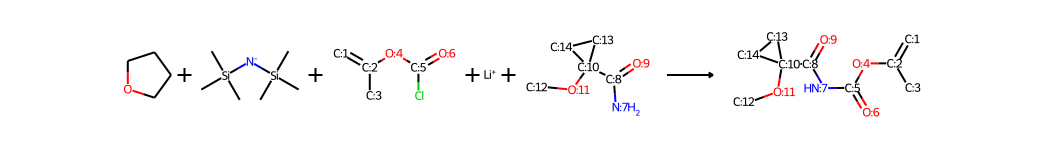

In [39]:
#observe the kind of reactions we have in the most present template(delete in last cleaning)
i = 5
match = uspto_temp_df_oh_to_ket['template_hash'].value_counts().index.tolist()[1]
AllChem.ReactionFromSmarts(uspto_temp_df_oh_to_ket[uspto_temp_df_oh_to_ket['template_hash']==match]['MAPPED_SMILES'].iloc[i], useSmiles=True)

### 4.x.3 Reductive amination

In [3]:
#load uspto with templates dataset
uspto_temp_df = pd.read_pickle('/home/yves/Documents/GitHub/CASP-and-dataset-performance/results/amol_USPTO_templates_set_r0_v2_formatted.pkl')

In [38]:
#test [#6][CX3:1](=[O])[#6]>>[#6][CX3:1](-[NX3])[#6] (1) --> 0 match
#[#6][CX3](=[O])[#6]>>[#6][CX3](-[NX3])[#6]          (2) --> 0 match
#[#6][CX3](=[O])[#6]>>                               (3) --> 152214 match
#   >>[#6][CX3](-[NX3])[#6]                          (4) --> 0 match
#   >>[#6][C](-[N])[#6]                              (5) --> 272695 match
# [#6][CX3:1](=[O])[#6]>>[#6][C:1](-[N])[#6]         (6) --> 28986 match

red_amin_rxn_patt = AllChem.ReactionFromSmarts('[#6][CX3:1](=[O])[#6]>>[#6][C:1](-[N])[#6]')

In [ ]:
uspto_rxns = [AllChem.ReactionFromSmarts(uspto_temp_df.at[i, 'MAPPED_SMILES'], useSmiles=True) for i in range(len(uspto_temp_df))]

#if the reactions are not sanitized, they will not work in the HasReactionSubstructMatch function
for i in range(len(uspto_rxns)):
    AllChem.SanitizeRxn(uspto_rxns[i])

In [39]:
indices = []
for i in tqdm(range(len(uspto_rxns))):
    try:
        if AllChem.HasReactionSubstructMatch(uspto_rxns[i], red_amin_rxn_patt):
            indices.append(i)
    except:
        print(i)
        continue

  0%|          | 0/1189636 [00:00<?, ?it/s]

100%|██████████| 1189636/1189636 [00:05<00:00, 202146.75it/s]


In [41]:
uspto_temp_df_oh_to_ket = uspto_temp_df.loc[indices]

In [42]:
uspto_temp_df_oh_to_ket['template_hash'].value_counts()

257695620b51d5d5ae1a3d66359b6e5442388ac47e8edd50c336b736    5447
46c5bf4df09441d4931d8afec7832e2172f32d481ef7ed4f6564aaf3    1102
52de8e5e1533059d0e45171d7c0ae2b47397adf43b76ca5f3cf8dfed    1059
f1a50309dc25b25b97cd34f22b9e0e615db1f43409ced22190fba0e1     838
2eee74486c3a77cf339a86b2ecfc6026e7be4d1659746e52448c42e6     723
                                                            ... 
3406810003de7d7385bd1da307e676bc1ca45fba4b123b6645e11353       1
27cf3523bb03b51e83d6fbdb289d94472089b0a4332703afbdf667c7       1
82dbb7657130715a4daf1b913970561dc8715c34671570310d4c8501       1
e39b03eeaff5f00eaac0d184d5659e5af64663268de0fb3ed53038c1       1
10508bce0aa22498736a9134f9e36ba84cd4235aa2f1047584dc0662       1
Name: template_hash, Length: 5819, dtype: int64

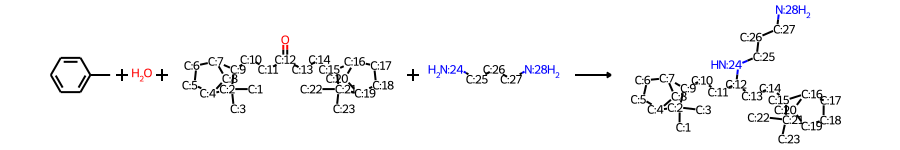

In [47]:
#observe the kind of reactions we have in the most present template(delete in last cleaning)
i = 4
match = uspto_temp_df_oh_to_ket['template_hash'].value_counts().index.tolist()[0]
AllChem.ReactionFromSmarts(uspto_temp_df_oh_to_ket[uspto_temp_df_oh_to_ket['template_hash']==match]['MAPPED_SMILES'].iloc[i], useSmiles=True)
#It matches the reductive amination reactivity !!

In [49]:
#let's see if looking for the same template hash in the original dataframe we can find reactions that we missed earlier
match = uspto_temp_df_oh_to_ket['template_hash'].value_counts().index.tolist()[0]
ind_temphash = uspto_temp_df[uspto_temp_df['template_hash']==match].index.tolist()
ind_rxnmatch = uspto_temp_df_oh_to_ket[uspto_temp_df_oh_to_ket['template_hash']==match].index.tolist()

In [50]:
#investigate corresponding template hashes that did not match the reaction pattern (1)
len(ind_temphash), len(ind_rxnmatch)

(22604, 5447)

In [51]:
#investigate corresponding template hashes that did not match the reaction pattern (2)
set_rxnmatch = set(ind_rxnmatch)
indices_not_in_rxnmatch = [value for index, value in enumerate(ind_temphash) if value not in set_rxnmatch]

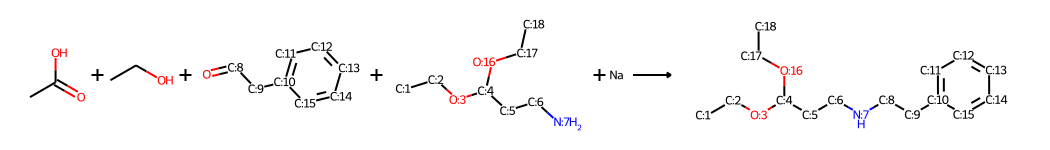

In [53]:
#investigate corresponding template hashes that did not match the reaction pattern (3)
i = 0
AllChem.ReactionFromSmarts(uspto_temp_df.iloc[indices_not_in_rxnmatch]['MAPPED_SMILES'].iloc[i], useSmiles=True)

In [54]:
#determine all the templates for the template hash to determine which one to use

match = uspto_temp_df_oh_to_ket['template_hash'].value_counts().index.tolist()[0]
uspto_temp_df[uspto_temp_df['template_hash']==match]['retro_template'].value_counts()

([CH2;D2;+0:1]-[NH;D2;+0:2])>>(O=[CH;D2;+0:1]).([NH2;D1;+0:2])      7850
([CH2;D2;+0:1]-[N;H0;D3;+0:2])>>(O=[CH;D2;+0:1]).([NH;D2;+0:2])     7067
([CH;D3;+0:1]-[NH;D2;+0:2])>>(O=[C;H0;D3;+0:1]).([NH2;D1;+0:2])     3108
([CH3;D1;+0:1]-[N;H0;D3;+0:2])>>(O=[CH2;D1;+0:1]).([NH;D2;+0:2])    2007
([CH;D3;+0:1]-[N;H0;D3;+0:2])>>(O=[C;H0;D3;+0:1]).([NH;D2;+0:2])    1836
([CH;D3;+0:1]-[NH2;D1;+0:2])>>(O=[C;H0;D3;+0:1]).([NH4+;D0:2])       368
([CH3;D1;+0:1]-[NH;D2;+0:2])>>(O=[CH2;D1;+0:1]).([NH2;D1;+0:2])      167
([CH;D3;+0:1]-[NH2;D1;+0:2])>>(O=[C;H0;D3;+0:1]).([NH3;D0;+0:2])      82
([CH2;D2;+0:1]-[NH;D2;+0:2])>>(O=[CH;D2;+0:1]).([NH3+;D1:2])          35
([CH2;D2;+0:1]-[NH2;D1;+0:2])>>(O=[CH;D2;+0:1]).([NH3;D0;+0:2])       33
([CH2;D2;+0:1]-[NH2;D1;+0:2])>>(O=[CH;D2;+0:1]).([NH4+;D0:2])         17
([CH2;D2;+0:1]-[N;H0;D3;+0:2])>>(O=[CH;D2;+0:1]).([NH2+;D2:2])        16
([CH3;D1;+0:1]-[N;H0;D2;+0:2])>>(O=[CH2;D1;+0:1]).([NH;D1;+0:2])       7
([CH;D3;+0:1]-[NH;D2;+0:2])>>(O=[C;H0;D3;+0:1]).([N

### 4.x.3 (2) Prepare config file for enrichment of reductive amination reaction

In [61]:
#Prepare config file for dataset (whose templates were extracted in 4.1.2) equilibration of first retro_reac and retro_template (TEST)
dataset_name       = 'GDB13S_rand'
retro_reac         = bw.rxn_smarts_to_sanitized_reactant_smarts('([CH2;D2;+0:1]-[NH;D2;+0:2])>>(O=[CH;D2;+0:1]).([NH2;D1;+0:2])') 
retro_template     = '([CH2;D2;+0:1]-[NH;D2;+0:2])>>(O=[CH;D2;+0:1]).([NH2;D1;+0:2])'
path_to_folder     = '/home/yves/Documents/GitHub/test_folder/'
path_models        = '/home/yves/Documents/GitHub/TTL_versions/1.4/models/'
template_frequency = 5000 #added arbitrarily to create 5000 reactions
frequency_target   = 10000

config_file_full = f'{path_to_folder}config_files/config_ubelix_full_{retro_reac}.yaml'.replace(';','')

with open(f'{config_file_full}', 'w') as f:
    f.write(f'dataset_name: "{dataset_name}"\n')
    f.write(f'retro_reac: "{retro_reac}"\n')
    f.write(f'retro_template: "{retro_template}"\n')
    f.write(f'path_to_folder: "{path_to_folder}"\n')
    f.write(f'path_models: "{path_models}"\n')
    f.write(f'template_frequency: {template_frequency}\n')
    f.write(f'frequency_target: {frequency_target}')

### 4.x.3 (3) Inspecting created reactions

In [4]:
with open('/home/yves/Documents/GitHub/test_folder/results/saved_rxns/GDB13S_rand/full_rxns_[CH2;D2;+0:1]-[NH;D2;+0:2]_([CH2;D2;+0:1]-[NH;D2;+0:2])>>(O=[CH;D2;+0:1]).([NH2;D1;+0:2]).txt', 'r') as f:
    created_rxns = []
    for line in f:
        created_rxns.append(line.split('\n')[0])
 

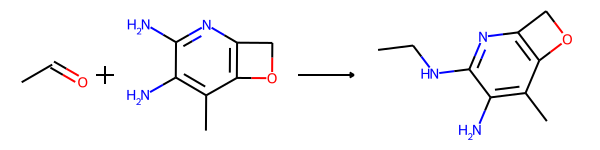

In [12]:
i = 3
AllChem.ReactionFromSmarts(created_rxns[i], useSmiles = True)

### 4.x.3 (4) Preparing data for tmap

In [168]:
#load 5000 created reactions

#adapt path------------------------------
path_created_reactions_GDB = '/home/yves/Documents/GitHub/test_folder/results/saved_rxns/GDB13S_rand/full_rxns_[CH2;D2;+0:1]-[NH;D2;+0:2]_([CH2;D2;+0:1]-[NH;D2;+0:2])>>(O=[CH;D2;+0:1]).([NH2;D1;+0:2]).txt'

with open(path_created_reactions_GDB, 'r') as f:
    created_rxns_GDB = []
    for line in f:
        created_rxns_GDB.append(line.split('\n')[0])

#adapt path------------------------------
path_created_reactions_USPTO = '/home/yves/Documents/GitHub/test_folder/results/saved_rxns/USPTO/full_rxns_[CH2;D2;+0:1]-[NH;D2;+0:2]_([CH2;D2;+0:1]-[NH;D2;+0:2])>>(O=[CH;D2;+0:1]).([NH2;D1;+0:2]).txt'

with open(path_created_reactions_USPTO, 'r') as f:
    created_rxns_USPTO = []
    for line in f:
        created_rxns_USPTO.append(line.split('\n')[0])
        
uspto_temp_df = pd.read_pickle('/home/yves/Documents/GitHub/CASP-and-dataset-performance/results/amol_USPTO_templates_set_r0_v2_formatted.pkl')


In [169]:
original_rxns = uspto_temp_df[uspto_temp_df['retro_template'] == '([CH2;D2;+0:1]-[NH;D2;+0:2])>>(O=[CH;D2;+0:1]).([NH2;D1;+0:2])']['UNMAPPED_SMILES'].tolist()

random.seed(42)
random.shuffle(original_rxns)
original_rxns = original_rxns[:5000]
total_rxns = created_rxns_GDB13S + created_rxns_USPTO + original_rxns
labels = [0]*5000 + [1]*5000 + [2]*5000


In [170]:
#load uspto with templates dataset
rxnstmap = pd.DataFrame()
rxnstmap['rxn_smiles'] = total_rxns
rxnstmap['is_original_rxn'] = labels
rxnstmap.to_csv('/home/yves/Documents/GitHub/test_folder/dataframes/rxnstmap_red_amin.csv')

# 5. Debug 

In [173]:
#delete
temps = uspto_temp_df['retro_template'].values.tolist()

In [174]:
#delete
chars = '/'

In [175]:
#delete
selected_types = [t for t in temps if all(char in t for char in chars)]

In [177]:
#delete
selected_types[0]

'([CH;D2;+0:2]=[C;H0;D3;+0:1]/[NH;D2;+0:3])>>(O=[C;H0;D3;+0:1]-[CH2;D2;+0:2]).([NH2;D1;+0:3])'

In [178]:
#delete
uspto_temp_df[uspto_temp_df['retro_template']==selected_types[0]]

,reaction_hash,reactants,products,classification,retro_template,template_hash,selectivity,outcomes,Set,MAPPED_SMILES,UNMAPPED_SMILES
37,657c5c6dc3eb72f30049f3881a6bfda818fbab64dc227f...,Cc1ccc(S(=O)(=O)O)cc1.O=[C:2]([CH3:1])[CH2:3][...,[CH3:1]/[C:2](=[CH:3]\[C:4](=[O:5])[O:6][CH2:7...,NaN,([CH;D2;+0:2]=[C;H0;D3;+0:1]/[NH;D2;+0:3])>>(O...,f60ba98fd70bea039267fc11550f5a872f7120763c2e07...,1.0,1.0,TRAIN,Cc1ccc(S(=O)(=O)O)cc1.O=[C:2]([CH3:1])[CH2:3][...,CC(=O)CC(=O)OCc1ccccc1.CC(C)(C)OC(=O)NCc1ccc(N...
47145,181fb76bddac50d56c0141ba1f49dad35f077fe8214a15...,O=[C:4]([CH2:3][CH2:2][CH3:1])[CH2:5][C:6](=[O...,[CH3:1][CH2:2][CH2:3]/[C:4](=[CH:5]\[C:6](=[O:...,NaN,([CH;D2;+0:2]=[C;H0;D3;+0:1]/[NH;D2;+0:3])>>(O...,f60ba98fd70bea039267fc11550f5a872f7120763c2e07...,1.0,1.0,TEST,O=[C:4]([CH2:3][CH2:2][CH3:1])[CH2:5][C:6](=[O...,CCCC(=O)CC(=O)OCC.N#Cc1ccc(N)cc1>>CCC/C(=C\C(=...
69712,4c78010e1386fd9717a0d427118971b53534bfe81967a6...,CC(=O)O.O=[C:2]([CH3:1])[CH2:3][C:4](=[O:5])[O...,[CH3:1]/[C:2](=[CH:3]\[C:4](=[O:5])[O:6][C:7](...,NaN,([CH;D2;+0:2]=[C;H0;D3;+0:1]/[NH;D2;+0:3])>>(O...,f60ba98fd70bea039267fc11550f5a872f7120763c2e07...,1.0,1.0,TRAIN,CC(=O)O.O=[C:2]([CH3:1])[CH2:3][C:4](=[O:5])[O...,CC(=O)CC(=O)OC(C)(C)C.CC(=O)O.Nc1cccc2cnc(Cl)c...
115754,b3a7c42b705a1d304ac5bf6629be857199e1f4c4565c4a...,Cc1ccc(S(=O)(=O)O)cc1.O=[C:4]([CH2:3][CH2:2][C...,[CH3:1][CH2:2][CH2:3]/[C:4](=[CH:5]\[C:6](=[O:...,NaN,([CH;D2;+0:2]=[C;H0;D3;+0:1]/[NH;D2;+0:3])>>(O...,f60ba98fd70bea039267fc11550f5a872f7120763c2e07...,1.0,1.0,TRAIN,Cc1ccc(S(=O)(=O)O)cc1.O=[C:4]([CH2:3][CH2:2][C...,CCCC(=O)CC(=O)OCC.Cc1ccc(S(=O)(=O)O)cc1.Nc1ccc...
152407,6bce79046fbbd6d5957d0fd282e7930cca20bb730123d5...,CC(=O)O.Cc1ccccc1.O=[C:7]([CH2:6][C:4]([O:3][C...,[CH3:1][CH2:2][O:3][C:4](=[O:5])/[CH:6]=[C:7](...,NaN,([CH;D2;+0:2]=[C;H0;D3;+0:1]/[NH;D2;+0:3])>>(O...,f60ba98fd70bea039267fc11550f5a872f7120763c2e07...,1.0,1.0,TRAIN,CC(=O)O.Cc1ccccc1.O=[C:7]([CH2:6][C:4]([O:3][C...,CC(=O)O.CCOC(=O)CC(C)=O.Cc1ccccc1.Nc1cc(F)ccc1...
399080,d836b18a487a91f6ca27729367d627e8cf379d4b6cc5a8...,CC(=O)O.Cc1ccccc1.O=[C:7]([CH2:6][C:4]([O:3][C...,[CH3:1][CH2:2][O:3][C:4](=[O:5])/[CH:6]=[C:7](...,NaN,([CH;D2;+0:2]=[C;H0;D3;+0:1]/[NH;D2;+0:3])>>(O...,f60ba98fd70bea039267fc11550f5a872f7120763c2e07...,1.0,1.0,TRAIN,CC(=O)O.Cc1ccccc1.O=[C:7]([CH2:6][C:4]([O:3][C...,CC(=O)O.CCOC(=O)CC(C)=O.Cc1ccccc1.Nc1cccc(C(F)...
834652,12cccab1db89cc98cdc0711b0dc7dd3429b58a9497fb9e...,Cc1ccc(S(=O)(=O)O)cc1.Cc1ccccc1.O=C([O-])O.O=[...,[CH3:1][CH2:2][O:3][C:4](=[O:5])/[CH:6]=[C:7](...,NaN,([CH;D2;+0:2]=[C;H0;D3;+0:1]/[NH;D2;+0:3])>>(O...,f60ba98fd70bea039267fc11550f5a872f7120763c2e07...,1.0,1.0,TRAIN,Cc1ccc(S(=O)(=O)O)cc1.Cc1ccccc1.O=C([O-])O.O=[...,CCOC(=O)CC(C)=O.Cc1ccc(S(=O)(=O)O)cc1.Cc1ccccc...
897543,9e6f0ec41e8b633765e0d4bda44fbc987b57c42aeb4336...,CC(C)=O.Cc1ccccc1.ClCCl.O=[C:7]([CH2:6][C:4]([...,[CH3:1][CH2:2][O:3][C:4](=[O:5])/[CH:6]=[C:7](...,NaN,([CH;D2;+0:2]=[C;H0;D3;+0:1]/[NH;D2;+0:3])>>(O...,f60ba98fd70bea039267fc11550f5a872f7120763c2e07...,1.0,1.0,TRAIN,CC(C)=O.Cc1ccccc1.ClCCl.O=[C:7]([CH2:6][C:4]([...,CC(C)=O.CCOC(=O)CC(C)=O.COc1cccc2c1C(=O)c1c(O)...
1061103,85470c6d304f029518ab44e4345dae3a76cc4a05620868...,Cc1ccc(S(=O)(=O)O)cc1.O=[C:2]([CH3:1])[CH2:3][...,[CH3:1]/[C:2](=[CH:3]\[C:4](=[O:5])[O:6][CH2:7...,NaN,([CH;D2;+0:2]=[C;H0;D3;+0:1]/[NH;D2;+0:3])>>(O...,f60ba98fd70bea039267fc11550f5a872f7120763c2e07...,1.0,1.0,TRAIN,Cc1ccc(S(=O)(=O)O)cc1.O=[C:2]([CH3:1])[CH2:3][...,CC(=O)CC(=O)OCc1ccccc1.Cc1ccc(S(=O)(=O)O)cc1.N...


In [179]:
uspto_temp_df

,reaction_hash,reactants,products,classification,retro_template,template_hash,selectivity,outcomes,Set,MAPPED_SMILES,UNMAPPED_SMILES
0,e5660e6f195dc228acc0f1d98bd8abccb52d3511c6d78c...,CCOC(=O)[NH:1][CH:2]1[CH2:3][CH2:4][N:5]([c:6]...,[NH2:1][CH:2]1[CH2:3][CH2:4][N:5]([c:6]2[cH:7]...,NaN,([NH2;D1;+0:1])>>(C-C-O-C(=O)-[NH;D2;+0:1]),4bbcd16063192bad75d5aefffb84c58c3c67f175d81546...,1.000000,1.0,TRAIN,CCOC(=O)[NH:1][CH:2]1[CH2:3][CH2:4][N:5]([c:6]...,CCOC(=O)NC1CCN(c2ccc(Cl)nn2)CC1.Cl>>NC1CCN(c2c...
1,c046aafc3f4e93b66a1ab6d92de3bf9264124dcdf4b611...,ClCCl.[CH3:1][CH2:2][C@@H:3]([NH:4][c:5]1[cH:6...,[CH3:1][CH2:2][C@@H:3]([NH:4][c:5]1[cH:6][cH:7...,NaN,([C;H0;D3;+0:1]=[O;H0;D1;+0:2])>>([CH;D3;+0:1]...,d572f15ce843682d57bd39cd6c8575947b70a50f4c6527...,1.000000,1.0,TRAIN,ClCCl.[CH3:1][CH2:2][C@@H:3]([NH:4][c:5]1[cH:6...,CC[C@@H](Nc1cccc(C(C)O)c1)c1ccc(Cl)c(C)c1.ClCC...
2,7000bdcc832d12217e3b90b90107609ef0b841a84cbb1f...,CCCC(C)C(=O)C(=O)C(C)(C)C.CCOC(C)=O.CN1CCCC1=O...,[Cl:1][c:2]1[cH:3][cH:4][cH:5][cH:6][c:7]1[S:8...,NaN,([S;H0;D2;+0:2]-[c;H0;D3;+0:1])>>(I-[c;H0;D3;+...,447e61623ec195f5e49766b1eb5e80e8c626ef08b01cf1...,0.500000,2.0,TRAIN,CCCC(C)C(=O)C(=O)C(C)(C)C.CCOC(C)=O.CN1CCCC1=O...,CCCC(C)C(=O)C(=O)C(C)(C)C.CCOC(C)=O.CN1CCCC1=O...
3,564da4cdbeeff04368b1f305d977fc9ffaecbb6e29744d...,Br[CH2:11][CH2:10][CH2:9][CH2:8][O:7][c:6]1[cH...,[O:1]=[c:2]1[nH:3][c:4]2[cH:5][c:6]([O:7][CH2:...,NaN,([CH2;D2;+0:1]-[N;H0;D3;+0:2])>>(Br-[CH2;D2;+0...,48f112f542979a51e8ad5b51eceb82f0e3283be74d6c23...,0.333333,3.0,TRAIN,Br[CH2:11][CH2:10][CH2:9][CH2:8][O:7][c:6]1[cH...,Cl.Clc1cccc(N2CCN(CCCCCOc3cc4ccccc4cn3)CC2)c1....
4,be00ca6cedffd0e4bcd57983270c739f81ad94b5a3fd87...,CC#N.COC(OC)N(C)C.Cc1cccc(C)c1NC(=O)NC(=N)NCC(...,[CH3:1][c:2]1[cH:3][cH:4][cH:5][c:6]([CH3:7])[...,NaN,([c;H0;D3;+0:1]-[n;H0;D3;+0:2]1:[c;H0;D3;+0:3]...,1c225eaec03444a3732903befacae3c7539385167e0009...,1.000000,1.0,TRAIN,CC#N.COC(OC)N(C)C.Cc1cccc(C)c1NC(=O)NC(=N)NCC(...,CC#N.COC(OC)N(C)C.Cc1cccc(C)c1N1C=NC(NCC(F)(F)...
...,...,...,...,...,...,...,...,...,...,...,...
1189631,9a76fcc306601390293dd009f6908181bc84b27f987186...,CC(C)O[B:9]1[O:10][C:11]([CH3:12])([CH3:13])[C...,[CH3:1][O:2][c:3]1[n:4][cH:5][cH:6][c:7]2[c:8]...,NaN,([B;H0;D3;+0:1]-[c;H0;D3;+0:2])>>(C-C(-C)-O-[B...,726731c0333e36dcaaada039eb9e39a42c9f4e8588e95e...,1.000000,1.0,TRAIN,CC(C)O[B:9]1[O:10][C:11]([CH3:12])([CH3:13])[C...,CC(C)OB1OC(C)(C)C(C)(C)O1.COc1nccc2c(I)cn(C)c1...
1189632,f6011ea3cbc02f346b2cc038e4151417eeeed6a3a2ab50...,Cl[c:20]1[n:19][c:8]([NH:9][CH2:10][c:11]2[cH:...,[F:1][C:2]([F:3])([F:4])[c:5]1[cH:6][c:7]2[c:8...,NaN,([c;H0;D3;+0:1]-[n;H0;D3;+0:2])>>(Cl-[c;H0;D3;...,194612270a3b0120d8e18ef6d4e757c90f7b4d97dd9c9b...,1.000000,1.0,TRAIN,Cl[c:20]1[n:19][c:8]([NH:9][CH2:10][c:11]2[cH:...,FC(F)(F)c1cc2c(NCc3ccc(Cl)c(Cl)c3)nc(Cl)nc2s1....
1189633,d461795d12050560636f726f4b44816d387c0e25606c1d...,I[c:13]1[cH:12][cH:11][c:10]([O:9][C@@H:8]2[S:...,[CH3:1][C:2](=[O:3])[O:4][C@@H:5]1[CH2:6][S:7]...,NaN,([C@@H;D3;+0:5]-[C@H;D3;+0:4]-[C@@H;D3;+0:3]-[...,09125b79d85286e5ab889090b706042a314e5cbc927dc1...,0.500000,2.0,TRAIN,I[c:13]1[cH:12][cH:11][c:10]([O:9][C@@H:8]2[S:...,CC(=O)O[C@@H]1CS[C@@H](Oc2ccc(I)nc2Cl)[C@H](OC...
1189634,b4bc10629a19cedf9b353425dd938d4d50a87f9d81dd3c...,C1CCOC1.CO.C[O:3][C:2](=[O:1])[CH2:4][N:5]1[CH...,[O:1]=[C:2]([OH:3])[CH2:4][N:5]1[CH2:6][CH2:7]...,NaN,([OH;D1;+0:1])>>(C-[O;H0;D2;+0:1]),e47a6bcf7282afc3a6a39e4104b8a0774e04e27fb968a8...,1.000000,1.0,TRAIN,C1CCOC1.CO.C[O:3][C:2](=[O:1])[CH2:4][N:5]1[CH...,C1CCOC1.CO.COC(=O)CN1CCN(C(c2ccc(Cl)cc2)c2ccc(...


In [180]:
with open('/home/yves/Documents/GitHub/test_folder/config_files/config_ubelix_full_[CH;D2;+0:2]=[C;H0;D3;+0:1]slash[NH;D2;+0:3].yaml', 'r') as file:
    test = yaml.safe_load(file)

In [181]:
test

{'dataset_name': 'USPTO',
 'retro_reac': '[CH;D2;+0:2]=[C;H0;D3;+0:1]/[NH;D2;+0:3]',
 'retro_template': '([CH;D2;+0:2]=[C;H0;D3;+0:1]/[NH;D2;+0:3])>>(O=[C;H0;D3;+0:1]-[CH2;D2;+0:2]).([NH2;D1;+0:3])',
 'path_to_folder': '/storage/homefs/yg23u489/test_folder/',
 'path_models': '/storage/homefs/yg23u489/TTL_versions/1.4/models/',
 'template_frequency': 0,
 'frequency_target': 20}

## 5.1 debug slurm-1403556.out

In [ ]:
#In iteration 5 
#Traceback (most recent call last):
#  File "/storage/homefs/yg23u489/.conda/envs/uspto_balance/bin/balance", line 8, in <module>
#    sys.exit(main_balance())
#  File "/storage/homefs/yg23u489/USPTO_balance/src/uspto_balance/dataset_equilibration.py", line 203, in main_balance
#    main(
#  File "/storage/homefs/yg23u489/USPTO_balance/src/uspto_balance/dataset_equilibration.py", line 181, in main
#    extract_subset_from_dataset(dataset_name, counter, retro_reac, retro_template, path_to_folder)
#  File "/storage/homefs/yg23u489/USPTO_balance/src/uspto_balance/dataset_equilibration.py", line 57, in extract_subset_from_dataset
#    c_part1_framework(          
#  File "/storage/homefs/yg23u489/USPTO_balance/src/uspto_balance/C_part1_framework.py", line 133, in main
#    dataset_sub, dataset_sub_mol = extract_match_smiles_from_dataset(dataset, dataset_mol, retro_reac)
#  File "/storage/homefs/yg23u489/USPTO_balance/src/uspto_balance/C_part1_framework.py", line 91, in extract_match_smiles_from_dataset
#    match_ind = [i for i, mol in enumerate(dataset_mol) if mol.HasSubstructMatch(template_mol)]
#  File "/storage/homefs/yg23u489/USPTO_balance/src/uspto_balance/C_part1_framework.py", line 91, in <listcomp>
#    match_ind = [i for i, mol in enumerate(dataset_mol) if mol.HasSubstructMatch(template_mol)]
#AttributeError: 'NoneType' object has no attribute 'HasSubstructMatch'

In [ ]:
#dataset_equilibration.py: main_balance() -> main() -> extract_subset_from_dataset()
#C_part1_framework.py: main() -> extract_match_smiles_from_dataset() -> match_ind 

In [120]:
#reproduce the inputs that the function receives and try reproducing the error
path_to_folder = '/home/yves/Documents/GitHub/test_folder/'
dataset_name = 'USPTO'
dataset_version = '6'
dataset_path               = f"{path_to_folder}data/{dataset_name}_{dataset_version}.txt"
template = '[CH;D2;+0:1]=[O;H0;D1;+0:2]'
with open(dataset_path, 'r') as f:
    dataset = [line.strip() for line in f]

In [118]:
def smiles_to_mol(smi):
    '''
    Converts a smile string into a rdkit mol file
    '''
    mol = Chem.MolFromSmiles(smi)
    return mol

# Convert SMILES to RDKit mol objects
processes = os.cpu_count() - 2
with Pool(processes) as p:
    output = list(tqdm(p.imap(smiles_to_mol, dataset), total=len(dataset)))
dataset_mol = output

#convert template to mol
template_mol    = Chem.MolFromSmarts(template)

100%|██████████| 15059/15059 [00:01<00:00, 8068.03it/s]


In [121]:
#find indices in the dataset of the substructure matches
match_ind = [i for i, mol in enumerate(dataset_mol) if mol.HasSubstructMatch(template_mol)]

AttributeError: 'NoneType' object has no attribute 'HasSubstructMatch'

In [124]:
for i, mol in enumerate(dataset_mol):
    try:
        mol.HasSubstructMatch(template_mol)
    except:
        print(i)

101


In [132]:
dataset_mol[101]

In [133]:
dataset[101]

'*)'

In [140]:
dftest = pd.DataFrame(data=dataset, columns=['smiles'])

Some weights of the model checkpoint at /home/yves/anaconda3/envs/uspto_balance/lib/python3.8/site-packages/rxnmapper/models/transformers/albert_heads_8_uspto_all_1310k were not used when initializing AlbertModel: ['predictions.decoder.weight', 'predictions.LayerNorm.bias', 'predictions.decoder.bias', 'predictions.dense.weight', 'predictions.dense.bias', 'predictions.bias', 'predictions.LayerNorm.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at /home/yves/anaconda3/envs/uspto_balance/lib/python3.8/site-packages/rxnmapper/models/transform

In [142]:
dftest['mol'] = dataset_mol

Some weights of the model checkpoint at /home/yves/anaconda3/envs/uspto_balance/lib/python3.8/site-packages/rxnmapper/models/transformers/albert_heads_8_uspto_all_1310k were not used when initializing AlbertModel: ['predictions.decoder.weight', 'predictions.LayerNorm.bias', 'predictions.decoder.bias', 'predictions.dense.weight', 'predictions.dense.bias', 'predictions.bias', 'predictions.LayerNorm.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at /home/yves/anaconda3/envs/uspto_balance/lib/python3.8/site-packages/rxnmapper/models/transform

In [171]:
dftest = dftest[[not el for el in dftest['mol'].isnull().values]]

## 5.2 debug slurm-1403573.out

In [ ]:
#Iteration 1
#In extract_subset_from_dataset
#
#  0%|          | 0/15059 [00:00<?, ?it/s]
#  0%|          | 4/15059 [00:01<1:40:40,  2.49it/s]
#  9%|▉         | 1395/15059 [00:01<00:12, 1137.66it/s]
# 21%|██        | 3142/15059 [00:01<00:04, 2814.93it/s]
# 35%|███▌      | 5326/15059 [00:01<00:01, 5208.72it/s]
# 49%|████▊     | 7307/15059 [00:02<00:01, 7454.76it/s]
# 61%|██████    | 9116/15059 [00:02<00:00, 9357.60it/s]
# 74%|███████▍  | 11147/15059 [00:02<00:00, 11592.12it/s]
# 87%|████████▋ | 13079/15059 [00:02<00:00, 13321.18it/s]
#100%|██████████| 15059/15059 [00:02<00:00, 6243.57it/s] 
#Token indices sequence length is longer than the specified maximum sequence length for this model (574 > 512). Running this sequence through the model will result in indexing errors
#[2023-11-23 12:36:48,179 WARNING] Error while mapping chunk of 10 reactions: The size of tensor a (574) must match the size of tensor b (512) at non-singleton dimension 1. Mapping them individually.
#[2023-11-23 12:36:49,284 INFO] Reaction causing the error: CCCC[C@H](NC(=O)[C@@H]1CCCN1C(=O)C=O)C(=O)N[C@@H](CSCC(=O)CSC[C@H](NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(=N)N)NC(=O)[C@@H]1CCC(=O)N1)C(=O)N[C@@H](Cc1cnc[nH]1)C(=O)N[C@H](C=O)CCCCN)C(=O)N[C@@H](Cc1ccccc1)C(=O)O.CCCC[C@H](NC(=O)[C@@H]1CCCN1C=O)C(=O)N[C@@H](CSCC(=O)CSC[C@H](NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(=N)N)NC(=O)[C@@H]1CCC(=O)N1)C(=O)N[C@@H](Cc1cnc[nH]1)C(=O)N[C@@H](CCCCN)C(N)=O)C(=O)N[C@@H](Cc1ccccc1)C(=O)O>>CCCC[C@@H]1NC(=O)[C@@H]2CCCN2C(=O)CNC(=O)[C@H](CCCCN)NC(=O)[C@H](Cc2cnc[nH]2)NC(=O)[C@@H](NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@@H]2CCCN2C(=O)[C@H](CCCNC(=N)N)NC(=O)[C@@H]2CCC(=O)N2)CSCC(=O)CSC[C@@H](C(=O)N[C@@H](Cc2ccccc2)C(=O)O)NC1=O; RuntimeError: The size of tensor a (574) must match the size of tensor b (512) at non-singleton dimension 1
#[2023-11-23 12:38:10,900 WARNING] Error while mapping chunk of 10 reactions: "" is not a valid SMILES string. Mapping them individually.
#[2023-11-23 12:38:11,629 INFO] Reaction causing the error: >>CCOC(=O)c1cn2c3c(c(F)c(Cl)cc3c1=O)CCN2; InvalidSmiles: "" is not a valid SMILES string
#Saved subset of 2204 smiles from USPTO_2 for retro_reac: [CH2;D2;+0:1]-[NH;D2;+0:2]
#In create_reactions_using_template
#Created 2645 reactions for retro_reac: [CH2;D2;+0:1]-[NH;D2;+0:2] and retro_template: ([CH2;D2;+0:1]-[NH;D2;+0:2])>>(O=[CH;D2;+0:1]).([NH2;D1;+0:2])
#In validate_created_reactions
#Traceback (most recent call last):
#  File "/storage/homefs/yg23u489/.conda/envs/uspto_balance/bin/balance", line 8, in <module>
#    sys.exit(main_balance())
#  File "/storage/homefs/yg23u489/USPTO_balance/src/uspto_balance/dataset_equilibration.py", line 203, in main_balance
#    main(
#  File "/storage/homefs/yg23u489/USPTO_balance/src/uspto_balance/dataset_equilibration.py", line 183, in main
#    validate_created_reactions(dataset_name, counter, retro_reac, retro_template, path_to_folder, path_models)
#  File "/storage/homefs/yg23u489/USPTO_balance/src/uspto_balance/dataset_equilibration.py", line 119, in validate_created_reactions
#    e_part3_framework(
#  File "/storage/homefs/yg23u489/USPTO_balance/src/uspto_balance/E_part3_framework.py", line 155, in main
#    reactions_conf_validation(dataset_name, dataset_version, template_version, retro_reac, retro_template, Model_path_T2, Model_path_T3)
#  File "/storage/homefs/yg23u489/USPTO_balance/src/uspto_balance/E_part3_framework.py", line 145, in reactions_conf_validation
#    rxns_T2_to_T3_tok = prepare_rxns_T2_for_T3(rxns_list, preds_T2)
#  File "/storage/homefs/yg23u489/USPTO_balance/src/uspto_balance/E_part3_framework.py", line 61, in prepare_rxns_T2_for_T3
#    taggedreactants = [singlestepretrosynthesis.rxn_mark_center.TagMappedReactionCenter(MappedReactions[i], alternative_marking = True, tag_reactants = True).split('>>')[0] for i in range(len(MappedReactions))]
#  File "/storage/homefs/yg23u489/USPTO_balance/src/uspto_balance/E_part3_framework.py", line 61, in <listcomp>
#    taggedreactants = [singlestepretrosynthesis.rxn_mark_center.TagMappedReactionCenter(MappedReactions[i], alternative_marking = True, tag_reactants = True).split('>>')[0] for i in range(len(MappedReactions))]
#  File "/storage/homefs/yg23u489/.conda/envs/uspto_balance/lib/python3.8/site-packages/ttlretro/rxnmarkcenter/mark_reaction_center.py", line 326, in TagMappedReactionCenter
#    for index in self.ListMapNum(products[0]):
#IndexError: Index out of range

In [ ]:
#Reaction causing the error: 
#CCCC[C@H](NC(=O)[C@@H]1CCCN1C(=O)C=O)C(=O)N[C@@H](CSCC(=O)CSC[C@H](NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(=N)N)NC(=O)[C@@H]1CCC(=O)N1)C(=O)N[C@@H](Cc1cnc[nH]1)C(=O)N[C@H](C=O)CCCCN)C(=O)N[C@@H](Cc1ccccc1)C(=O)O.CCCC[C@H](NC(=O)[C@@H]1CCCN1C=O)C(=O)N[C@@H](CSCC(=O)CSC[C@H](NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(=N)N)NC(=O)[C@@H]1CCC(=O)N1)C(=O)N[C@@H](Cc1cnc[nH]1)C(=O)N[C@@H](CCCCN)C(N)=O)C(=O)N[C@@H](Cc1ccccc1)C(=O)O
#>>
#CCCC[C@@H]1NC(=O)[C@@H]2CCCN2C(=O)CNC(=O)[C@H](CCCCN)NC(=O)[C@H](Cc2cnc[nH]2)NC(=O)[C@@H](NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@@H]2CCCN2C(=O)[C@H](CCCNC(=N)N)NC(=O)[C@@H]2CCC(=O)N2)CSCC(=O)CSC[C@@H](C(=O)N[C@@H](Cc2ccccc2)C(=O)O)NC1=O

In [173]:
#reproduce the inputs that the function receives and try reproducing the error
path_to_folder = '/home/yves/Documents/GitHub/test_folder/'
dataset_name = 'USPTO'
dataset_version = '2'
dataset_path = f"{path_to_folder}data/{dataset_name}_{dataset_version}.txt"
template = '[CH;D2;+0:1]=[O;H0;D1;+0:2]'
with open(dataset_path, 'r') as f:
    dataset = [line.strip() for line in f]

Some weights of the model checkpoint at /home/yves/anaconda3/envs/uspto_balance/lib/python3.8/site-packages/rxnmapper/models/transformers/albert_heads_8_uspto_all_1310k were not used when initializing AlbertModel: ['predictions.decoder.weight', 'predictions.LayerNorm.bias', 'predictions.decoder.bias', 'predictions.dense.weight', 'predictions.dense.bias', 'predictions.bias', 'predictions.LayerNorm.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at /home/yves/anaconda3/envs/uspto_balance/lib/python3.8/site-packages/rxnmapper/models/transform

In [187]:
i = 7696
len(dataset[i]), Chem.rdMolDescriptors.CalcExactMolWt(Chem.MolFromSmiles(dataset[i]))

(248, 1590.791157439999)

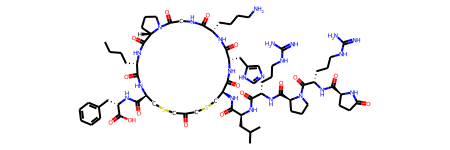

In [189]:
Chem.MolFromSmiles(dataset[i])

To solve the problem, remove molecules that are too big from the list

In [6]:
#transform [A.B>>C, D.E>>F] into [A, B, C, D, E, F]
split_rxns = list(chain.from_iterable(uspto_df['UNMAPPED_SMILES'][el].split('>>') for el in range(len(uspto_df))))
split_rxns2 = list(chain.from_iterable(split_rxns[el].split('.') for el in range(len(split_rxns))))
split_rxns3 = list(set(split_rxns2))

#we win 20% of reactions from the original cleaned uspto template list
len(split_rxns3)/len(uspto_df)

1.1887570713346292

In [273]:
type(split_rxns3)

list

In [12]:
len(split_rxns3)

1505839

In [277]:
del df

In [7]:
#first, create a dataframe
df = pd.DataFrame(data = split_rxns3, columns=['smiles'])

In [10]:
#first, create a dataframe
df = pd.DataFrame(data = split_rxns3, columns=['smiles'])

#calculate the mol for each smiles
df['mol'] = ''
for el in tqdm(range(len(df))):
    try:
        df.at[el, 'mol'] = Chem.MolFromSmiles(df.at[el, 'smiles'])
    except:
        print(el)

#mol that are None should be removed from the dataframe
sum(df['mol'].isnull().values)

#the dataframe is now only composed of valid molecules
df = df[[not el for el in df['mol'].isnull().values]]
df.reset_index(inplace=True, drop=True)

df['heavyatomcount'] = [Chem.rdMolDescriptors.CalcNumHeavyAtoms(df.at[el, 'mol']) for el in tqdm(range(len(df)))]

#save in case we need to load it later again
df.to_pickle('./df_USPTO_smiles_mol_HAC.pkl')

  0%|          | 0/1505839 [00:00<?, ?it/s]

100%|██████████| 1505839/1505839 [02:32<00:00, 9883.78it/s] 


In [14]:
#mol that are None should be removed from the dataframe
sum(df['mol'].isnull().values)

2

In [17]:
#the dataframe is now only composed of valid molecules
df = df[[not el for el in df['mol'].isnull().values]]
df.reset_index(inplace=True, drop=True)

In [22]:
df['heavyatomcount'] = [Chem.rdMolDescriptors.CalcNumHeavyAtoms(df.at[el, 'mol']) for el in tqdm(range(len(df)))]

100%|██████████| 1505837/1505837 [00:08<00:00, 187407.05it/s]
/tmp/ipykernel_443883/3002628948.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['heavyatomcount'] = [Chem.rdMolDescriptors.CalcNumHeavyAtoms(df.at[el, 'mol']) for el in tqdm(range(len(df)))]


In [23]:
#save in case we need to load it later again
df.to_pickle('./df_USPTO_smiles_mol_HAC.pkl')

<Axes: >

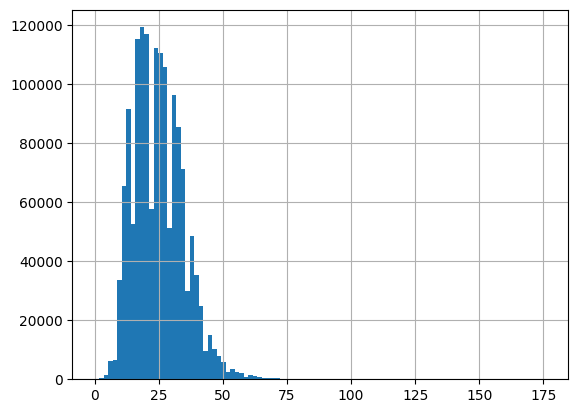

In [25]:
import matplotlib.pyplot
df['heavyatomcount'].hist(bins=100)

In [29]:
df = df[df['heavyatomcount']<79]

## 5.3 Debug slurm-1467158.out

In [ ]:
#Iteration 11
#In extract_subset_from_dataset
#
#  0%|          | 0/15051 [00:00<?, ?it/s]
#  0%|          | 41/15051 [00:00<00:40, 371.39it/s]
#  2%|▏         | 356/15051 [00:00<00:08, 1813.11it/s]
# 21%|██▏       | 3212/15051 [00:00<00:00, 13204.08it/s]
# 34%|███▎      | 5048/15051 [00:00<00:00, 15067.94it/s]
# 46%|████▋     | 6990/15051 [00:00<00:00, 16445.78it/s]
# 59%|█████▊    | 8835/15051 [00:00<00:00, 17074.86it/s]
# 72%|███████▏  | 10807/15051 [00:00<00:00, 17684.66it/s]
# 85%|████████▍ | 12725/15051 [00:00<00:00, 18085.51it/s]
#100%|██████████| 15051/15051 [00:00<00:00, 19674.33it/s]
#100%|██████████| 15051/15051 [00:00<00:00, 16101.58it/s]
#[2023-11-24 10:32:54,120 WARNING] Error while mapping chunk of 10 reactions: "" is not a valid SMILES string. Mapping them individually.
#[2023-11-24 10:32:54,206 INFO] Reaction causing the error: >>; InvalidSmiles: "" is not a valid SMILES string
#Saved subset of 421 smiles from USPTO_12 for retro_reac: [CH;D2;+0:1]=[O;H0;D1;+0:2]
#In create_reactions_using_template
#Created 426 reactions for retro_reac: [CH;D2;+0:1]=[O;H0;D1;+0:2] and retro_template: ([CH;D2;+0:1]=[O;H0;D1;+0:2])>>([CH2;D2;+0:1]-[OH;D1;+0:2])
#In validate_created_reactions
#Traceback (most recent call last):
#  File "/storage/homefs/yg23u489/.conda/envs/uspto_balance/bin/balance", line 8, in <module>
#    sys.exit(main_balance())
#  File "/storage/homefs/yg23u489/USPTO_balance/src/uspto_balance/dataset_equilibration.py", line 203, in main_balance
#    main(
#  File "/storage/homefs/yg23u489/USPTO_balance/src/uspto_balance/dataset_equilibration.py", line 183, in main
#    validate_created_reactions(dataset_name, counter, retro_reac, retro_template, path_to_folder, path_models)
#  File "/storage/homefs/yg23u489/USPTO_balance/src/uspto_balance/dataset_equilibration.py", line 119, in validate_created_reactions
#    e_part3_framework(
#  File "/storage/homefs/yg23u489/USPTO_balance/src/uspto_balance/E_part3_framework.py", line 155, in main
#    reactions_conf_validation(dataset_name, dataset_version, template_version, retro_reac, retro_template, Model_path_T2, Model_path_T3)
#  File "/storage/homefs/yg23u489/USPTO_balance/src/uspto_balance/E_part3_framework.py", line 145, in reactions_conf_validation
#    rxns_T2_to_T3_tok = prepare_rxns_T2_for_T3(rxns_list, preds_T2)
#  File "/storage/homefs/yg23u489/USPTO_balance/src/uspto_balance/E_part3_framework.py", line 61, in prepare_rxns_T2_for_T3
#    taggedreactants = [singlestepretrosynthesis.rxn_mark_center.TagMappedReactionCenter(MappedReactions[i], alternative_marking = True, tag_reactants = True).split('>>')[0] for i in range(len(MappedReactions))]
#  File "/storage/homefs/yg23u489/USPTO_balance/src/uspto_balance/E_part3_framework.py", line 61, in <listcomp>
#    taggedreactants = [singlestepretrosynthesis.rxn_mark_center.TagMappedReactionCenter(MappedReactions[i], alternative_marking = True, tag_reactants = True).split('>>')[0] for i in range(len(MappedReactions))]
#  File "/storage/homefs/yg23u489/.conda/envs/uspto_balance/lib/python3.8/site-packages/ttlretro/rxnmarkcenter/mark_reaction_center.py", line 326, in TagMappedReactionCenter
#    for index in self.ListMapNum(products[0]):
#IndexError: Index out of range

In [16]:
#reproduce the inputs that the function receives and try reproducing the error
path_to_folder = '/home/yves/Documents/GitHub/test_folder/'
dataset_name = 'USPTO'
dataset_version = '12'
dataset_path = f"{path_to_folder}data/{dataset_name}_{dataset_version}.txt"
#template = '[CH;D2;+0:1]=[O;H0;D1;+0:2]'
with open(dataset_path, 'r') as f:
    dataset = [line.strip() for line in f]

In [ ]:
#import subset and created reactions from UBELIX
with open('/home/yves/Documents/GitHub/test_folder/debug/USPTO_sub_12_[CH;D2;+0:1]=[O;H0;D1;+0:2].txt', 'r') as f:
    subset_USPTO12 = [line.strip() for line in f]

with open('/home/yves/Documents/GitHub/test_folder/debug/rxns_12_[CH;D2;+0:1]=[O;H0;D1;+0:2]_([CH;D2;+0:1]=[O;H0;D1;+0:2])>>([CH2;D2;+0:1]-[OH;D1;+0:2]).txt', 'r') as f:
    createdrxns_USPTO12 = [line.strip() for line in f]

In [19]:
#from observing the created reactions, we see that index 352 is '>>'
#try reproducing the process_retro_template function on D_part2_function to see where the inconsistency comes from

#inputs for the function
retro_reac       = '[CH;D2;+0:1]=[O;H0;D1;+0:2]'
retro_template   = '([CH;D2;+0:1]=[O;H0;D1;+0:2])>>([CH2;D2;+0:1]-[OH;D1;+0:2])'
dataset_version  = '12'
template_version = retro_reac
dataset_name     = 'USPTO'

In [25]:
#    dataset_sub, dataset_sub_mol = load_subsets(retro_reac, dataset_version, template_version, dataset_name)
# loads dataset and dataset mol

#manually, it is :
with open('/home/yves/Documents/GitHub/test_folder/debug/USPTO_sub_12_[CH;D2;+0:1]=[O;H0;D1;+0:2].txt', 'r') as f:
    dataset_sub = [line.strip() for line in f]

dataset_sub_mol = pd.read_pickle('/home/yves/Documents/GitHub/test_folder/debug/USPTO_sub_12_[CH;D2;+0:1]=[O;H0;D1;+0:2].pkl')

In [29]:
#    # Apply template
#    dataset_sub_app_temp = apply_rxn_template_on_mols_list(dataset_sub_mol, retro_template)
dataset_sub_app_temp = bw.apply_rxn_template_on_mols_list(dataset_sub_mol, retro_template)

In [31]:
#    # Find indices of empty elements and remove them from both lists
#    ind_remove = [result == () for result in dataset_sub_app_temp]
ind_remove = [result == () for result in dataset_sub_app_temp]

In [34]:
#    dataset_sub_app_temp_sort = [dataset_sub_app_temp[i] for i in range(len(dataset_sub_app_temp)) if not ind_remove[i]]
dataset_sub_app_temp_sort = [dataset_sub_app_temp[i] for i in range(len(dataset_sub_app_temp)) if not ind_remove[i]]

In [38]:
#    dataset_sub_sort = [dataset_sub[i] for i in range(len(dataset_sub)) if not ind_remove[i]]
dataset_sub_sort = [dataset_sub[i] for i in range(len(dataset_sub)) if not ind_remove[i]]

In [42]:
#we find that output at index 347 is '>>', analyze the function format_reaction to see where the error comes from
fictive_rxns_list = [bw.format_reaction(dataset_sub_app_temp_sort[k], dataset_sub_sort[k]) for k in range(len(dataset_sub_sort))]

In [71]:
fictive_rxns_list = list(chain.from_iterable(fictive_rxns_list))

In [73]:
len(fictive_rxns_list)

426

In [74]:
fictive_rxns_list.remove('>>')

In [75]:
len(fictive_rxns_list)

425

analysis of the format_reaction function

In [50]:
k = 347
bw.format_reaction(dataset_sub_app_temp_sort[k], dataset_sub_sort[k])

['>>']

In [51]:
reactants_tuple = dataset_sub_app_temp_sort[k]
reactants_smiles_list = []
for i in range(len(reactants_tuple)):
    reactants_mol = list(reactants_tuple[i])

In [52]:
reactants_mol

In [57]:
reactants_smiles = ''

In [58]:
for j in range(len(reactants_mol)):
    reactants_smiles += Chem.MolToSmiles(reactants_mol[j]) + '.'

In [59]:
reactants_smiles

'OC[c-]1cccc1.'

In [60]:
reactants_smiles = reactants_smiles[:-1]

In [61]:
reactants_smiles

'OC[c-]1cccc1'

In [62]:
reactants_smiles_list.append(reactants_smiles)

In [69]:
reactants_smiles_list

['OC[c-]1cccc1']

In [64]:
reactants_smiles_list = list(set(reactants_smiles_list))

In [65]:
smi = dataset_sub_sort[k]
smi

''

In [66]:
rxn = [bw.canonicalize(reactants_smiles_list[i]) + '>>' + smi for i in range(len(reactants_smiles_list))]

In [67]:
rxn

['>>']

In [46]:
#def format_reaction(reactants_tuple: tuple, smi : str):
#    '''From the runreactants result, returns the reactions in a smiles format'''
#
#    reactants_smiles_list = []
#    for i in range(len(reactants_tuple)):
#        reactants_mol = list(reactants_tuple[i])
#
#        reactants_smiles = ''
#        #reactants_smiles_list = []
#        for j in range(len(reactants_mol)):
#            reactants_smiles += Chem.MolToSmiles(reactants_mol[j]) + '.'
#        reactants_smiles = reactants_smiles[:-1]
#        reactants_smiles_list.append(reactants_smiles)
#    
#    reactants_smiles_list = list(set(reactants_smiles_list))
#    rxn = [canonicalize(reactants_smiles_list[i]) + '>>' + smi for i in range(len(reactants_smiles_list))]
#    
#    return rxn

In [18]:
#whole function 
#def process_retro_template(retro_reac, retro_template, dataset_version: str = '', template_version: str = '', dataset_name: str = ''):
#    
#    dataset_sub, dataset_sub_mol = load_subsets(retro_reac, dataset_version, template_version, dataset_name)
#
#    if not dataset_sub:
#        return
#
#    # Apply template
#    dataset_sub_app_temp = apply_rxn_template_on_mols_list(dataset_sub_mol, retro_template)
#
#    # Find indices of empty elements and remove them from both lists
#    ind_remove = [result == () for result in dataset_sub_app_temp]
#    dataset_sub_app_temp_sort = [dataset_sub_app_temp[i] for i in range(len(dataset_sub_app_temp)) if not ind_remove[i]]
#    dataset_sub_sort = [dataset_sub[i] for i in range(len(dataset_sub)) if not ind_remove[i]]
#
#    # Create fictive reactions
#    fictive_rxns_list = [format_reaction(dataset_sub_app_temp_sort[k], dataset_sub_sort[k]) for k in range(len(dataset_sub_sort))]
#    fictive_rxns_list = list(chain.from_iterable(fictive_rxns_list))
#
#    # Save in a txt file
#    save_rxns(fictive_rxns_list, retro_reac, retro_template, dataset_version, template_version, dataset_name)

0

## 5.4 Debug from slurm-1467157.out

In [ ]:
#Iteration 4
#In extract_subset_from_dataset
#
#  0%|          | 0/15051 [00:00<?, ?it/s]
#  0%|          | 1/15051 [00:01<4:47:19,  1.15s/it]
#  5%|▌         | 783/15051 [00:01<00:16, 860.94it/s]
# 13%|█▎        | 2000/15051 [00:01<00:05, 2389.73it/s]
# 21%|██        | 3192/15051 [00:01<00:03, 3934.38it/s]
# 28%|██▊       | 4255/15051 [00:01<00:02, 5187.76it/s]
# 36%|███▌      | 5443/15051 [00:01<00:01, 6543.01it/s]
# 45%|████▍     | 6720/15051 [00:01<00:01, 7968.57it/s]
# 52%|█████▏    | 7833/15051 [00:01<00:00, 7625.49it/s]
# 59%|█████▊    | 8814/15051 [00:02<00:00, 7483.60it/s]
# 65%|██████▍   | 9712/15051 [00:02<00:00, 7278.55it/s]
# 70%|███████   | 10542/15051 [00:02<00:00, 6741.74it/s]
# 76%|███████▌  | 11453/15051 [00:02<00:00, 7238.46it/s]
# 88%|████████▊ | 13221/15051 [00:02<00:00, 9708.75it/s]
#100%|██████████| 15051/15051 [00:02<00:00, 5756.03it/s]
#[2023-11-24 13:28:08,902 WARNING] Error while mapping chunk of 10 reactions: "" is not a valid SMILES string. Mapping them individually.
#[2023-11-24 13:28:09,319 INFO] Reaction causing the error: >>Fc1ccc(-c2nn3c(c2-c2ccnc(NC4CC4)n2)CCCN3)cc1; InvalidSmiles: "" is not a valid SMILES string
#[2023-11-24 13:29:24,993 WARNING] Error while mapping chunk of 10 reactions: "" is not a valid SMILES string. Mapping them individually.
#[2023-11-24 13:29:25,107 INFO] Reaction causing the error: >>O=C1NCn2c3ccccc3c(=O)c3cccc1c32; InvalidSmiles: "" is not a valid SMILES string
#Saved subset of 2184 smiles from USPTO_5 for retro_reac: [CH2;D2;+0:1]-[NH;D2;+0:2]
#In create_reactions_using_template
#Created 2627 reactions for retro_reac: [CH2;D2;+0:1]-[NH;D2;+0:2] and retro_template: ([CH2;D2;+0:1]-[NH;D2;+0:2])>>(O=[CH;D2;+0:1]).([NH2;D1;+0:2])
#In validate_created_reactions
#Traceback (most recent call last):
#  File "/storage/homefs/yg23u489/.conda/envs/uspto_balance/bin/balance", line 8, in <module>
#    sys.exit(main_balance())
#  File "/storage/homefs/yg23u489/USPTO_balance/src/uspto_balance/dataset_equilibration.py", line 203, in main_balance
#    main(
#  File "/storage/homefs/yg23u489/USPTO_balance/src/uspto_balance/dataset_equilibration.py", line 183, in main
#    validate_created_reactions(dataset_name, counter, retro_reac, retro_template, path_to_folder, path_models)
#  File "/storage/homefs/yg23u489/USPTO_balance/src/uspto_balance/dataset_equilibration.py", line 119, in validate_created_reactions
#    e_part3_framework(
#  File "/storage/homefs/yg23u489/USPTO_balance/src/uspto_balance/E_part3_framework.py", line 155, in main
#    reactions_conf_validation(dataset_name, dataset_version, template_version, retro_reac, retro_template, Model_path_T2, Model_path_T3)
#  File "/storage/homefs/yg23u489/USPTO_balance/src/uspto_balance/E_part3_framework.py", line 145, in reactions_conf_validation
#    rxns_T2_to_T3_tok = prepare_rxns_T2_for_T3(rxns_list, preds_T2)
#  File "/storage/homefs/yg23u489/USPTO_balance/src/uspto_balance/E_part3_framework.py", line 61, in prepare_rxns_T2_for_T3
#    taggedreactants = [singlestepretrosynthesis.rxn_mark_center.TagMappedReactionCenter(MappedReactions[i], alternative_marking = True, tag_reactants = True).split('>>')[0] for i in range(len(MappedReactions))]
#  File "/storage/homefs/yg23u489/USPTO_balance/src/uspto_balance/E_part3_framework.py", line 61, in <listcomp>
#    taggedreactants = [singlestepretrosynthesis.rxn_mark_center.TagMappedReactionCenter(MappedReactions[i], alternative_marking = True, tag_reactants = True).split('>>')[0] for i in range(len(MappedReactions))]
#  File "/storage/homefs/yg23u489/.conda/envs/uspto_balance/lib/python3.8/site-packages/ttlretro/rxnmarkcenter/mark_reaction_center.py", line 326, in TagMappedReactionCenter
#    for index in self.ListMapNum(products[0]):
#IndexError: Index out of range

In [89]:
#reproduce state of the function when the error occurs
path_to_folder    = '/home/yves/Documents/GitHub/test_folder/'
dataset_name      = 'USPTO'
dataset_version   = '5'
dataset_path      = f"{path_to_folder}data/{dataset_name}_{dataset_version}.txt"
retro_reac        = '[CH2;D2;+0:1]-[NH;D2;+0:2]'
template_version  = retro_reac
retro_template    = '([CH2;D2;+0:1]-[NH;D2;+0:2])>>(O=[CH;D2;+0:1]).([NH2;D1;+0:2])'

C_Part1 (works well)

In [90]:
if bw.do_subsets_exist_already(dataset_name, dataset_version, retro_reac):
    print(f'The subsets for dataset {dataset_name} and retro_reac {retro_reac} already exist')
    pass

In [91]:
# Load dataset
with open(dataset_path, 'r') as f:
    dataset = [line.strip() for line in f]

In [92]:
# Convert SMILES to RDKit mol objects
processes = os.cpu_count() - 2
with Pool(processes) as p:
    output = list(tqdm(p.imap(bw.smiles_to_mol, dataset), total=len(dataset)))
dataset_mol = output

100%|██████████| 15051/15051 [00:00<00:00, 20149.86it/s]


In [100]:
#remove None values from the dataset
df = pd.DataFrame(data=dataset, columns=['smiles'])
df['mol'] = dataset_mol
df = df[[not el for el in df['mol'].isnull().values]]

In [102]:
dataset_sub, dataset_sub_mol = bw.extract_match_smiles_from_dataset(dataset=df['smiles'], dataset_mol=df['mol'], template = retro_reac)

In [105]:
bw.convert_and_save_subset(dataset_sub, dataset_sub_mol, dataset_name, retro_reac, dataset_version, template_version)

Saved subset of 2184 smiles from USPTO_5 for retro_reac: [CH2;D2;+0:1]-[NH;D2;+0:2]


In [106]:
f'{dataset_name}_sub_{dataset_version}_{retro_reac}'

'USPTO_sub_5_[CH2;D2;+0:1]-[NH;D2;+0:2]'

D_part 2 (not investigated for now)

E_part 3 

In [107]:
#    rxns_list = load_rxns(dataset_name, dataset_version, template_version, retro_reac, retro_template)
with open('/home/yves/Documents/GitHub/test_folder/debug/rxns_5_[CH2;D2;+0:1]-[NH;D2;+0:2]_([CH2;D2;+0:1]-[NH;D2;+0:2])>>(O=[CH;D2;+0:1]).([NH2;D1;+0:2]).txt', 'r') as f:
    rxns_list = [line.strip() for line in f]

In [109]:
tok_rxns_list = bw.tokenize_rxn_list(rxns_list)

In [111]:
Model_path_T2 = '/home/yves/Documents/GitHub/TTL_versions/1.4/models/USPTO_STEREO_separated_T2_Reagent_Pred_225000.pt'
preds_T2 = bw.run_T2_predictions(tok_rxns_list, Model_path_T2, beam_size = 1, batch_size = 64, untokenize_output = True)

In [136]:
rxns_T2_to_T3_tok = bw.prepare_rxns_T2_for_T3(rxns_list, preds_T2)

Some weights of the model checkpoint at /home/yves/anaconda3/envs/uspto_balance/lib/python3.8/site-packages/rxnmapper/models/transformers/albert_heads_8_uspto_all_1310k were not used when initializing AlbertModel: ['predictions.dense.bias', 'predictions.LayerNorm.bias', 'predictions.LayerNorm.weight', 'predictions.dense.weight', 'predictions.decoder.weight', 'predictions.bias', 'predictions.decoder.bias']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at /home/yves/anaconda3/envs/uspto_balance/lib/python3.8/site-packages/rxnmapper/models/transform

In [ ]:
#Investigate inside the problematic function prepare_rxns_T2_for_T3

In [117]:
#rxns_T2_to_T3_tok = prepare_rxns_T2_for_T3(rxns_list, preds_T2)
MappedReactions = list(singlestepretrosynthesis.rxn_mapper_batch.map_reactions(rxns_list))

[2023-11-24 15:04:55,966 WARNING] Error while mapping chunk of 10 reactions: "" is not a valid SMILES string. Mapping them individually.
[2023-11-24 15:04:56,060 INFO] Reaction causing the error: >>Fc1ccc(-c2nn3c(c2-c2ccnc(NC4CC4)n2)CCCN3)cc1; InvalidSmiles: "" is not a valid SMILES string
[2023-11-24 15:05:07,106 WARNING] Error while mapping chunk of 10 reactions: "" is not a valid SMILES string. Mapping them individually.
[2023-11-24 15:05:07,134 INFO] Reaction causing the error: >>O=C1NCn2c3ccccc3c(=O)c3cccc1c32; InvalidSmiles: "" is not a valid SMILES string


In [131]:
MappedReactions, preds_T2, rxns_list = remove_unmapped_rxns(MappedReactions, preds_T2, rxns_list)

In [132]:
taggedreactants = [singlestepretrosynthesis.rxn_mark_center.TagMappedReactionCenter(MappedReactions[i], alternative_marking = True, tag_reactants = True).split('>>')[0] for i in range(len(MappedReactions))]

In [134]:
reconstructed_rxns = [taggedreactants[i] + '>' + preds_T2[i] for i in range(len(preds_T2))]

In [135]:
reconstructed_rxns_tok = [singlestepretrosynthesis.smi_tokenizer(i) for i in reconstructed_rxns]

In [130]:
def remove_unmapped_rxns(MappedReactions, preds_T2, rxns_list):
    indices_to_remove = [i for i, value in enumerate(MappedReactions) if value == '>>']

    for index in reversed(indices_to_remove):
        del MappedReactions[index]
        del preds_T2[index]
        del rxns_list[index]
    return MappedReactions, preds_T2, rxns_list

In [ ]:
#def prepare_rxns_T2_for_T3(rxns_list, preds_T2):
#    '''
#    From the rxns_list and the predicted reagents for each reaction, returns a list of tokenized reactions
#    in an appropriate format to use as input to forward tag T3
#    reactants tagged "!" > reagents (tokenized)
#    '''
#    MappedReactions = list(singlestepretrosynthesis.rxn_mapper_batch.map_reactions(rxns_list))
#    MappedReactions, preds_T2, rxns_list = remove_unmapped_rxns(MappedReactions, preds_T2, rxns_list)
#    taggedreactants = [singlestepretrosynthesis.rxn_mark_center.TagMappedReactionCenter(MappedReactions[i], alternative_marking = True, tag_reactants = True).split('>>')[0] for i in range(len(MappedReactions))]
#    reconstructed_rxns = [taggedreactants[i] + '>' + preds_T2[i] for i in range(len(preds_T2))]
#    reconstructed_rxns_tok = [singlestepretrosynthesis.smi_tokenizer(i) for i in reconstructed_rxns]
#    
#    return reconstructed_rxns_tok

#

In [ ]:
#def main(dataset_name, dataset_version, template_version, retro_reac, retro_template, Model_path_T2, Model_path_T3):
#
#    reactions_conf_validation(dataset_name, dataset_version, template_version, retro_reac, retro_template, Model_path_T2, Model_path_T3)
#
#def reactions_conf_validation(dataset_name, dataset_version, template_version, retro_reac, retro_template, Model_path_T2, Model_path_T3):
#
#    rxns_list = load_rxns(dataset_name, dataset_version, template_version, retro_reac, retro_template)
#
#    if not rxns_list:
#        return
#    
#    tok_rxns_list = tokenize_rxn_list(rxns_list)
#    preds_T2 = run_T2_predictions(tok_rxns_list, Model_path_T2, beam_size = 1, batch_size = 64, untokenize_output = True)
#    rxns_T2_to_T3_tok = prepare_rxns_T2_for_T3(rxns_list, preds_T2)
#    preds_T3, probs_T3 = run_T3_predictions(rxns_T2_to_T3_tok, Model_path_T3, beam_size = 3, batch_size = 64, untokenize_output = True)
#    ind_match = find_ind_match_T3_preds_ref(preds_T3, rxns_list)
#    rxns_conf = keeps_match_confident_rxns(rxns_list, probs_T3, ind_match, conf_score = 0.9)
#    save_conf_rxns(rxns_conf, dataset_name, dataset_version, template_version, retro_reac, retro_template)
#    #delete_evaluated_rxns(dataset_name, dataset_version, template_version, retro_reac, retro_template)

## 5.5 Debug from slurm-164422.out

In [ ]:
#error message #
#In main_balance
#The configuration file does not exist
#/var/spool/slurmd.spool/job1624422/slurm_script: line 16: D2: command not found
#/var/spool/slurmd.spool/job1624422/slurm_script: line 16: +0:2]=[C: command not found
#/var/spool/slurmd.spool/job1624422/slurm_script: line 16: H0: command not found
#/var/spool/slurmd.spool/job1624422/slurm_script: line 16: D3: command not found
#/var/spool/slurmd.spool/job1624422/slurm_script: line 16: +0:1]slash[NH: command not found
#/var/spool/slurmd.spool/job1624422/slurm_script: line 16: D2: command not found
#/var/spool/slurmd.spool/job1624422/slurm_script: line 16: +0:3].yaml: command not found

In [ ]:
#config file --------
#dataset_name: "USPTO"
#retro_reac: "[CH;D2;+0:2]=[C;H0;D3;+0:1]/[NH;D2;+0:3]"
#retro_template: "([CH;D2;+0:2]=[C;H0;D3;+0:1]/[NH;D2;+0:3])>>(O=[C;H0;D3;+0:1]-[CH2;D2;+0:2]).([NH2;D1;+0:3])"
#path_to_folder: "/storage/homefs/yg23u489/test_folder/"
#path_models: "/storage/homefs/yg23u489/TTL_versions/1.4/models/"
#template_frequency: 0
#frequency_target: 20
#------> problem comes from the semicolons in the config file that the parser cannot seem to handle


In [ ]:
# submit bash file -------
# #!/bin/bash
# #SBATCH --job-name="balance"
# #SBATCH --ntasks=1
# #SBATCH --cpus-per-task=60
# #SBATCH --time=02:00:00
# #SBATCH --mem-per-cpu=5G
# #SBATCH --partition=epyc2
# 
# echo "balance"
# 
# module load Anaconda3
# eval "$(conda shell.bash hook)"
# 
# conda activate uspto_balance
# 
# balance --config config_files/config_ubelix_full_[CH;D2;+0:2]=[C;H0;D3;+0:1]slash[NH;D2;+0:3].yaml
# 
# conda deactivate

#----> could be the submit file that is not able to call the config file TEST THAT FIRST BECAUSE EASIER TO SOLVE



# 6 multiple sbatch script preparation

slurm script from David

In [ ]:
#!/bin/bash
#SBATCH --job-name="USPTO_JA_2"
#SBATCH --ntasks=1
#SBATCH --cpus-per-task=20
#SBATCH --time=1-00:00:00
#SBATCH --mem-per-cpu=2500M
#SBATCH --partition=bdw
#SBATCH --output=slurm/%x__%A_%a.out   # Note the use of %A and %a for array-specific output
​
# Define the range of array indices (from 0 to 9 in this example)
#SBATCH --array=0-635
​
​
echo "Running job array 2, task ${SLURM_ARRAY_TASK_ID}"
​
​
module load Anaconda3
eval "$(conda shell.bash hook)"
​
conda activate MultiStepRetro_USPTO_TestSet
​
​
FROM=$((SLURM_ARRAY_TASK_ID * 100))
TO=$((FROM + 100))
​
​
​
python 1__Test_Open_Test_Set.py --FROM $FROM --TO $TO
​
conda deactivate

## 6.1 Build structure of each individual .sh file with taking into account the dataframe with the templates to be enriched

In [6]:
df_templates = pd.read_pickle('/home/yves/Documents/GitHub/USPTO_balance/data/df_templates_to_enrich_templates_version.pkl')

In [9]:
df_templates[:10]    #6392 rows

,template_hash,frequency,retro_templates,retro_reac
0,154a266ded329783e2edd97afda37dcc79a77eb501e212...,9120,([O;H0;D2;+0:2]-[c;H0;D3;+0:1])>>(Cl-[c;H0;D3;...,[O;H0;D2;+0:2]-[c;H0;D3;+0:1]
1,07477b8c704c70d1b15471a3cc6e682b52adae313ee3df...,9095,([C;H0;D3;+0:1]-[O;H0;D2;+0:2])>>(O-[C;H0;D3;+...,[C;H0;D3;+0:1]-[O;H0;D2;+0:2]
2,c8eeceb80225060974bbe038edf8be5df131a1545c6798...,8063,([CH2;D2;+0:1]-[O;H0;D2;+0:2])>>(Cl-[CH2;D2;+0...,[CH2;D2;+0:1]-[O;H0;D2;+0:2]
3,fc82d10513fc2b886024619cb88cbdde83a51889785522...,7999,([NH2;D1;+0:1])>>(C-C(-C)(-C)-O-C(=O)-[NH;D2;+...,[NH2;D1;+0:1]
4,f1a50309dc25b25b97cd34f22b9e0e615db1f43409ced2...,7946,([CH2;D2;+0:1]-[N;H0;D3;+0:2])>>(Cl-[CH2;D2;+0...,[CH2;D2;+0:1]-[N;H0;D3;+0:2]
5,257695620b51d5d5ae1a3d66359b6e5442388ac47e8edd...,7850,([CH2;D2;+0:1]-[NH;D2;+0:2])>>(O=[CH;D2;+0:1])...,[CH2;D2;+0:1]-[NH;D2;+0:2]
6,f198068d0f0f4d2309755db08e9dce8914a0a546879eab...,7100,([O;H0;D2;+0:2]-[S;H0;D4;+0:1])>>(Cl-[S;H0;D4;...,[O;H0;D2;+0:2]-[S;H0;D4;+0:1]
7,257695620b51d5d5ae1a3d66359b6e5442388ac47e8edd...,7067,([CH2;D2;+0:1]-[N;H0;D3;+0:2])>>(O=[CH;D2;+0:1...,[CH2;D2;+0:1]-[N;H0;D3;+0:2]
8,3c23d7484bb108274ce3044df7aec2c2dd6107ec5ca792...,7060,([CH2;D2;+0:1]-[n;H0;D3;+0:2])>>(Br-[CH2;D2;+0...,[CH2;D2;+0:1]-[n;H0;D3;+0:2]
9,837fcc9485a2893e8eb44b35ca458cfcbc4b47da536c3a...,6988,([c;H0;D3;+0:1]-[c;H0;D3;+0:2])>>(Br-[c;H0;D3;...,[c;H0;D3;+0:1]-[c;H0;D3;+0:2]


Structure of an individual config file

In [ ]:
#config_file: config_ubelix_full_[CHD2+0:1]=[OH0D1+0:2].yaml
#dataset_name: "USPTO"
#retro_reac: "[CH;D2;+0:1]=[O;H0;D1;+0:2]"
#retro_template: "([CH;D2;+0:1]=[O;H0;D1;+0:2])>>([CH2;D2;+0:1]-[OH;D1;+0:2])"
#path_to_folder: "/storage/homefs/yg23u489/test_folder/"
#path_models: "/storage/homefs/yg23u489/TTL_versions/1.4/models/"
#template_frequency: 0
#frequency_target: 5000

In [149]:
#creation of the 6392 config files with names config_ubelix_full_USPTO_i.yaml with i from 0 to 6391
server = 'ubelix' #or 'local'
dataset_name = 'USPTO'
path_to_folder = "/storage/homefs/yg23u489/test_folder/"
path_models = "/storage/homefs/yg23u489/TTL_versions/1.4/models/"
path_to_config = '/home/yves/Documents/GitHub/test_folder/'
for el in range(len(df_templates)):

    retro_reac = df_templates.at[el, 'retro_reac']
    retro_template = df_templates.at[el, 'retro_templates']
    template_frequency = df_templates.at[el, 'frequency']
    frequency_target = 10000
    number = el

    config_file_path = f'{path_to_config}config_files/config_{server}_full_{dataset_name}_{number+1}.yaml'.replace(';','')

    #create config file for part 2
    with open(f'{config_file_path}', 'w') as f:
        f.write(f'dataset_name: "{dataset_name}"\n')
        f.write(f'retro_reac: "{retro_reac}"\n')
        f.write(f'retro_template: "{retro_template}"\n')
        f.write(f'path_to_folder: "{path_to_folder}"\n')
        f.write(f'path_models: "{path_models}"\n')
        f.write(f'template_frequency: {template_frequency}\n')
        f.write(f'frequency_target: {frequency_target}\n')

In [18]:
#INPUTS ---------------
server = 'ubelix' #or 'local'
dataset_name = 'USPTO'
path_to_folder = "/storage/homefs/yg23u489/test_folder/"
path_models = "/storage/homefs/yg23u489/TTL_versions/1.4/models/"
path_to_config = '/home/yves/Documents/GitHub/test_folder/'
from_template_num = 0
num_templates = 10
cpus_per_task = 60
time = '24:00:00' #1-00:00:00
mem_per_cpu = '2500M'
partition = 'epyc2'

#CREATION OF THE CONFIG FILES------------
for el in range(from_template_num, from_template_num + num_templates):
    retro_reac = df_templates.at[el, 'retro_reac']
    retro_template = df_templates.at[el, 'retro_templates']
    template_frequency = df_templates.at[el, 'frequency']
    frequency_target = 10000
    number = el

    config_file_path = f'{path_to_config}config_files/config_{server}_full_{dataset_name}_{number}.yaml'.replace(';','')

    #create config file 
    with open(f'{config_file_path}', 'w') as f:
        f.write(f'dataset_name: "{dataset_name}"\n')
        f.write(f'retro_reac: "{retro_reac}"\n')
        f.write(f'retro_template: "{retro_template}"\n')
        f.write(f'path_to_folder: "{path_to_folder}"\n')
        f.write(f'path_models: "{path_models}"\n')
        f.write(f'template_frequency: {template_frequency}\n')
        f.write(f'frequency_target: {frequency_target}\n')


#CREATION OF THE JOB ARRAY FILE -------------
with open(f'{path_to_config}{dataset_name}_balance_job_array_templates_{from_template_num}_{from_template_num + num_templates - 1}.sh', 'w') as f:
    f.write(f'#!/bin/bash\n')
    f.write(f'#SBATCH --job-name="{dataset_name}_balance_{from_template_num}_{from_template_num + num_templates - 1}"\n')
    f.write(f'#SBATCH --ntasks=1\n')
    f.write(f'#SBATCH --cpus-per-task={cpus_per_task}\n')
    f.write(f'#SBATCH --time={time}\n')
    f.write(f'#SBATCH --mem-per-cpu={mem_per_cpu}\n')
    f.write(f'#SBATCH --partition={partition}\n')
    f.write(f'#SBATCH --output=slurm/%x__%A_%a.out \n')
    f.write(f'\n')

    f.write(f'#SBATCH --array={from_template_num}-{from_template_num + num_templates - 1}\n')
    f.write(f'\n')

    f.write(f'echo "{dataset_name} balancing for templates {from_template_num} to {from_template_num + num_templates - 1}"\n')
    f.write(f'\n')

    f.write(f'module load Anaconda3\n')
    f.write(f'eval "$(conda shell.bash hook)"\n')
    f.write(f'\n')

    f.write(f'conda activate uspto_balance\n')
    f.write(f'\n')

    f.write(f'balance --config config_files/config_{server}_full_{dataset_name}_$SLURM_ARRAY_TASK_ID.yaml\n')
    f.write(f'\n')

    f.write(f'conda deactivate\n')

In [ ]:
#!/bin/bash
#SBATCH --job-name="USPTO_balance_0_9"
#SBATCH --ntasks=1
#SBATCH --cpus-per-task=60
#SBATCH --time=24:00:00  #1-00:00:00 
#SBATCH --mem-per-cpu=2500M
#SBATCH --partition=epyc2
#SBATCH --output=slurm/%x__%A_%a.out   # Note the use of %A and %a for array-specific output
​
# Define the range of array indices (from 0 to 9 in this example)
#SBATCH --array=0-9                   # test, change to 0-6391 for full run 
​
​
echo "Running job array 2, task ${SLURM_ARRAY_TASK_ID}"
​
​
module load Anaconda3
eval "$(conda shell.bash hook)"
​
conda activate uspto_balance
​
​balance --config config_files/config_ubelix_full_USPTO_$SLURM_ARRAY_TASK_ID.yaml

​
conda deactivate